In [131]:
import numpy as np
from scipy.spatial.transform import Rotation as R
from scipy.signal import butter, lfilter, freqz, medfilt
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay, confusion_matrix, roc_curve
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, BatchNormalization, ReLU, Add, GlobalAveragePooling1D, Dense

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [132]:
# Function to calculate magnitude of acceleration
def calculate_magnitude(row):
    return np.sqrt(row['X']**2 + row['Y']**2 + row['Z']**2)


In [133]:
def load_data(path, sensors):
    cols = ['loggingTime(txt)']
    if 'accelerometer' in sensors:
        cols += ['accelerometerAccelerationX(G)', 'accelerometerAccelerationY(G)', 'accelerometerAccelerationZ(G)']
    if 'gyroscope' in sensors:
        cols += ['gyroRotationX(rad/s)', 'gyroRotationY(rad/s)', 'gyroRotationZ(rad/s)']
    # Load the data
    df = pd.read_csv(path, delimiter=',')
    df = df[cols]
    if 'accelerometer' in sensors:
        df.columns = ['time', 'X', 'Y', 'Z']
    if 'gyroscope' in sensors:
        df.columns = ['time', 'X', 'Y', 'Z', 'rotationX', 'rotationY', 'rotationZ']

    # Normalize the data
    df['X'] = (df['X'] - df['X'].mean()) / df['X'].std()
    df['Y'] = (df['Y'] - df['Y'].mean()) / df['Y'].std()
    df['Z'] = (df['Z'] - df['Z'].mean()) / df['Z'].std()

    # Min max normalization
    # max = np.max([df['X'], df['Y'], df['Z']])
    # min = np.min([df['X'], df['Y'], df['Z']])
    # df['X'] = (df['X'] - min) / (max - min)
    # df['Y'] = (df['Y'] - min) / (max - min)
    # df['Z'] = (df['Z'] - min) / (max - min)

    # Calculate magnitude
    df['Magnitude'] = df.apply(calculate_magnitude, axis=1)

    # Calculate the time difference between samples
    df['time'] = pd.to_datetime(df['time'])
    
    return df

In [134]:
# Plot the data, make a bigger plot 
def plot(g):
    plt.figure(figsize=(30, 10))
    plt.plot(g['time'], g['Magnitude'], label='Magnitude')
    plt.plot(g['time'], g['X'], label='X')
    plt.plot(g['time'], g['Y'], label='Y')
    plt.plot(g['time'], g['Z'], label='Z')
    plt.legend()
    plt.show()

In [135]:
# Plot the data, make a bigger plot
def plot_shots(shots):
    for s in shots:
        plot(s)

In [136]:
# Function to find the shots in the dataframe
def find_shots(df, window_size=100, threshold=1.5, label=0):
    # Sliding window to identify shots
    shots = []
    for start in range(0, len(df) - window_size + 1):
        window = df.iloc[start:start + window_size]
        mid = window['Magnitude'].iloc[window_size//2]
        # Check that the magnitude max is in the middle of the window
        if mid == window['Magnitude'].max() and mid > threshold:
            shots.append({'time': window['time'], 'X': window['X'], 'Y': window['Y'], 'Z': window['Z'], 'Magnitude': window['Magnitude'], 'label':label})
    return shots

In [137]:
# Function to apply the butterworth filter to a sample
def butter_sample(sample, order=3, fs=50, cutoff=2):
    nyquist = 0.5 * fs
    normalized_cutoff = cutoff / nyquist
    b, a = butter(order, normalized_cutoff, btype='low', analog=False)
    sample['X'] = lfilter(b, a, sample['X'])
    sample['Y'] = lfilter(b, a, sample['Y'])
    sample['Z'] = lfilter(b, a, sample['Z']) 
    sample['Magnitude'] = calculate_magnitude(sample)
    return sample

In [138]:
def median_filter_sample(sample, kernel_size=5):
    sample['X'] = medfilt(sample['X'], kernel_size)
    sample['Y'] = medfilt(sample['Y'], kernel_size)
    sample['Z'] = medfilt(sample['Z'], kernel_size)
    return sample

In [139]:
# Function to apply the median and butterworth filter to a list of shots
def apply_filters_shots(shots, order=3, fs=50, cutoff=2):
    for s in shots:
        # s = median_filter_sample(s)
        s = butter_sample(s, order, fs, cutoff)
    return shots

In [140]:
def get_shot_data(path, sensors, window_size=100, threshold=5, order=3, fs=50.0, cutoff=4, pl=False, label=0):
    df = load_data(path, sensors)
    print('Loaded {} samples'.format(len(df)))
    all = butter_sample(df, order, fs, cutoff)
    print('Preprocessed {} samples'.format(len(all)))
    shots = find_shots(df, window_size, threshold, label)
    print('Found {} shots'.format(len(shots)))
    shots = apply_filters_shots(shots, order, fs, cutoff)

    if pl:
        plot(all)
        plot_shots(shots)

    return shots

In [143]:

def residual_block(x, filters, kernel_size=3, stride=1):
    """
    A ResNet-style residual block with 1D convolutions.
    """
    # Shortcut
    shortcut = x

    # First convolution
    x = Conv1D(filters, kernel_size=kernel_size, strides=stride, padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    # Second convolution
    x = Conv1D(filters, kernel_size=kernel_size, strides=stride, padding='same')(x)
    x = BatchNormalization()(x)

    # Add shortcut
    x = Add()([x, shortcut])

    # Final ReLU
    x = ReLU()(x)

    return x

def build_resnet(input_shape, num_classes, num_res_blocks=3):
    """
    Build a ResNet-style model with 1D convolutions.
    """
    inputs = Input(shape=input_shape)

    # Initial Conv Block
    x = Conv1D(64, kernel_size=7, strides=2, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    # Residual Blocks
    for _ in range(num_res_blocks):
        x = residual_block(x, filters=64)

    # Classifier
    x = GlobalAveragePooling1D()(x)
    x = Dense(64, activation='relu')(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    # Create model
    model = Model(inputs=inputs, outputs=outputs)

    return model

Processing data/clear_acc.csv
Loaded 5224 samples
Preprocessed 5224 samples
Found 36 shots


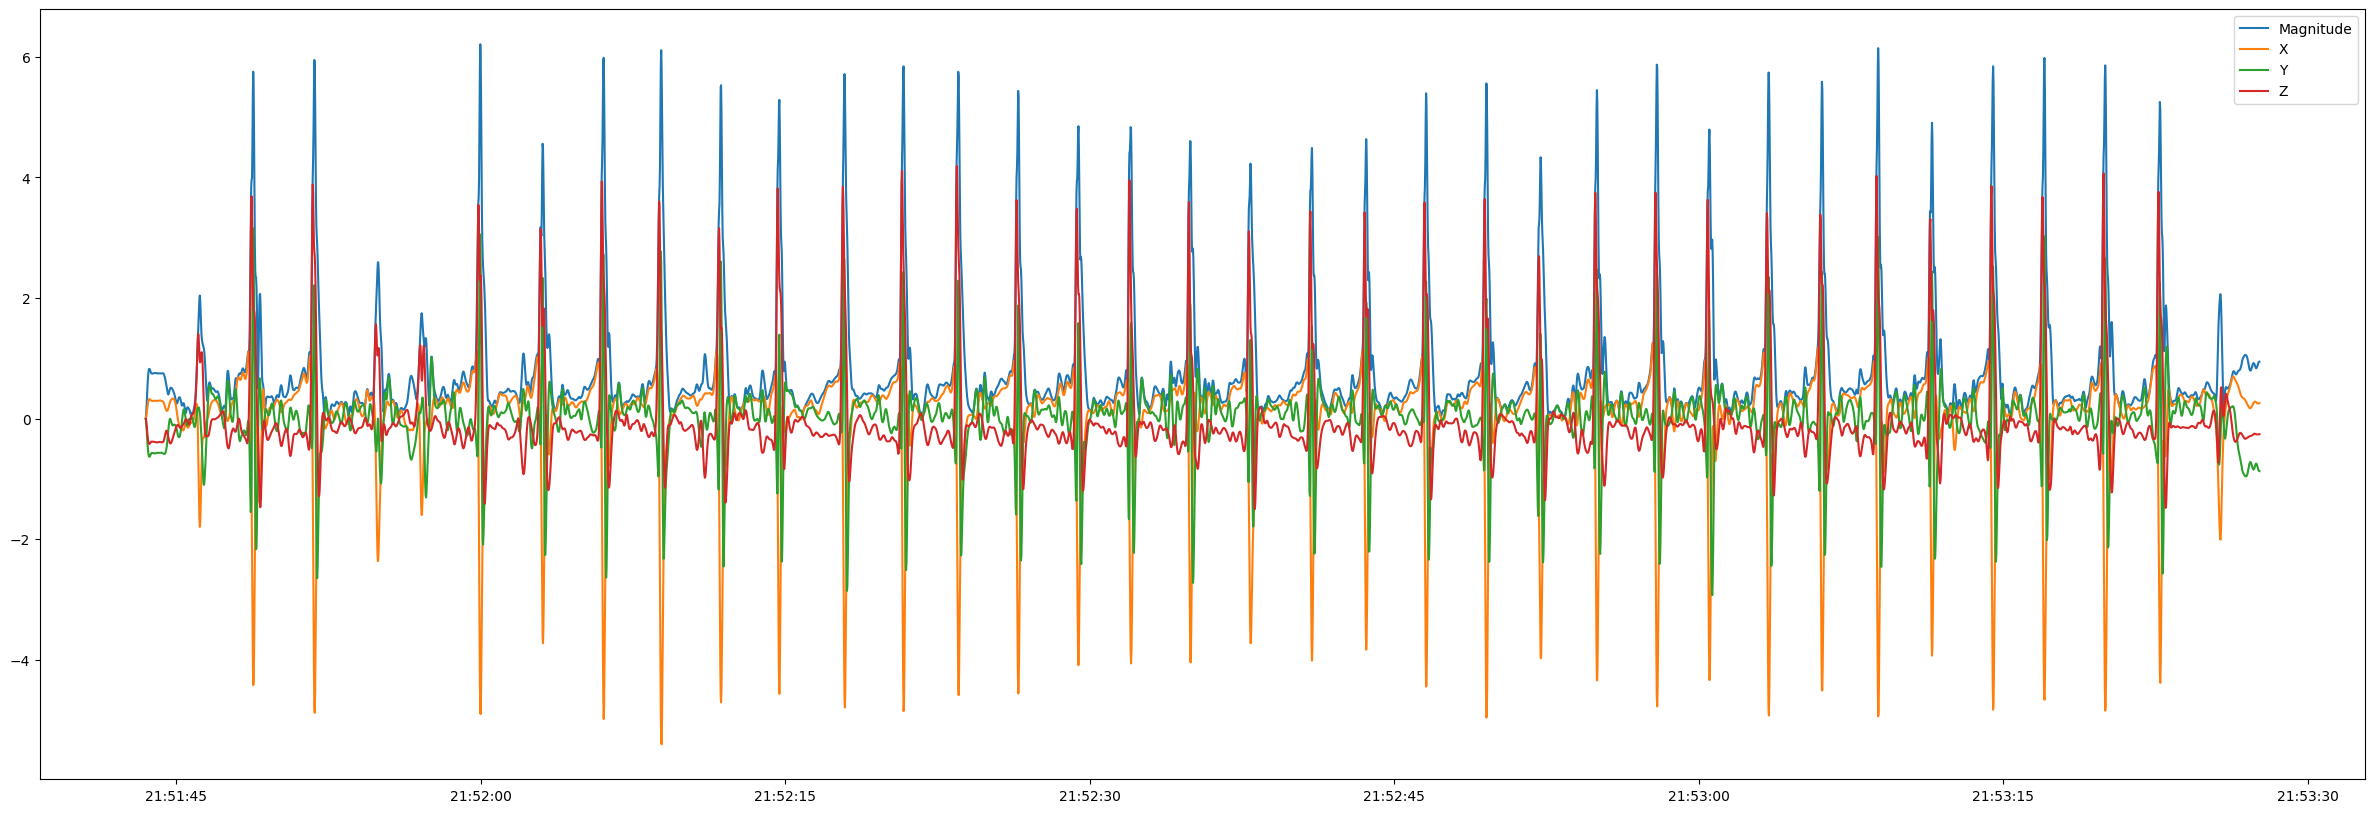

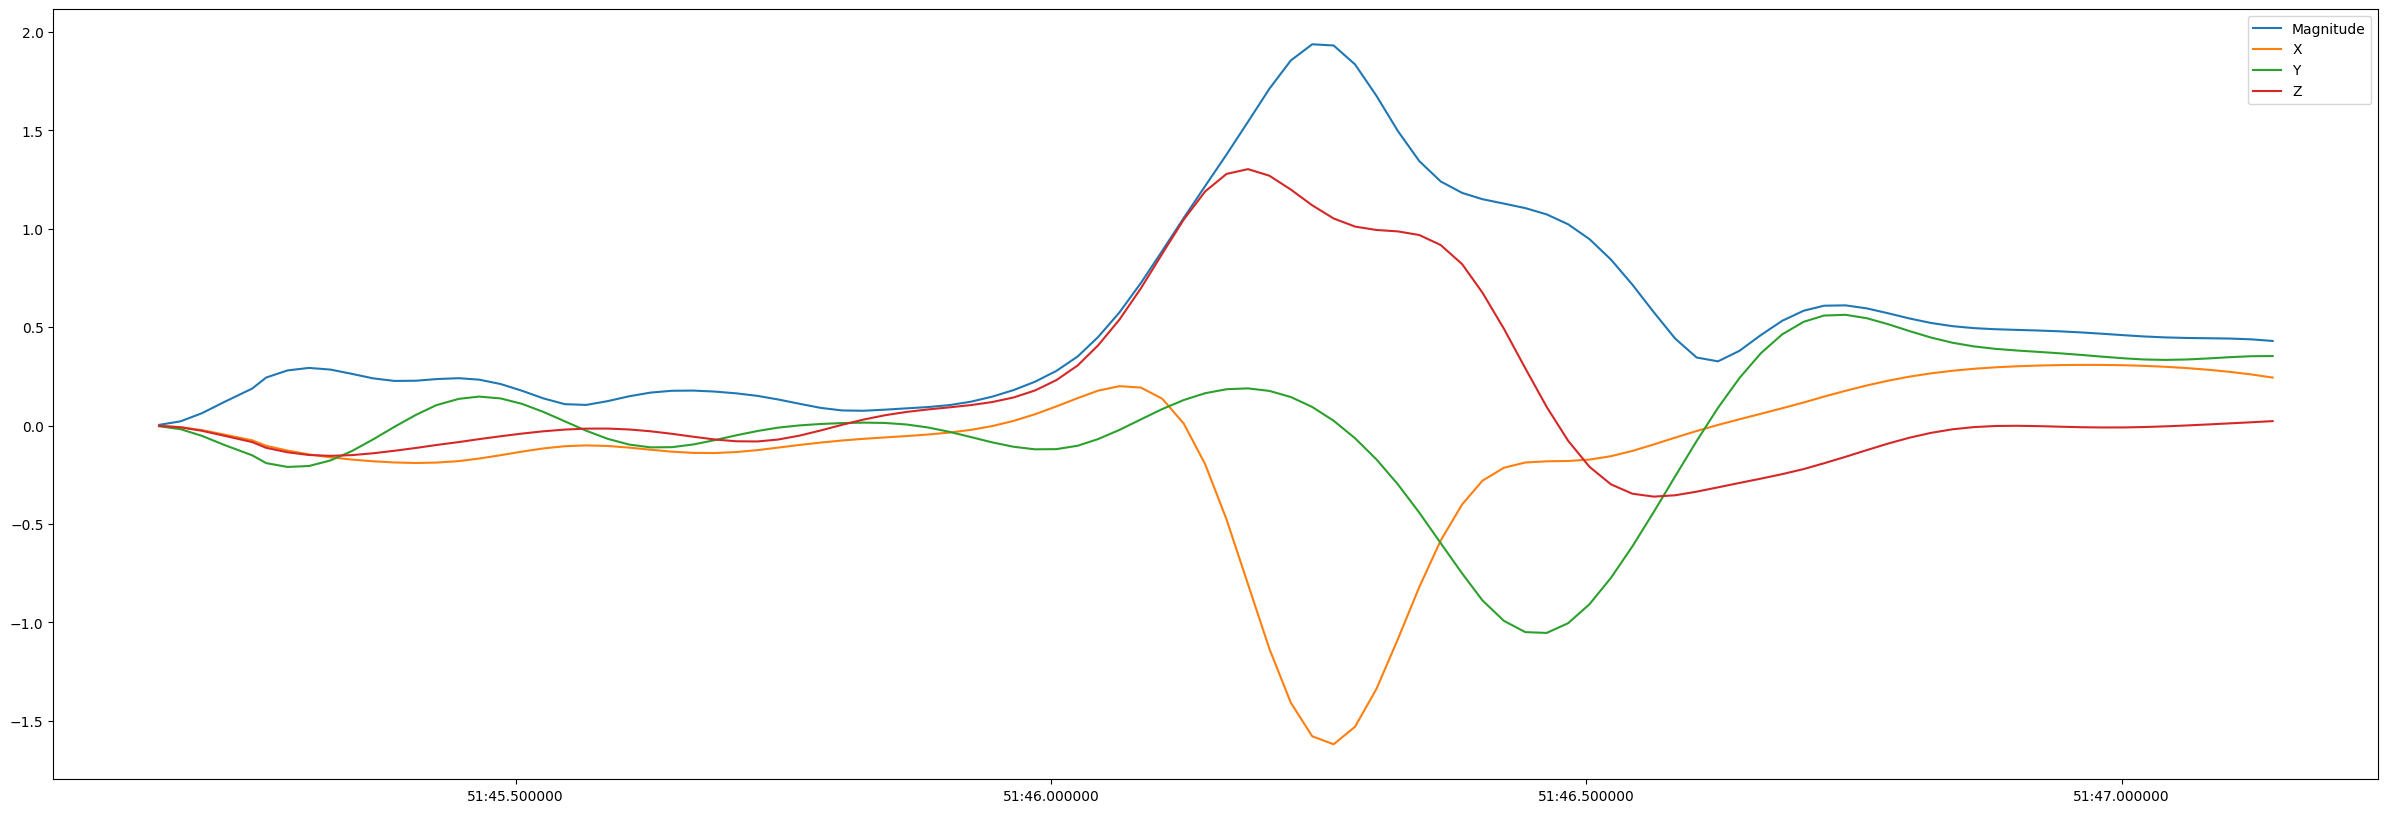

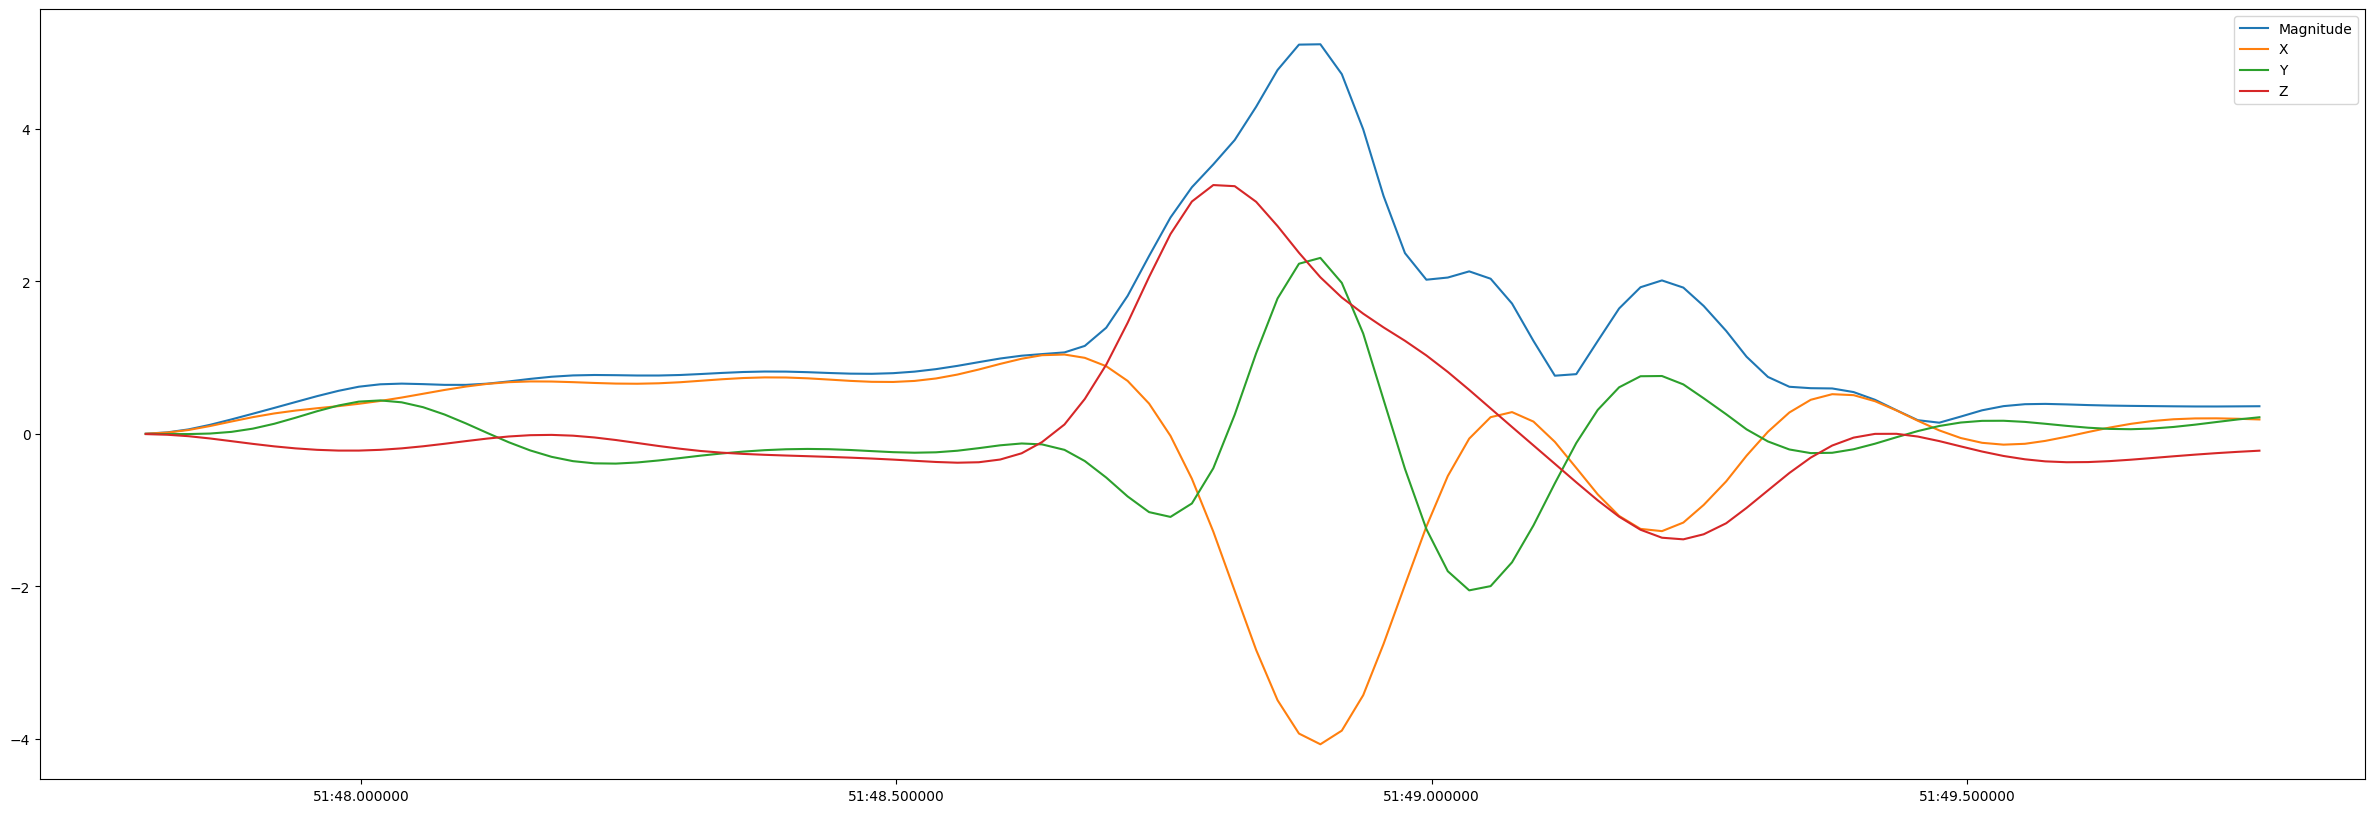

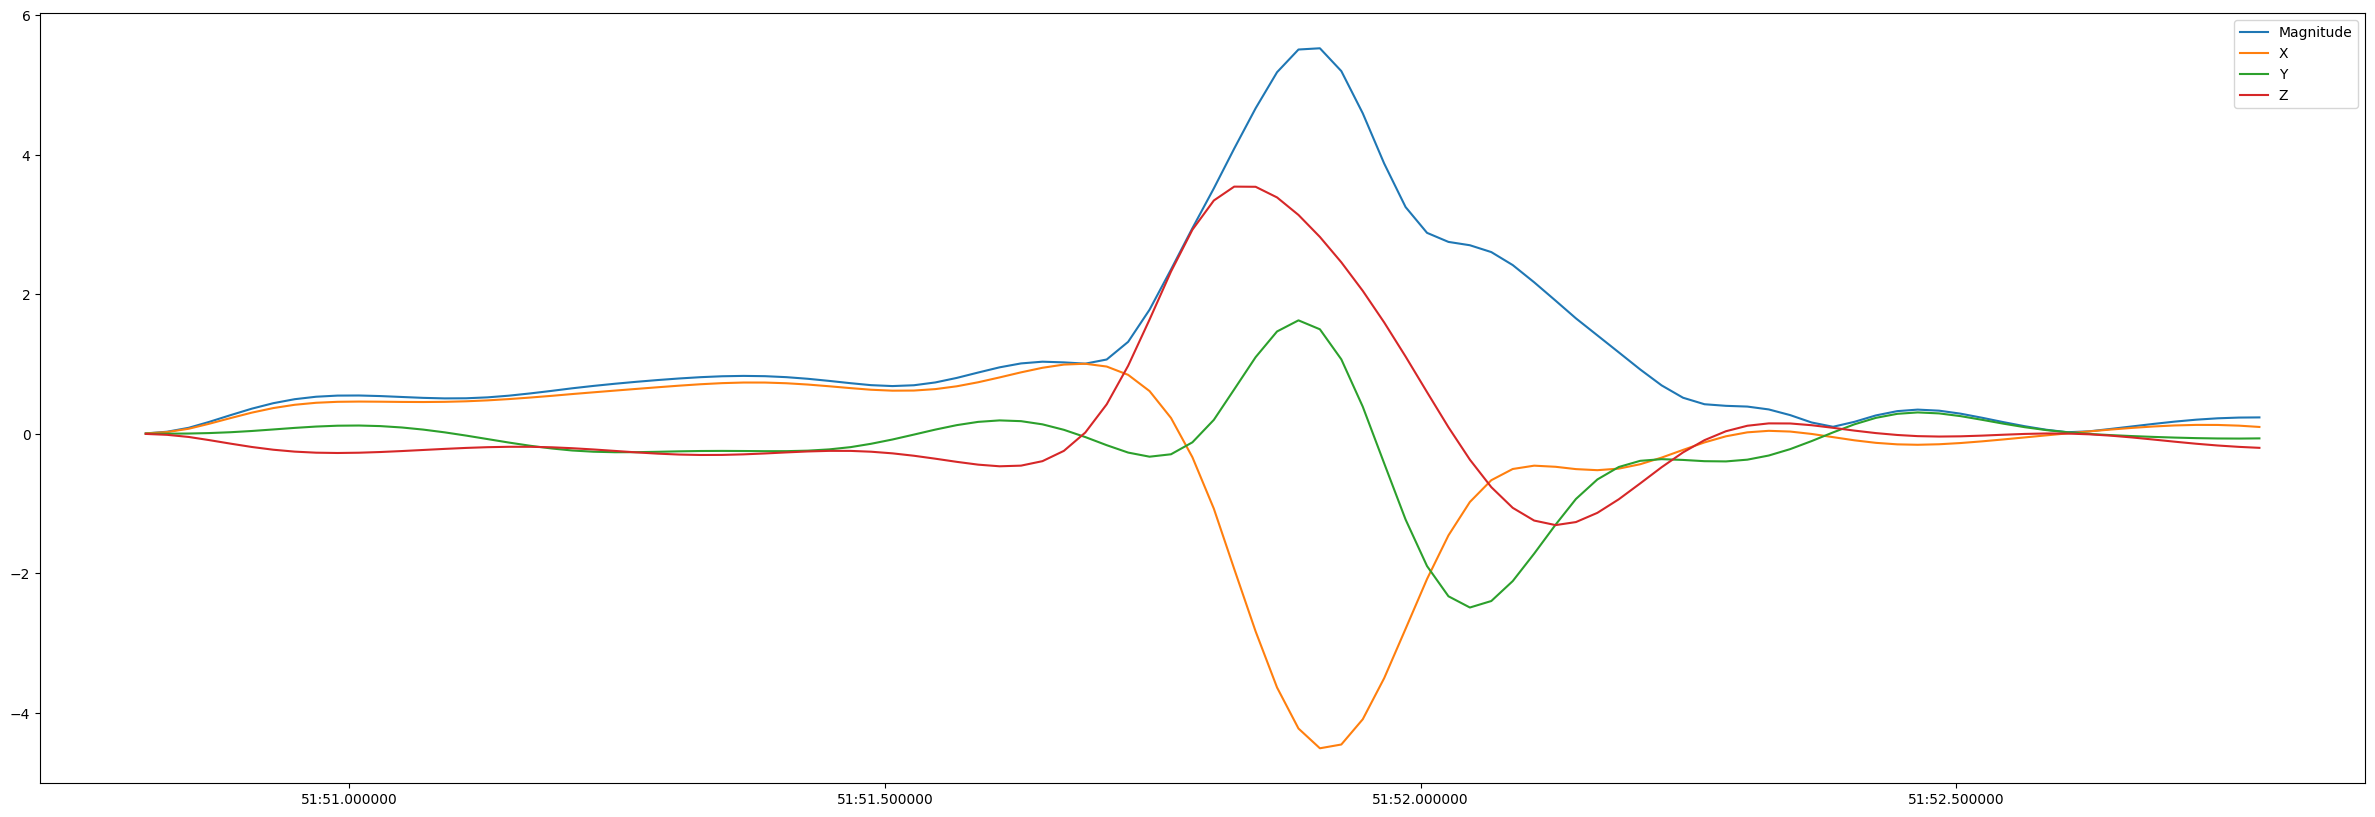

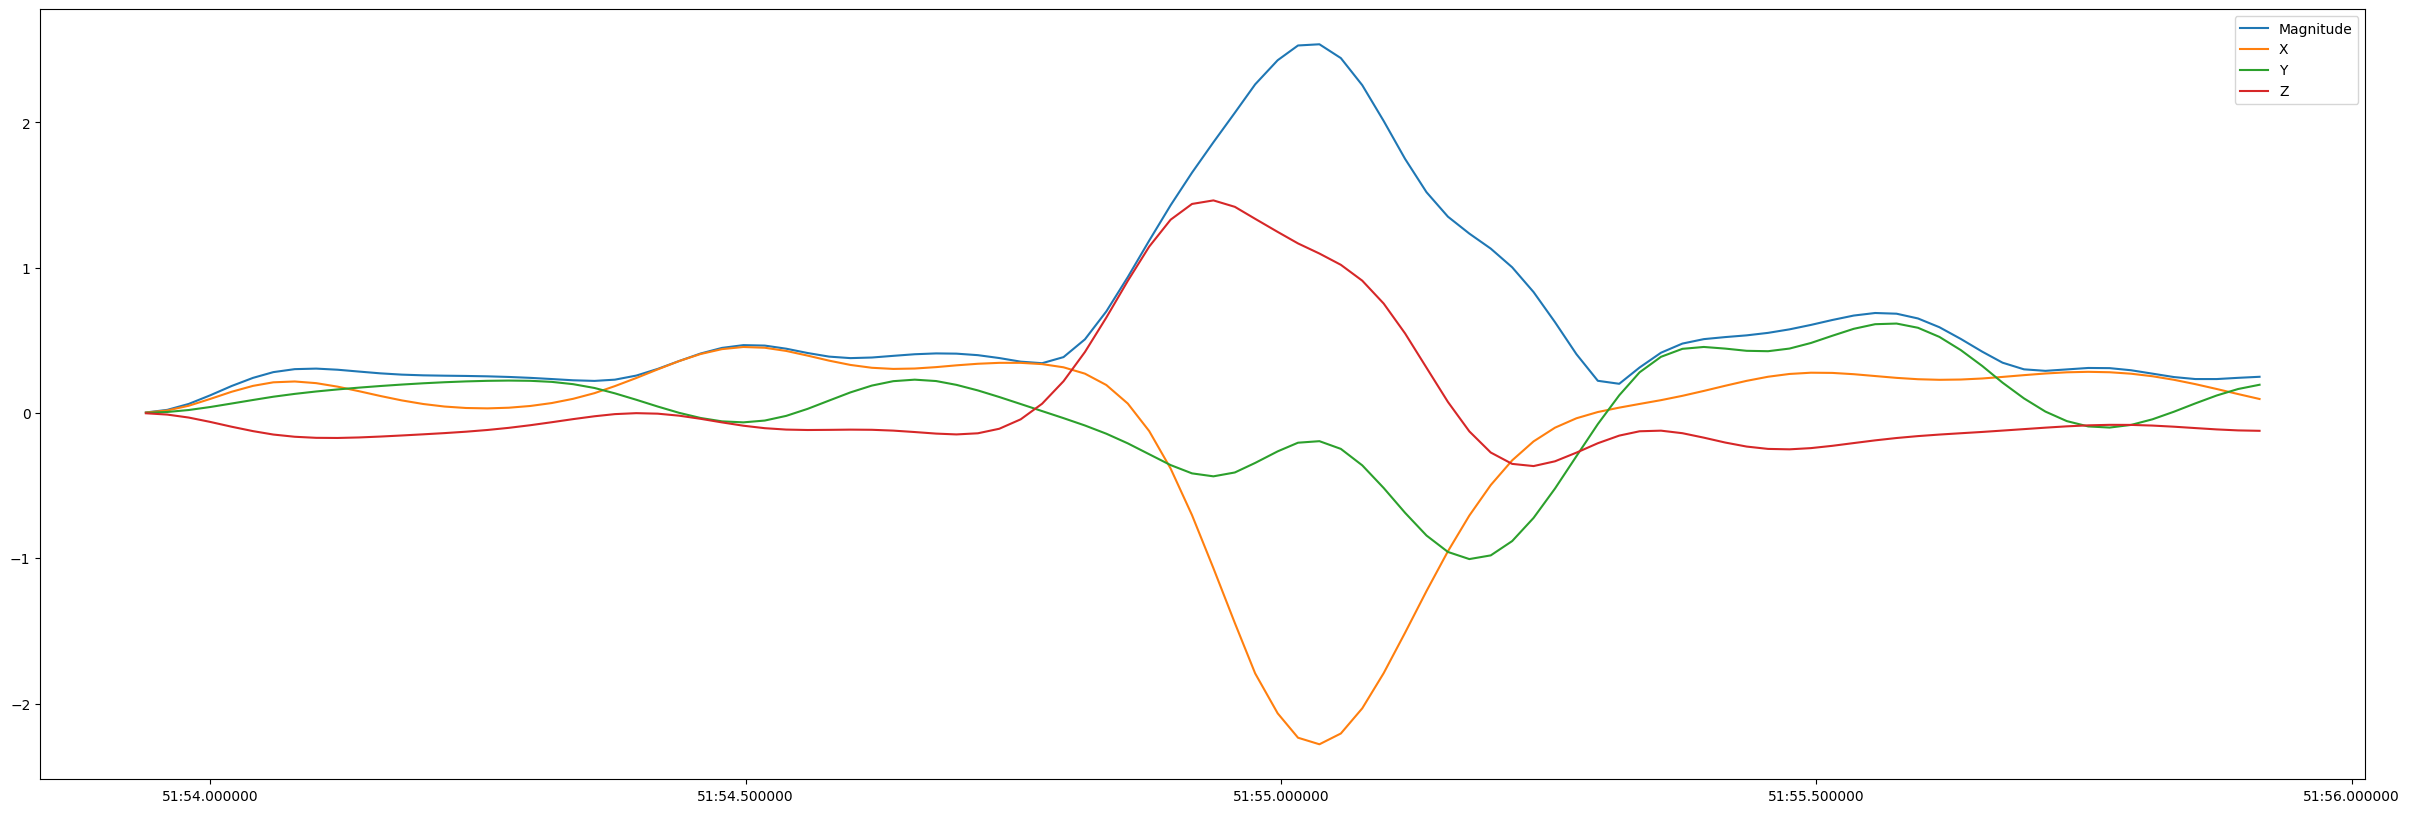

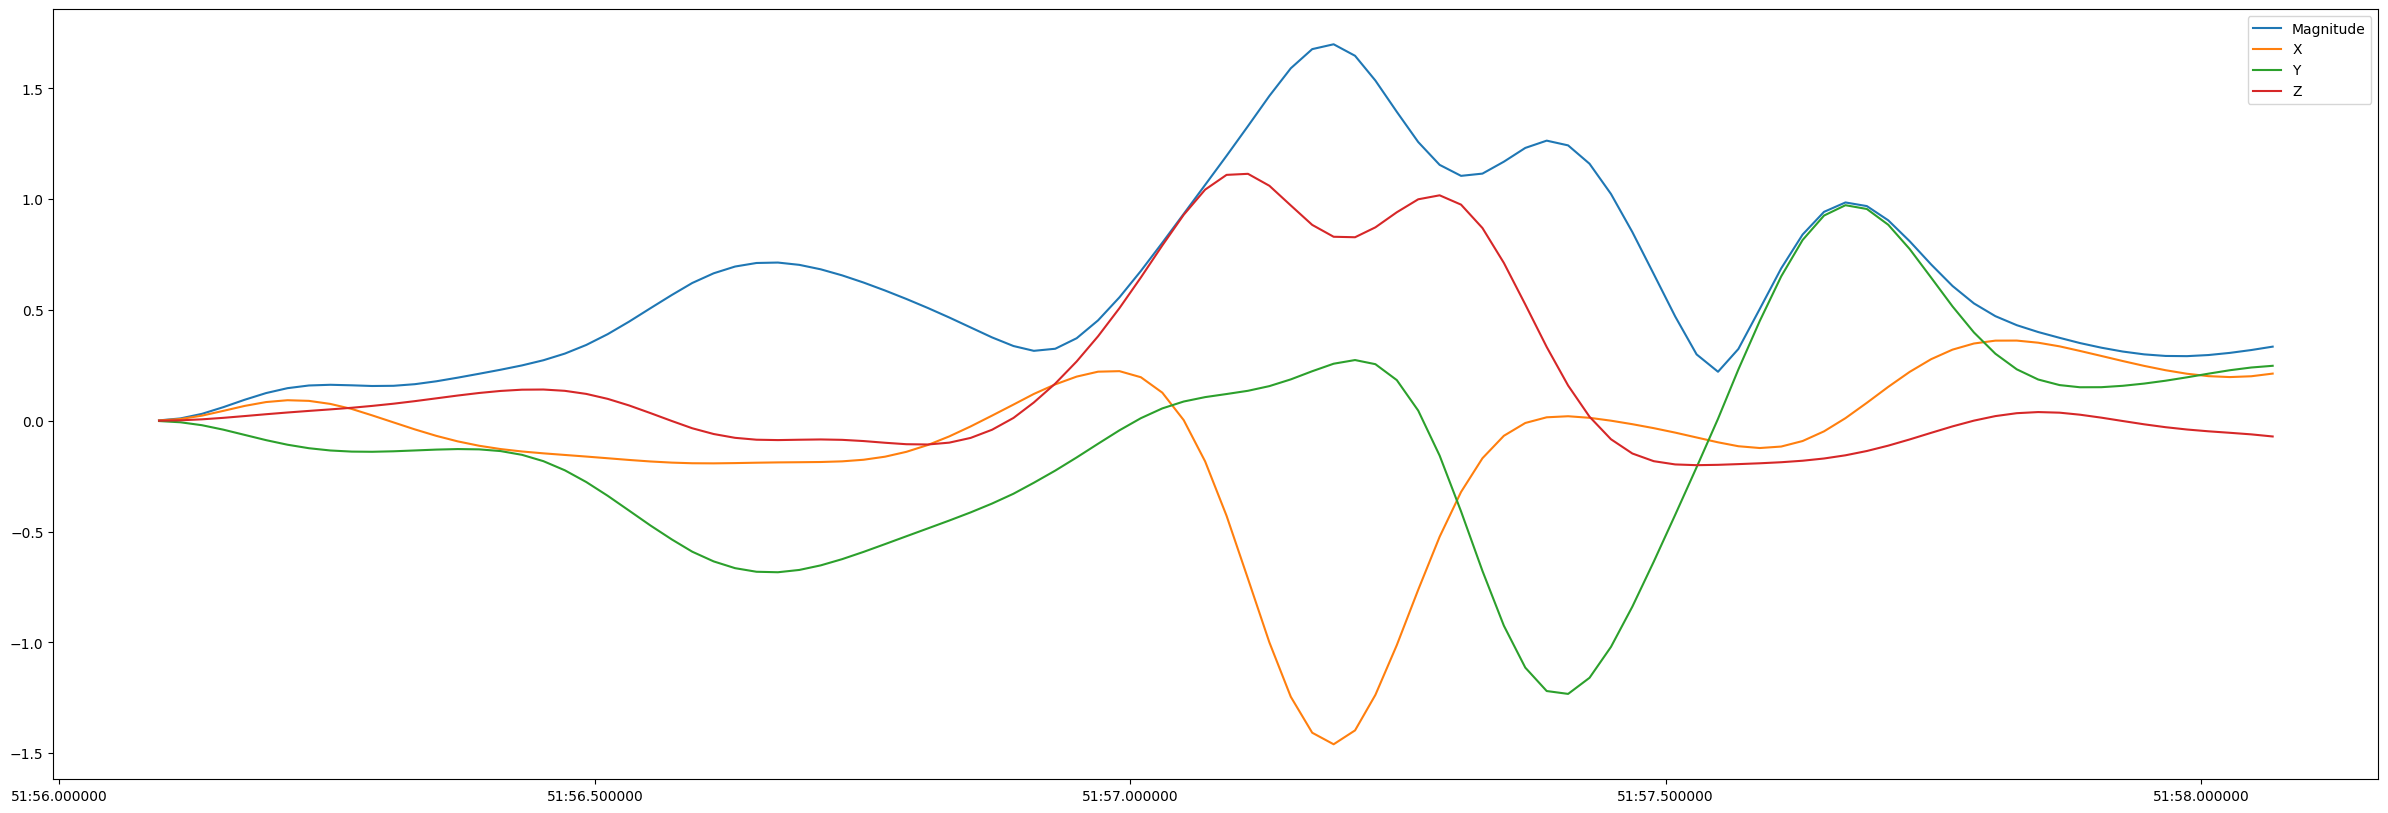

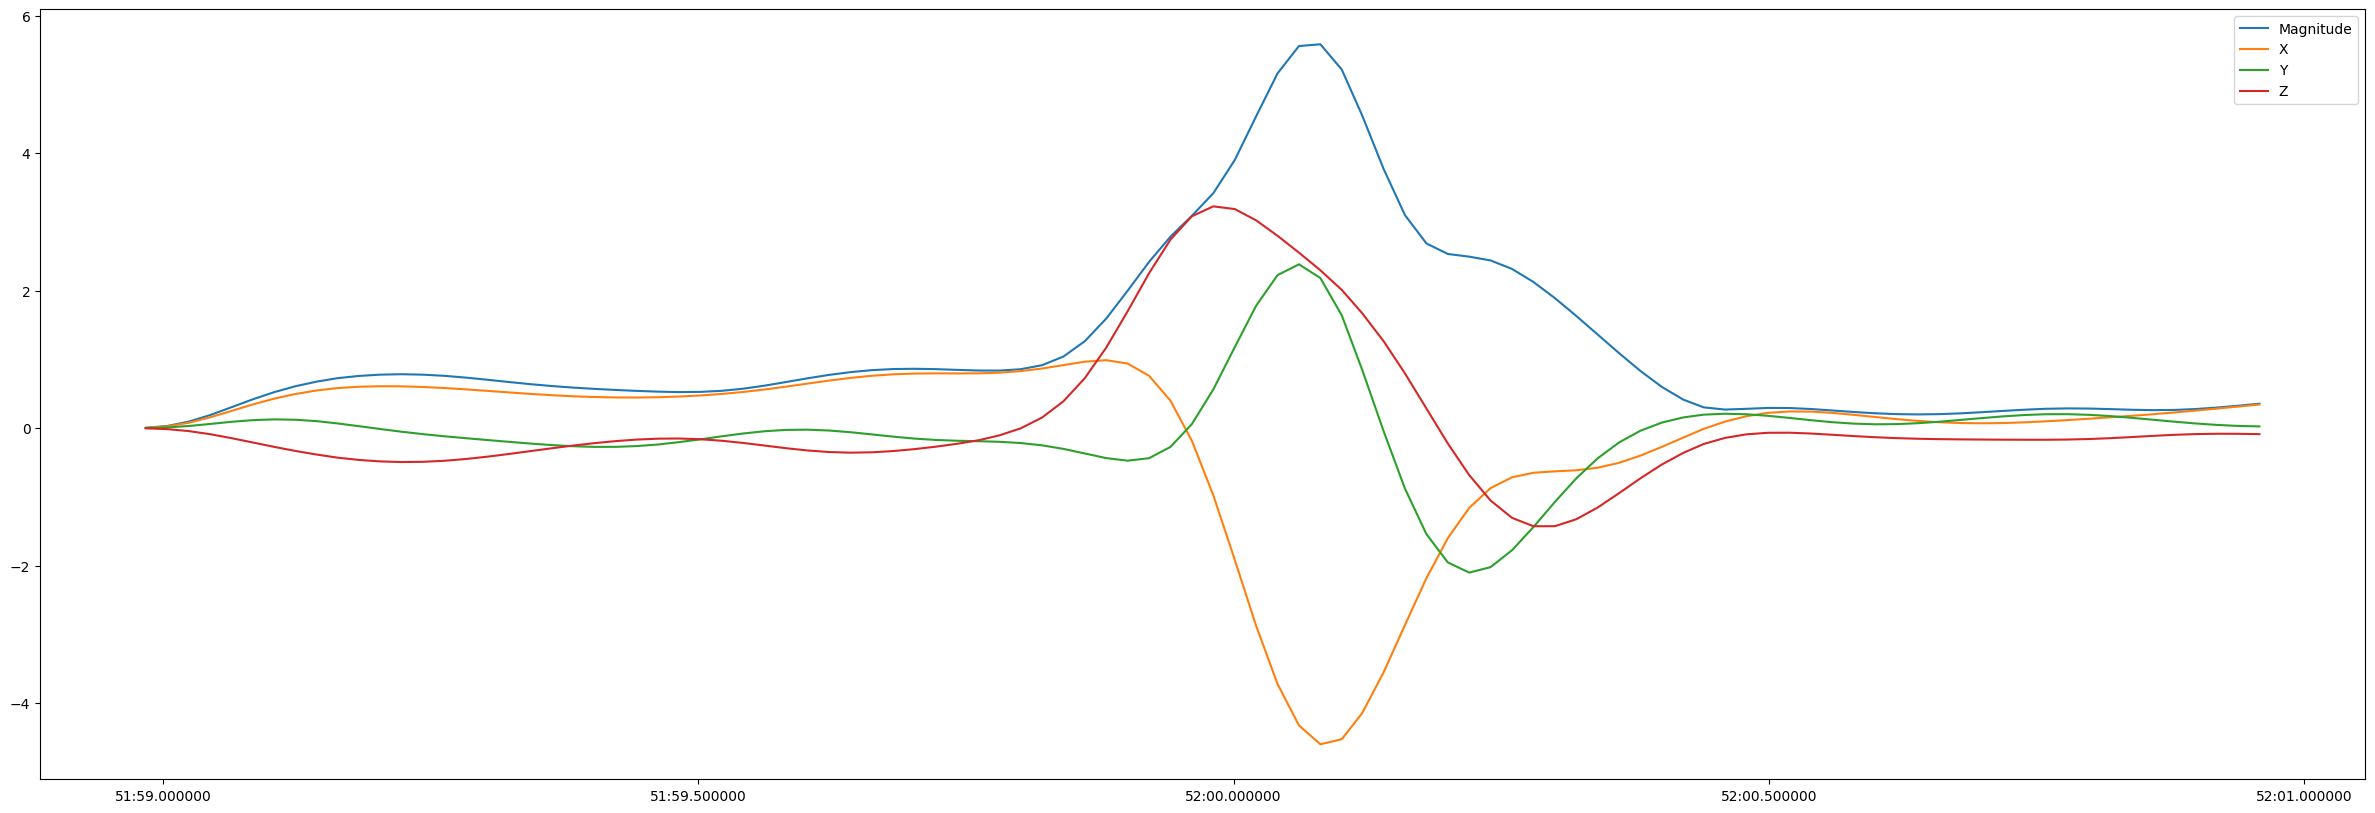

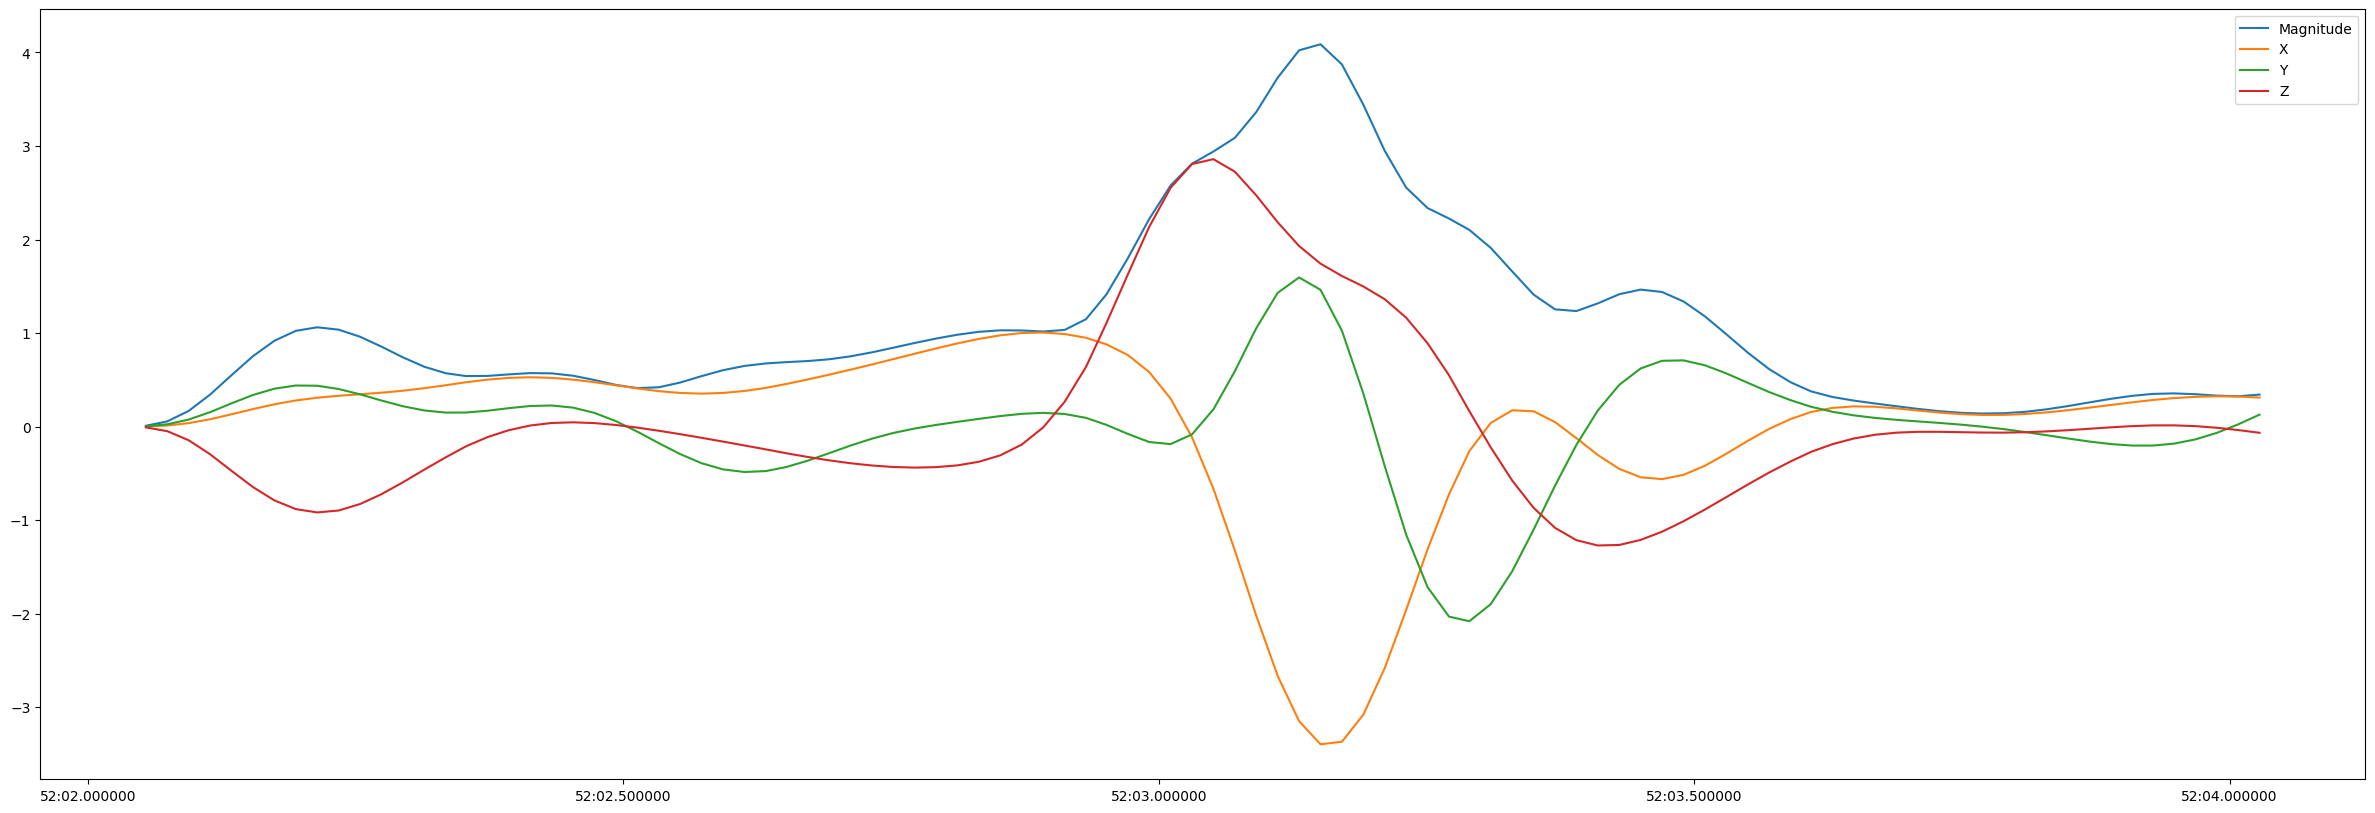

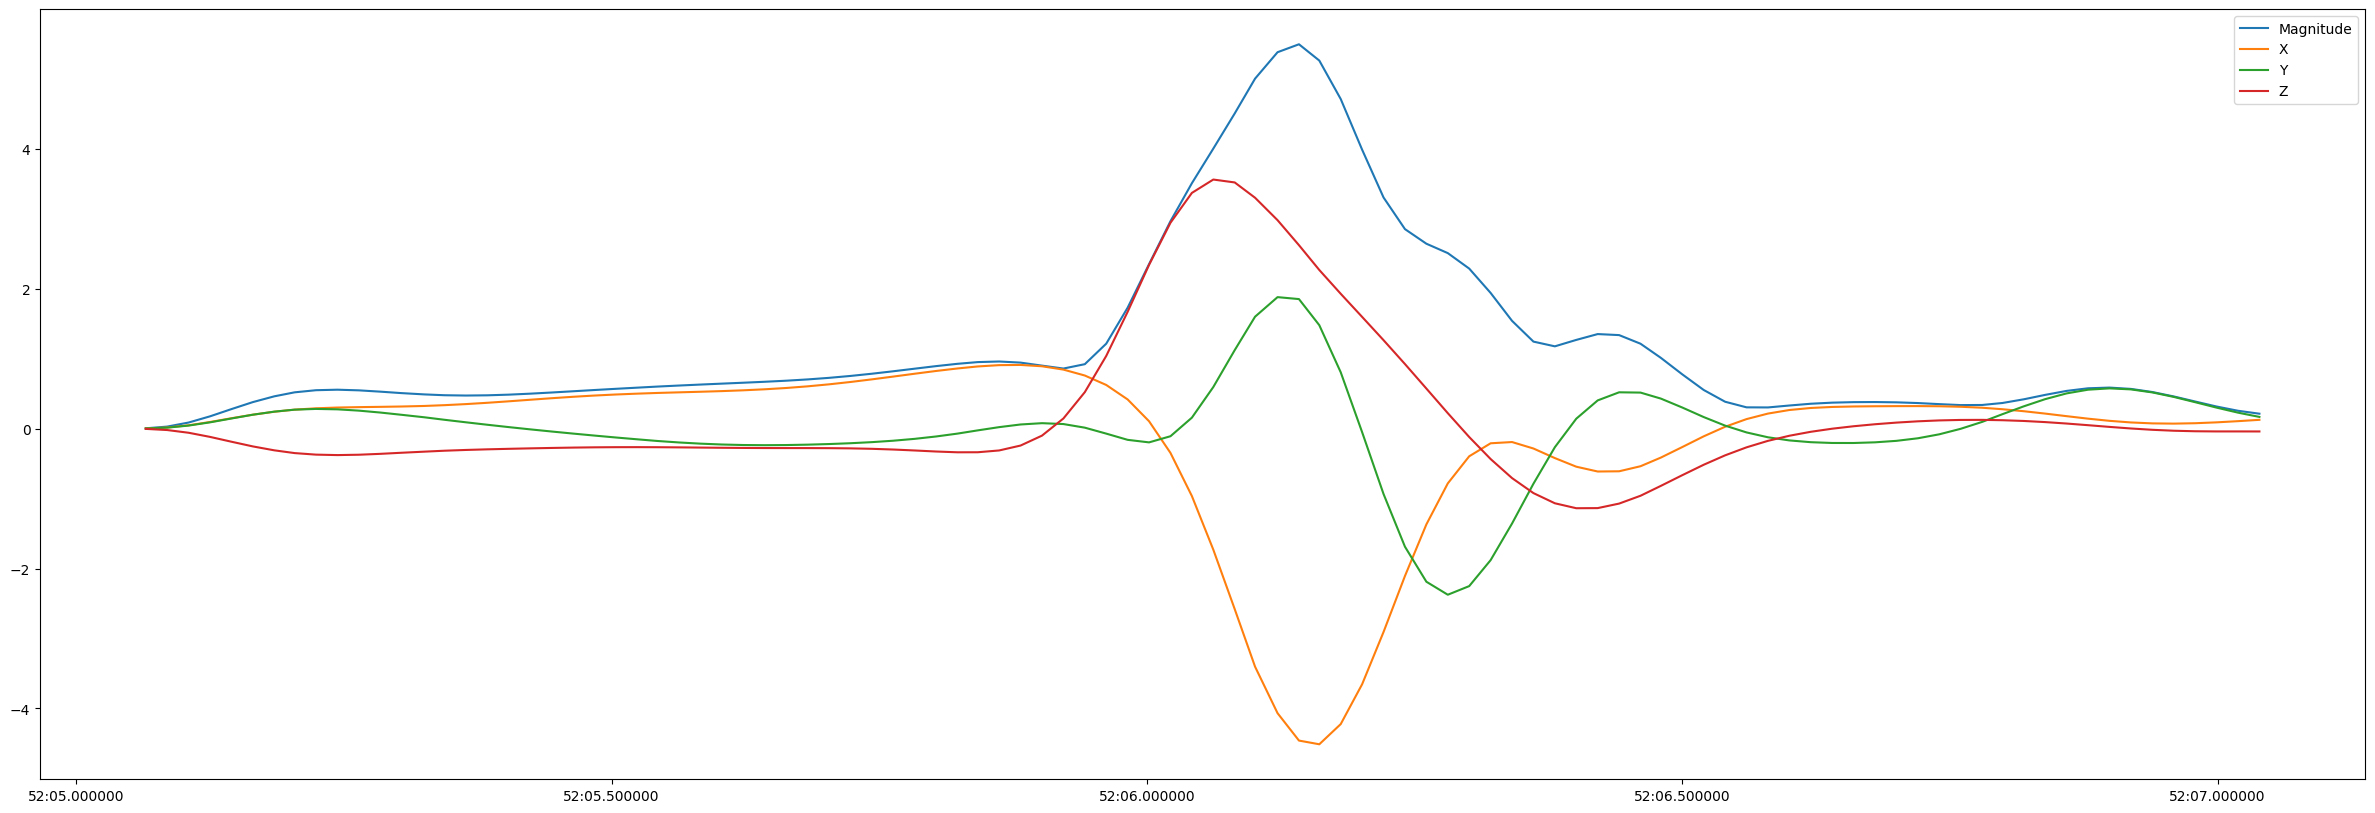

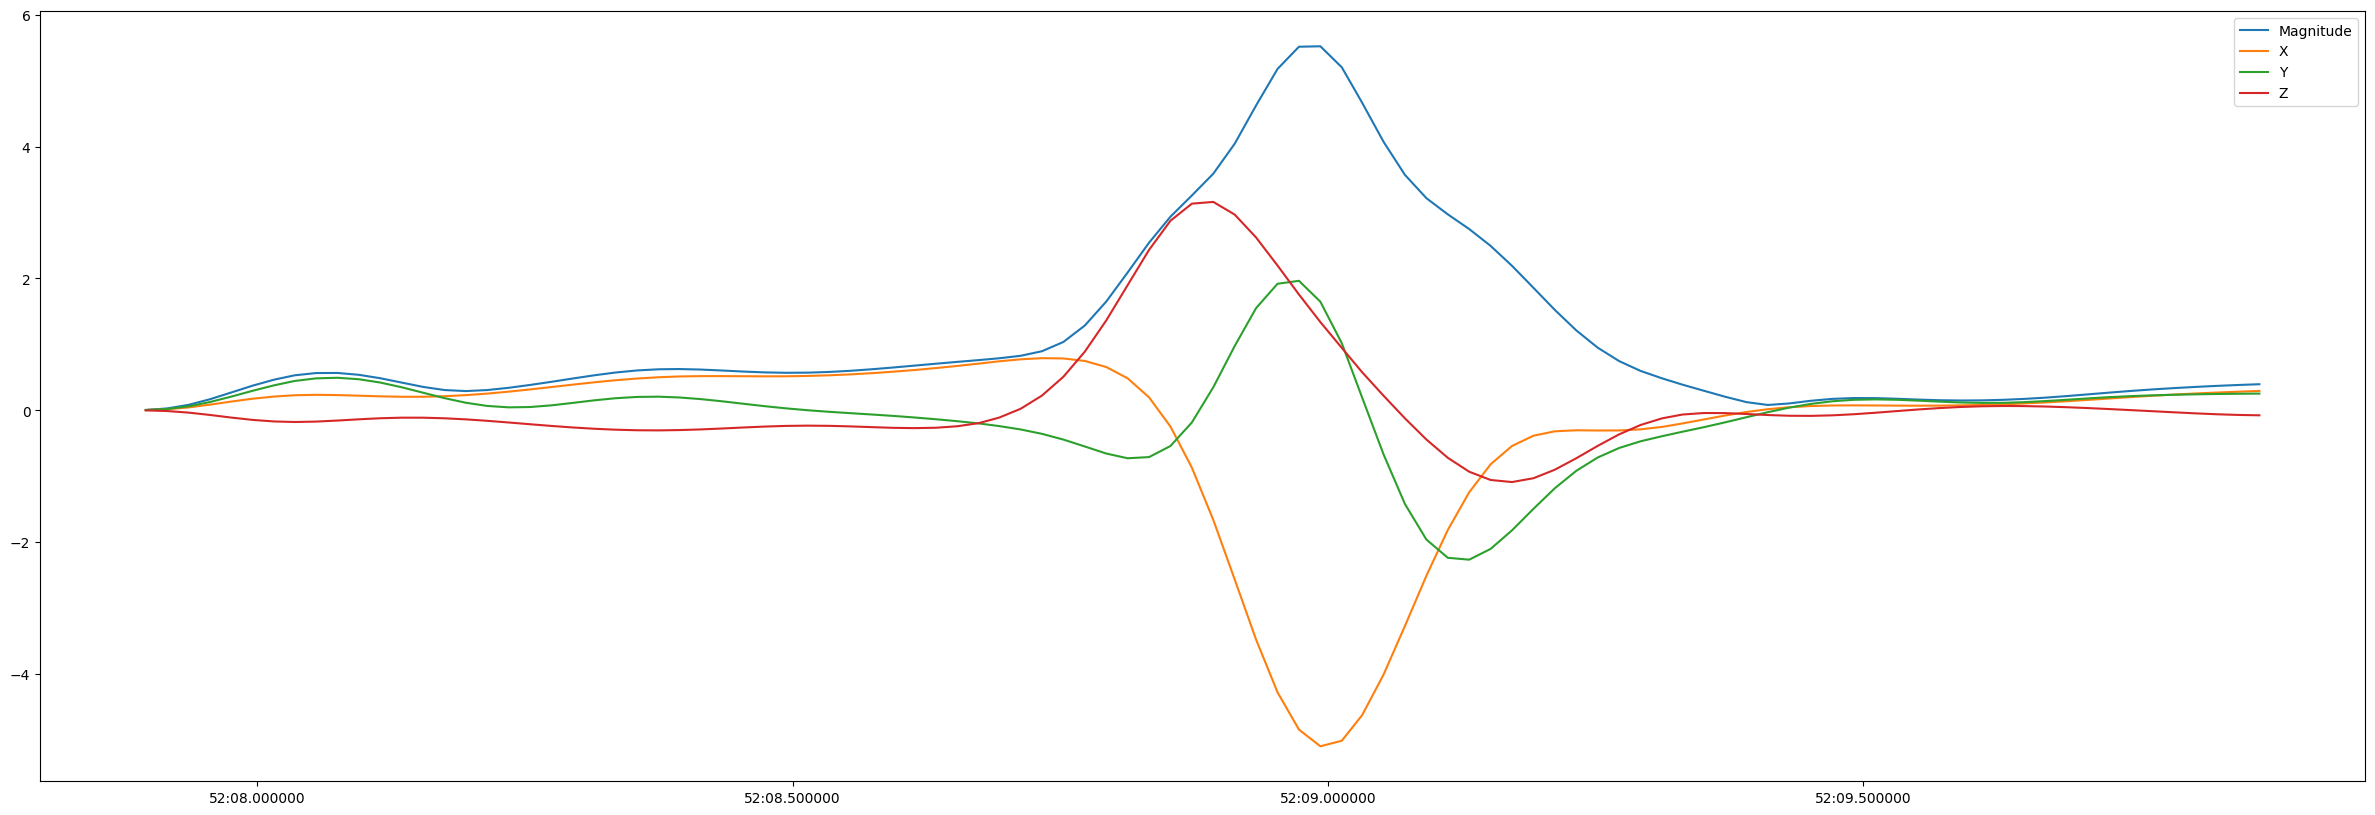

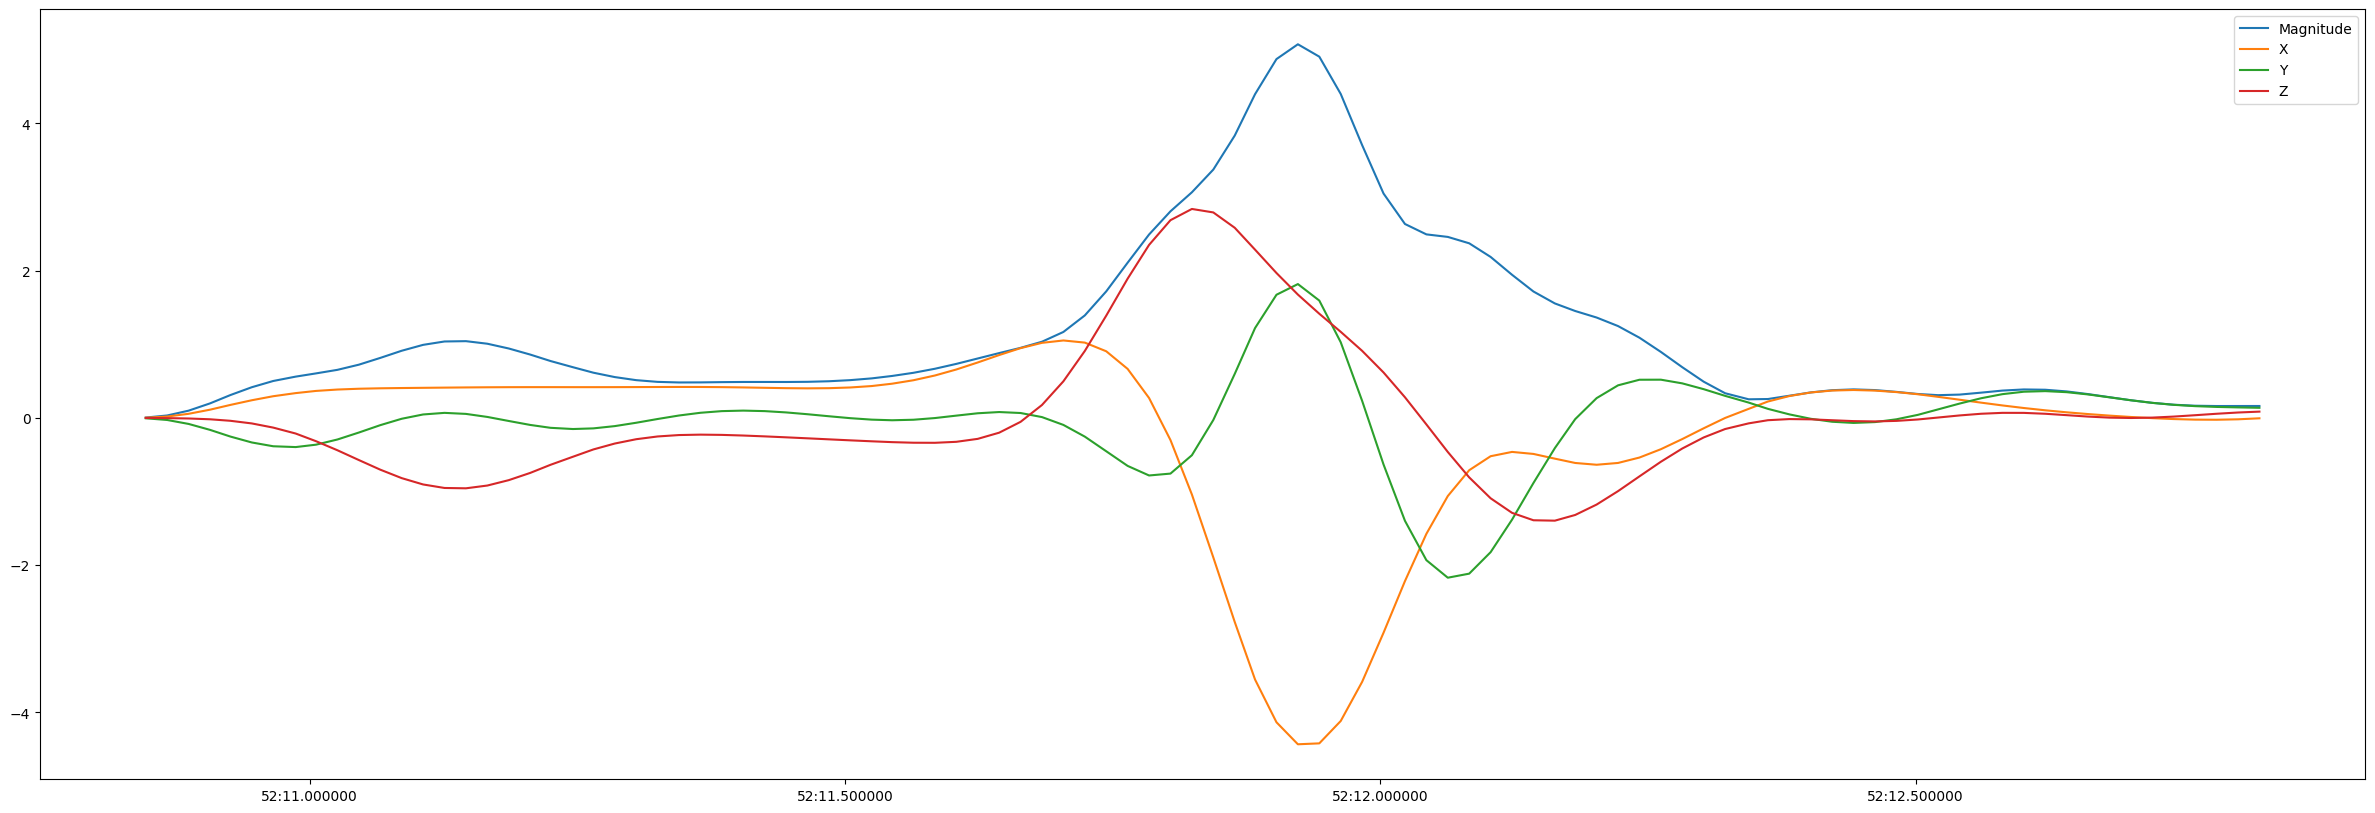

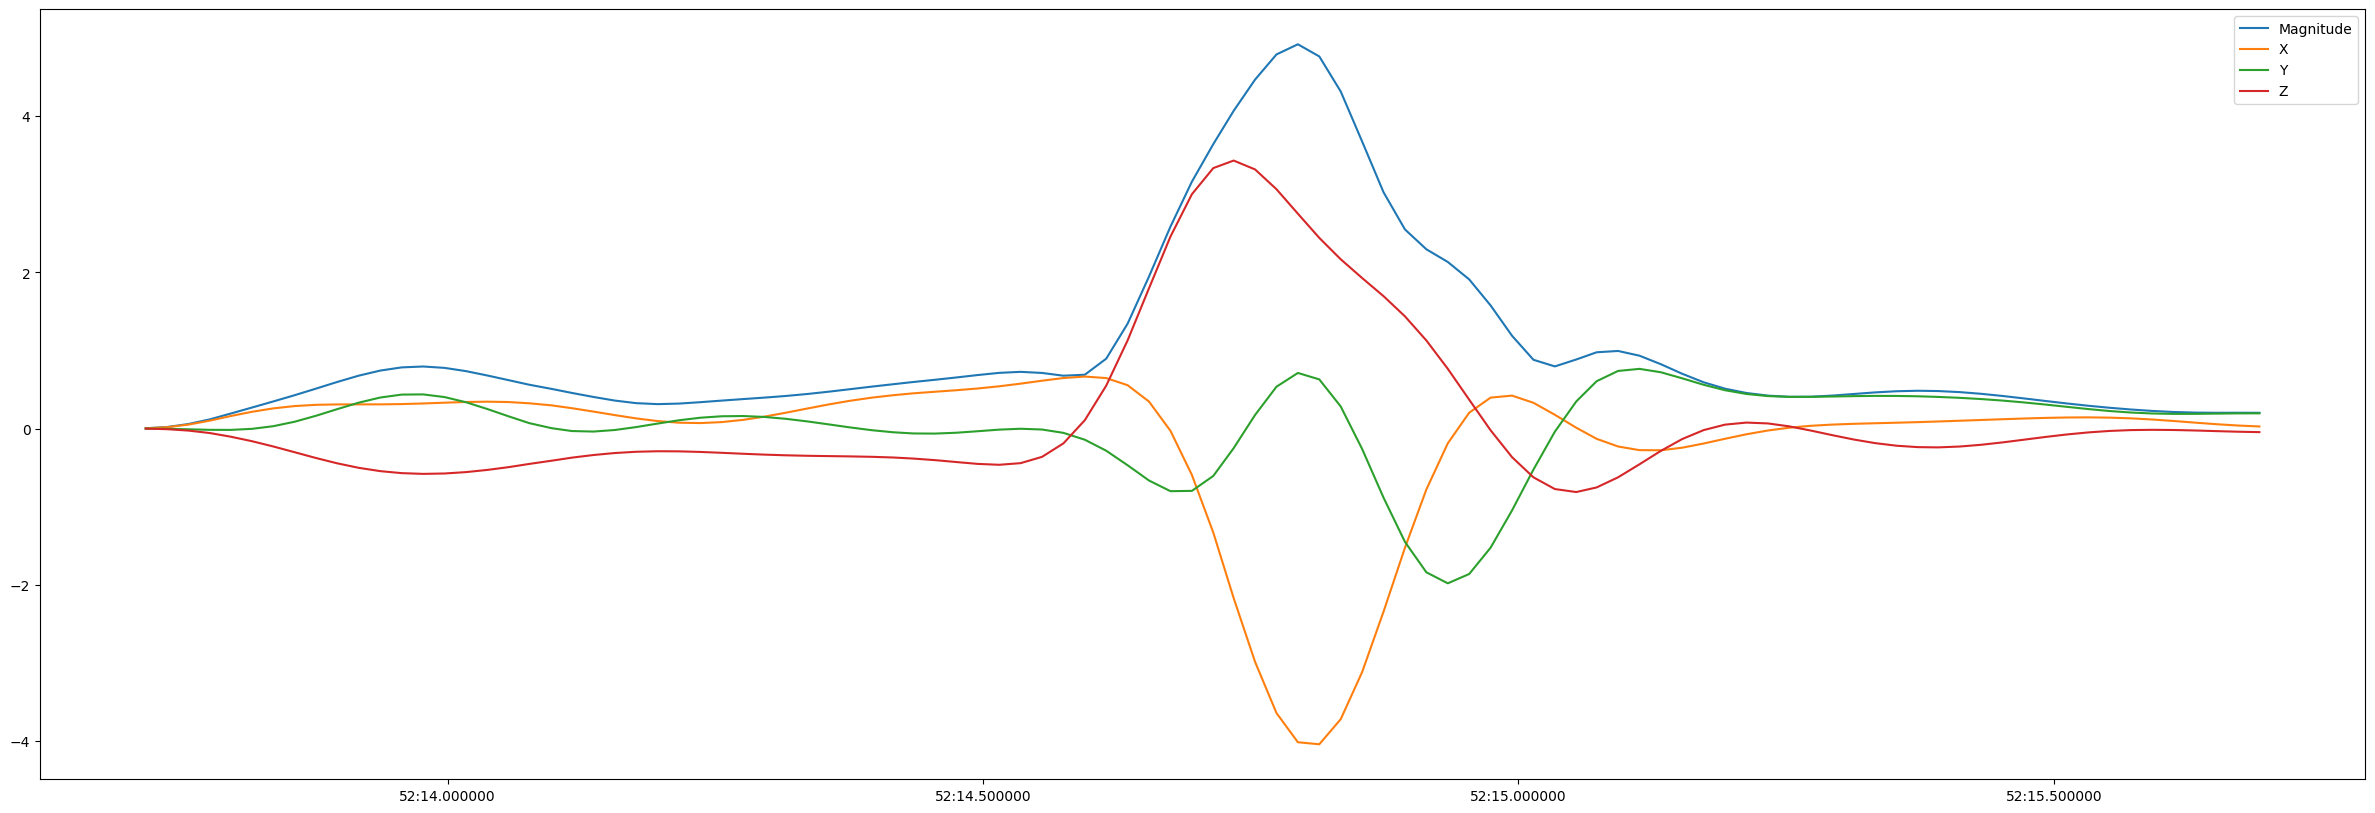

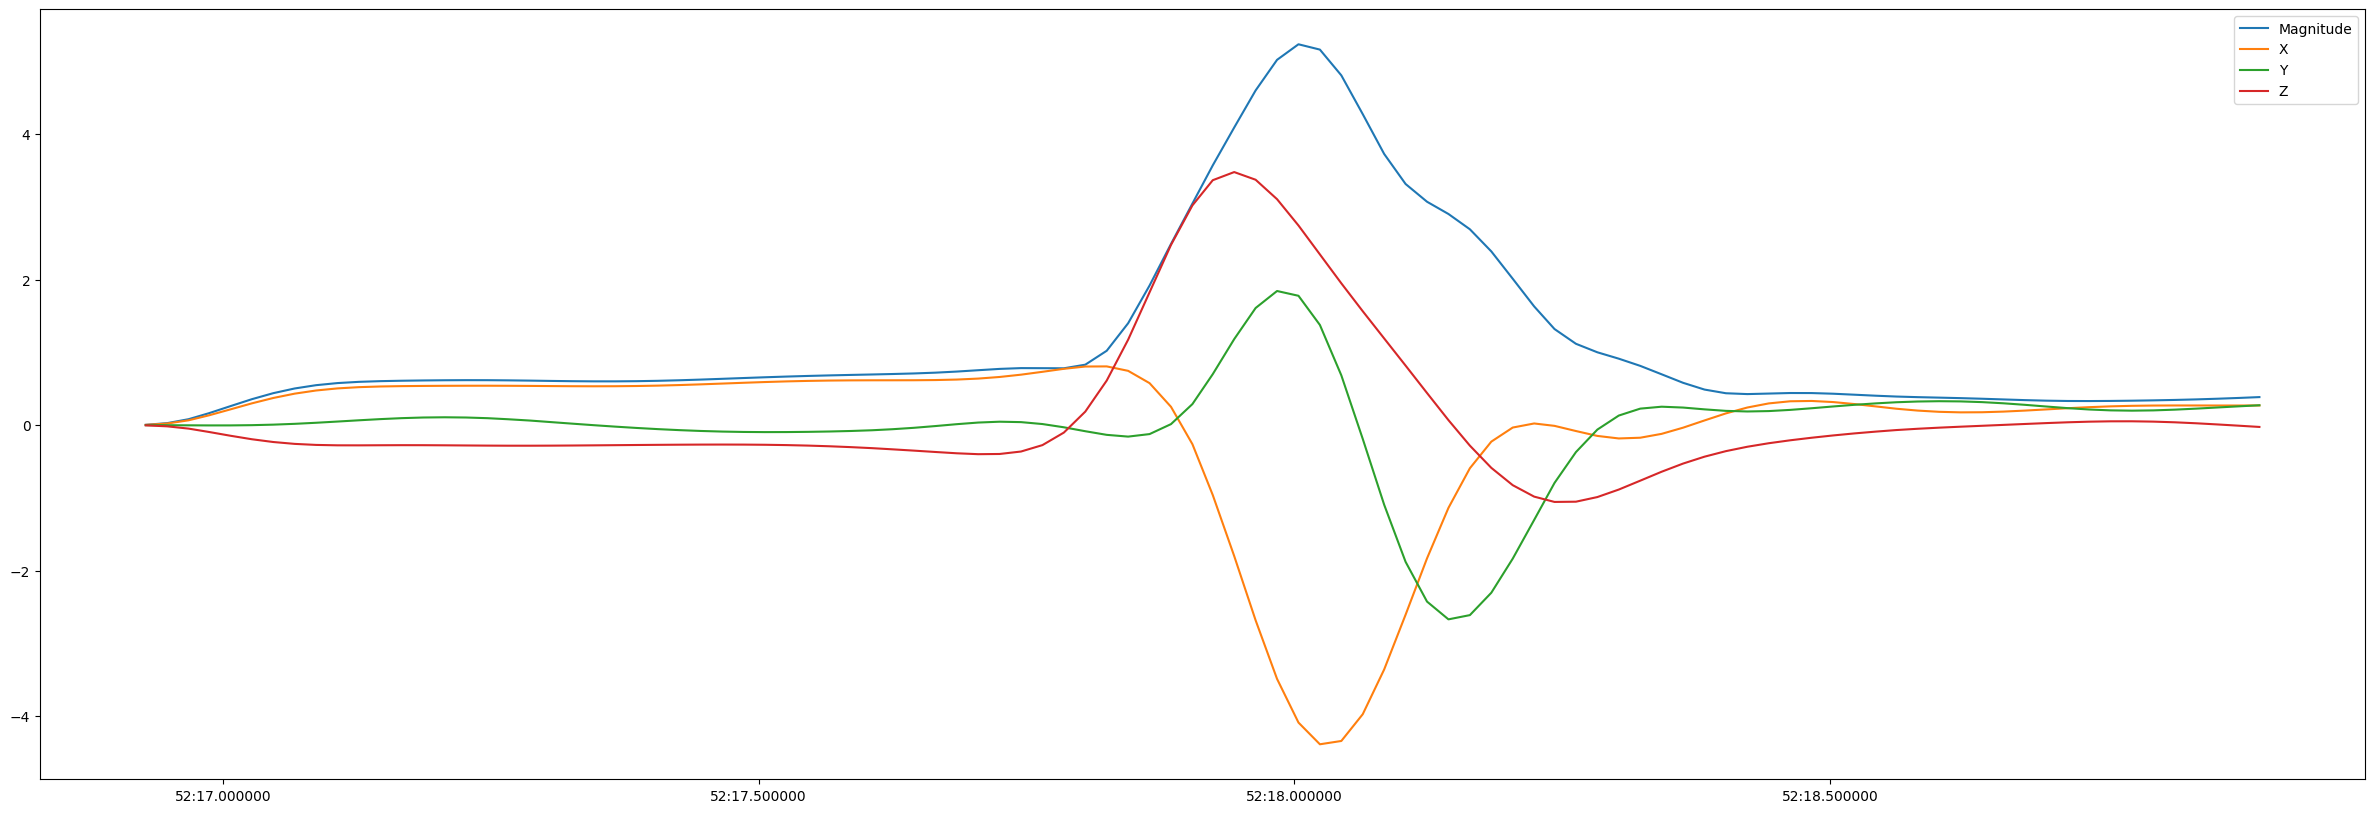

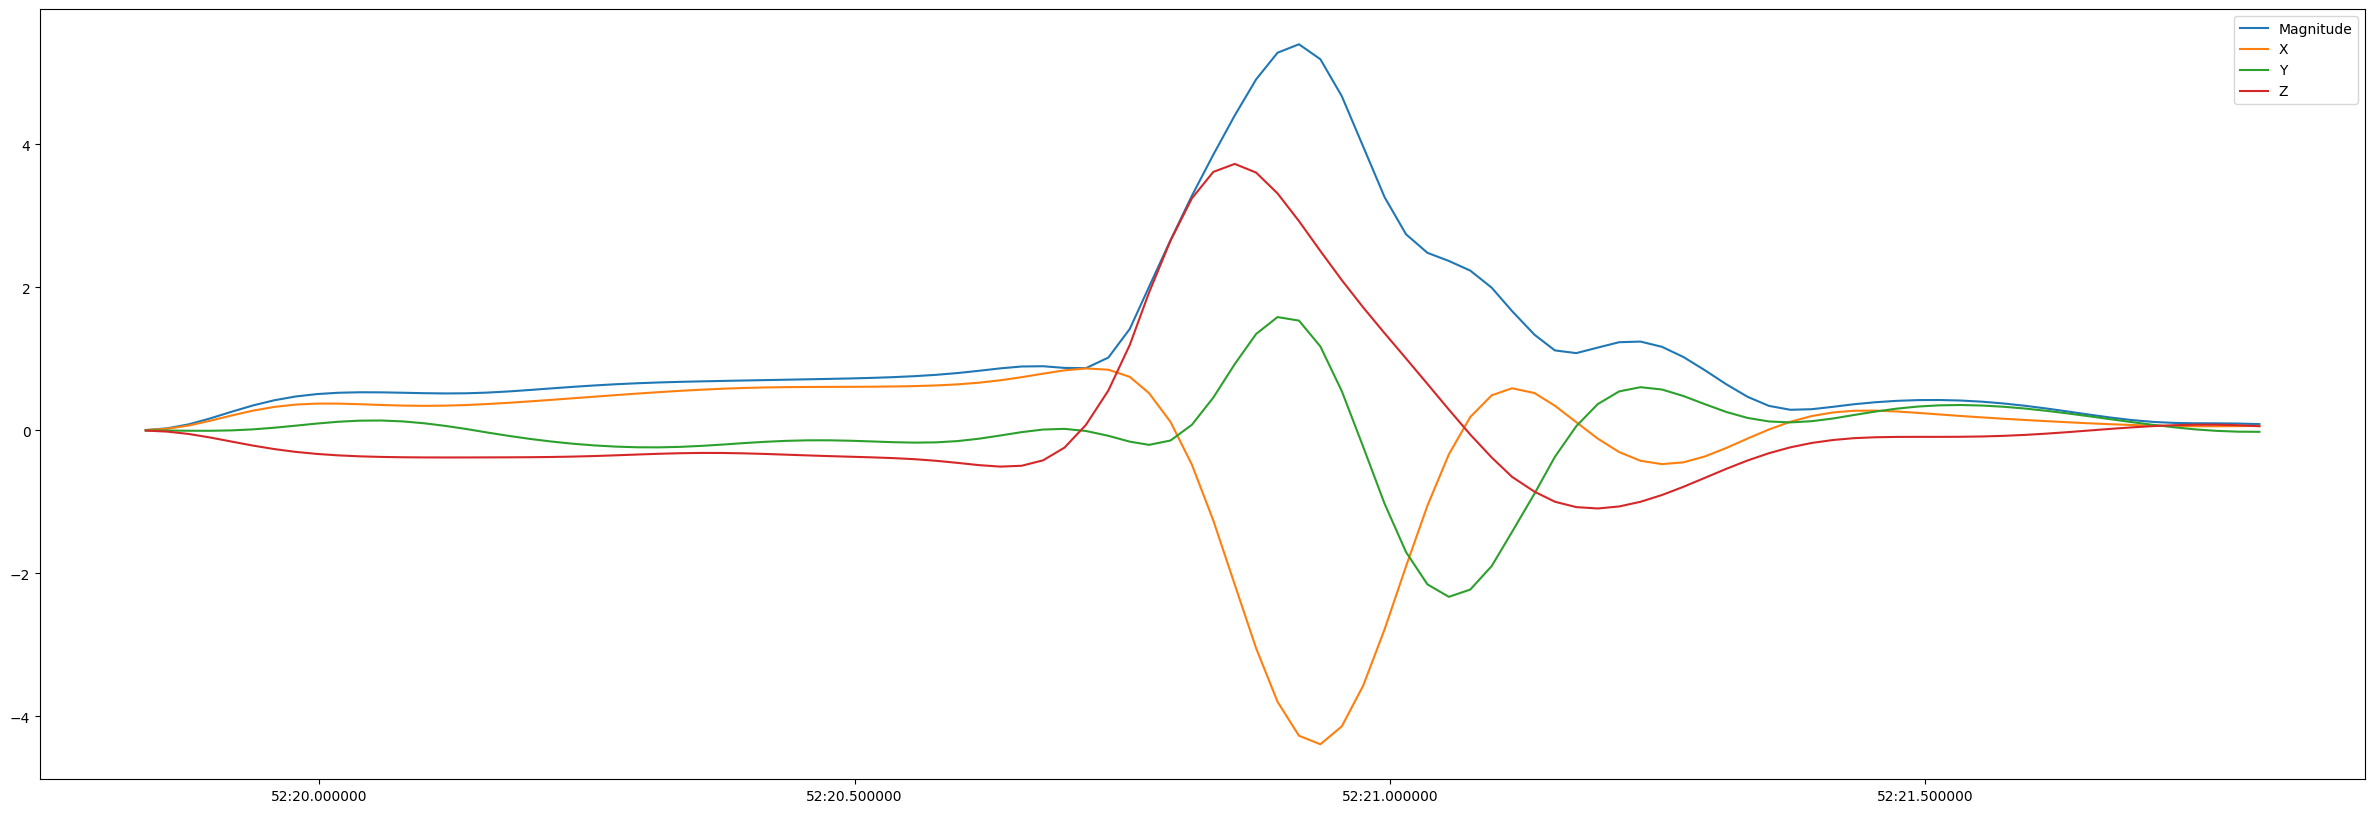

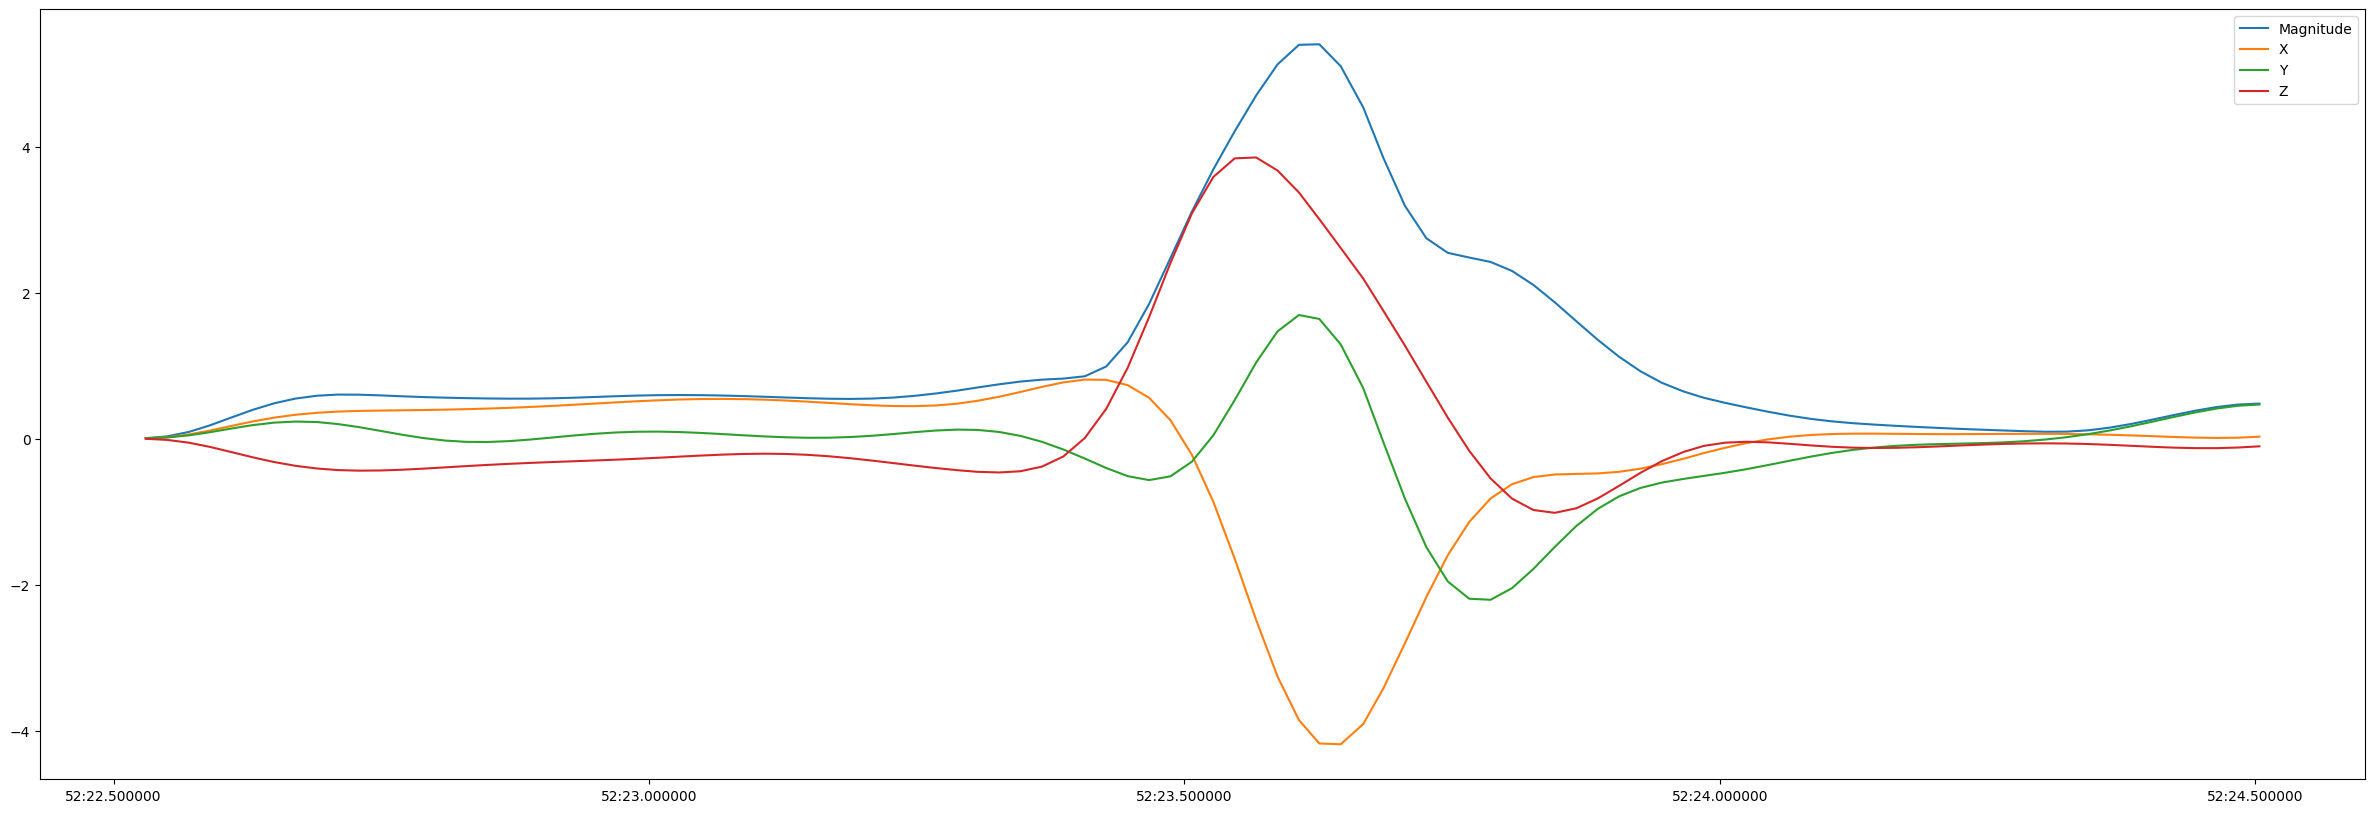

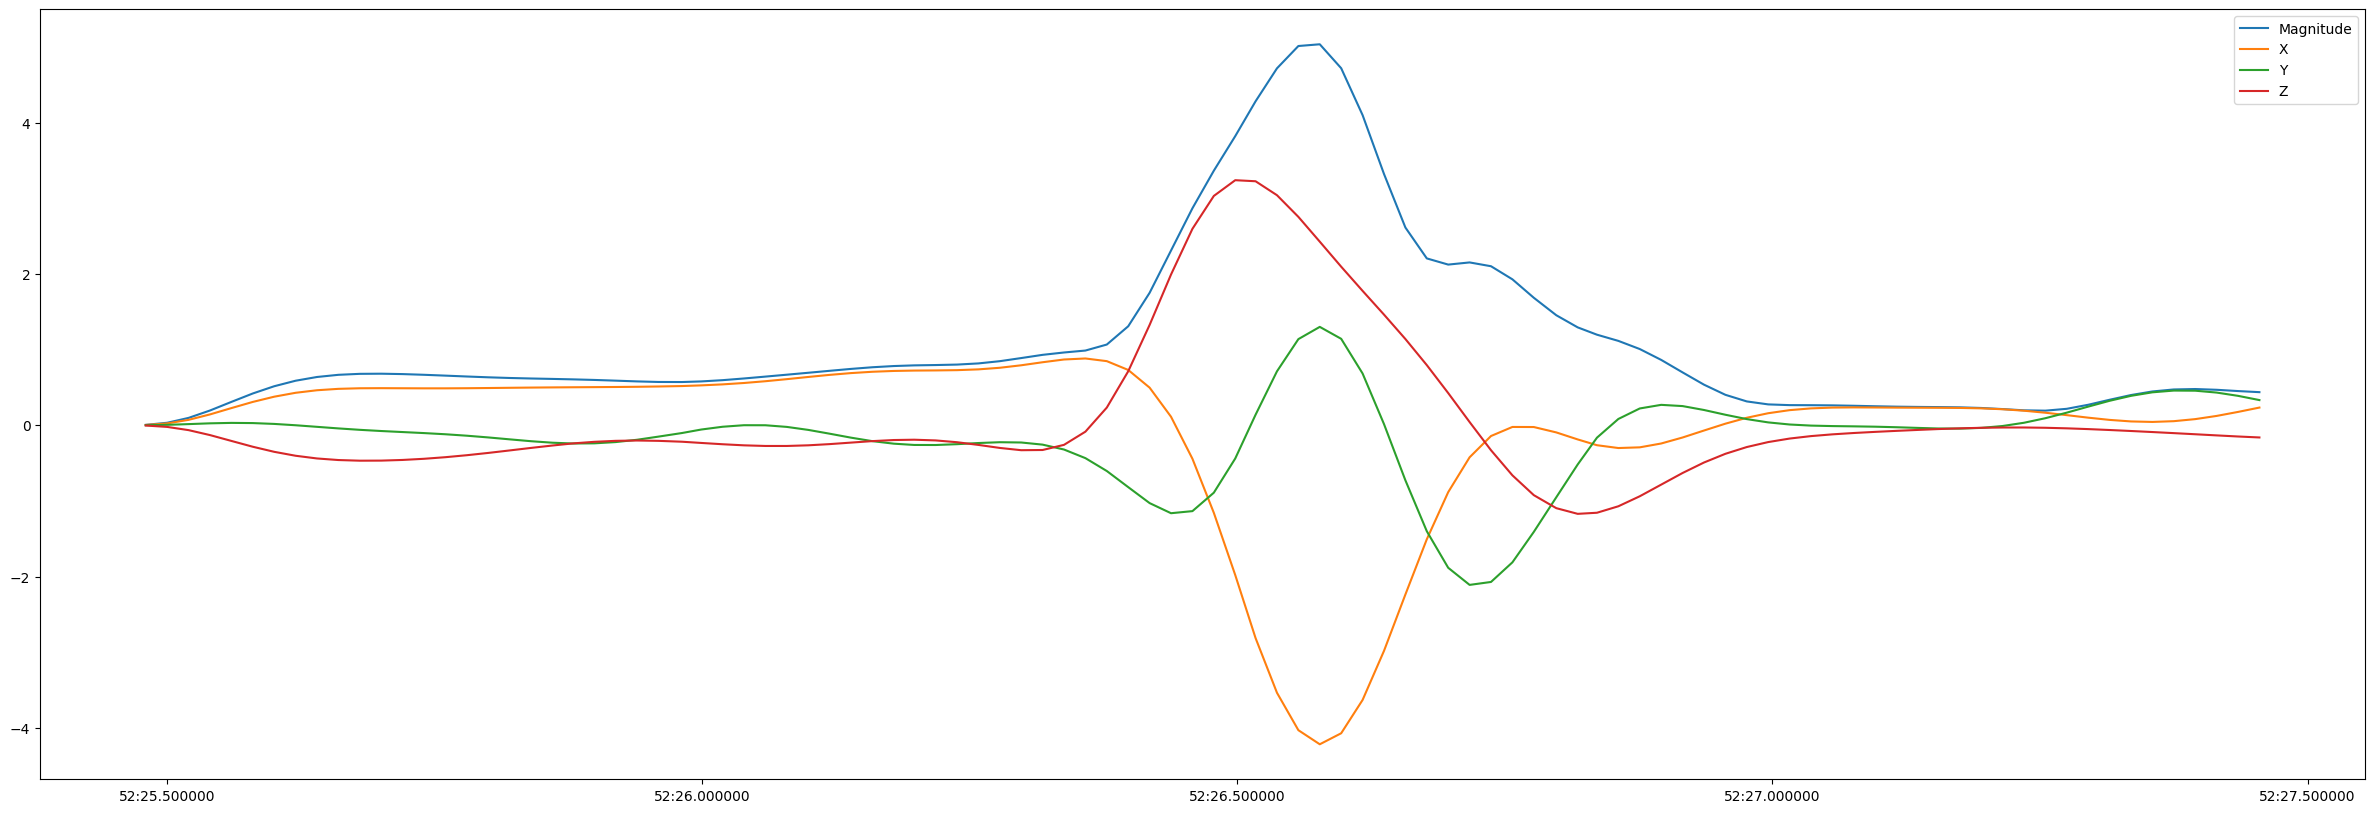

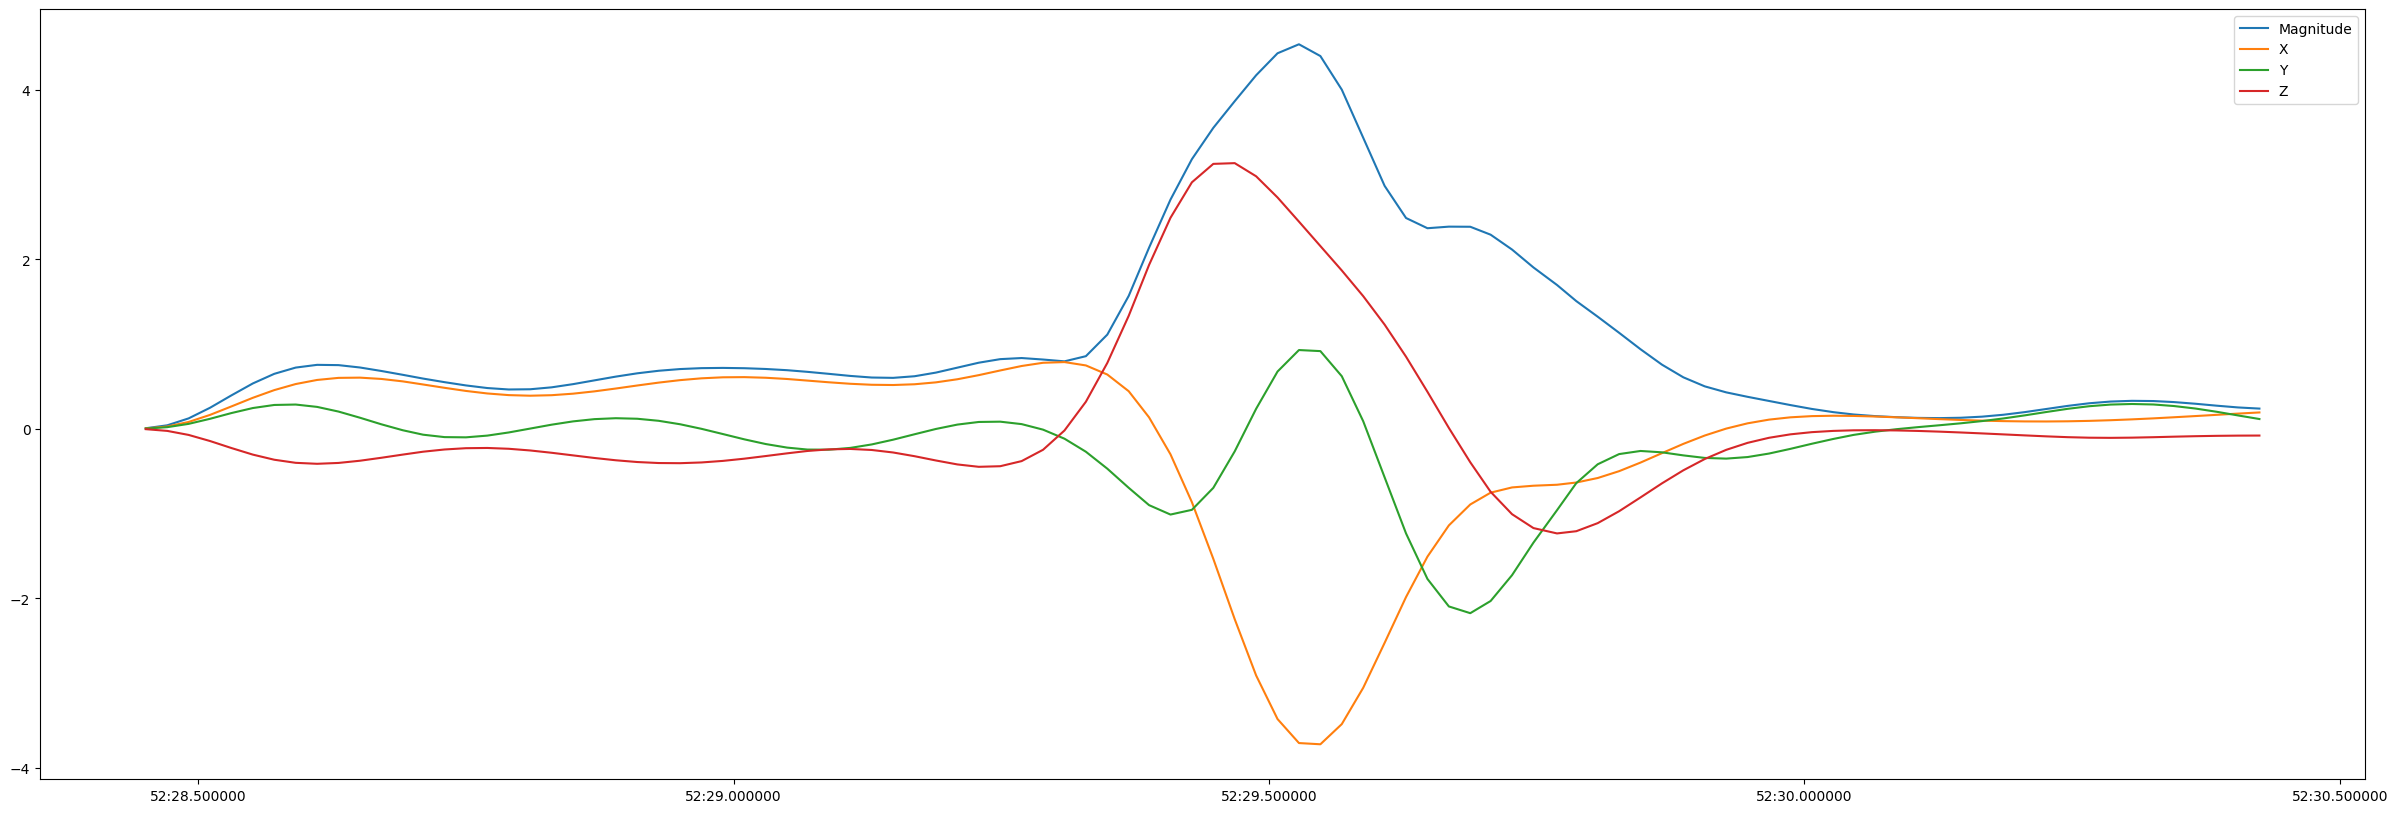

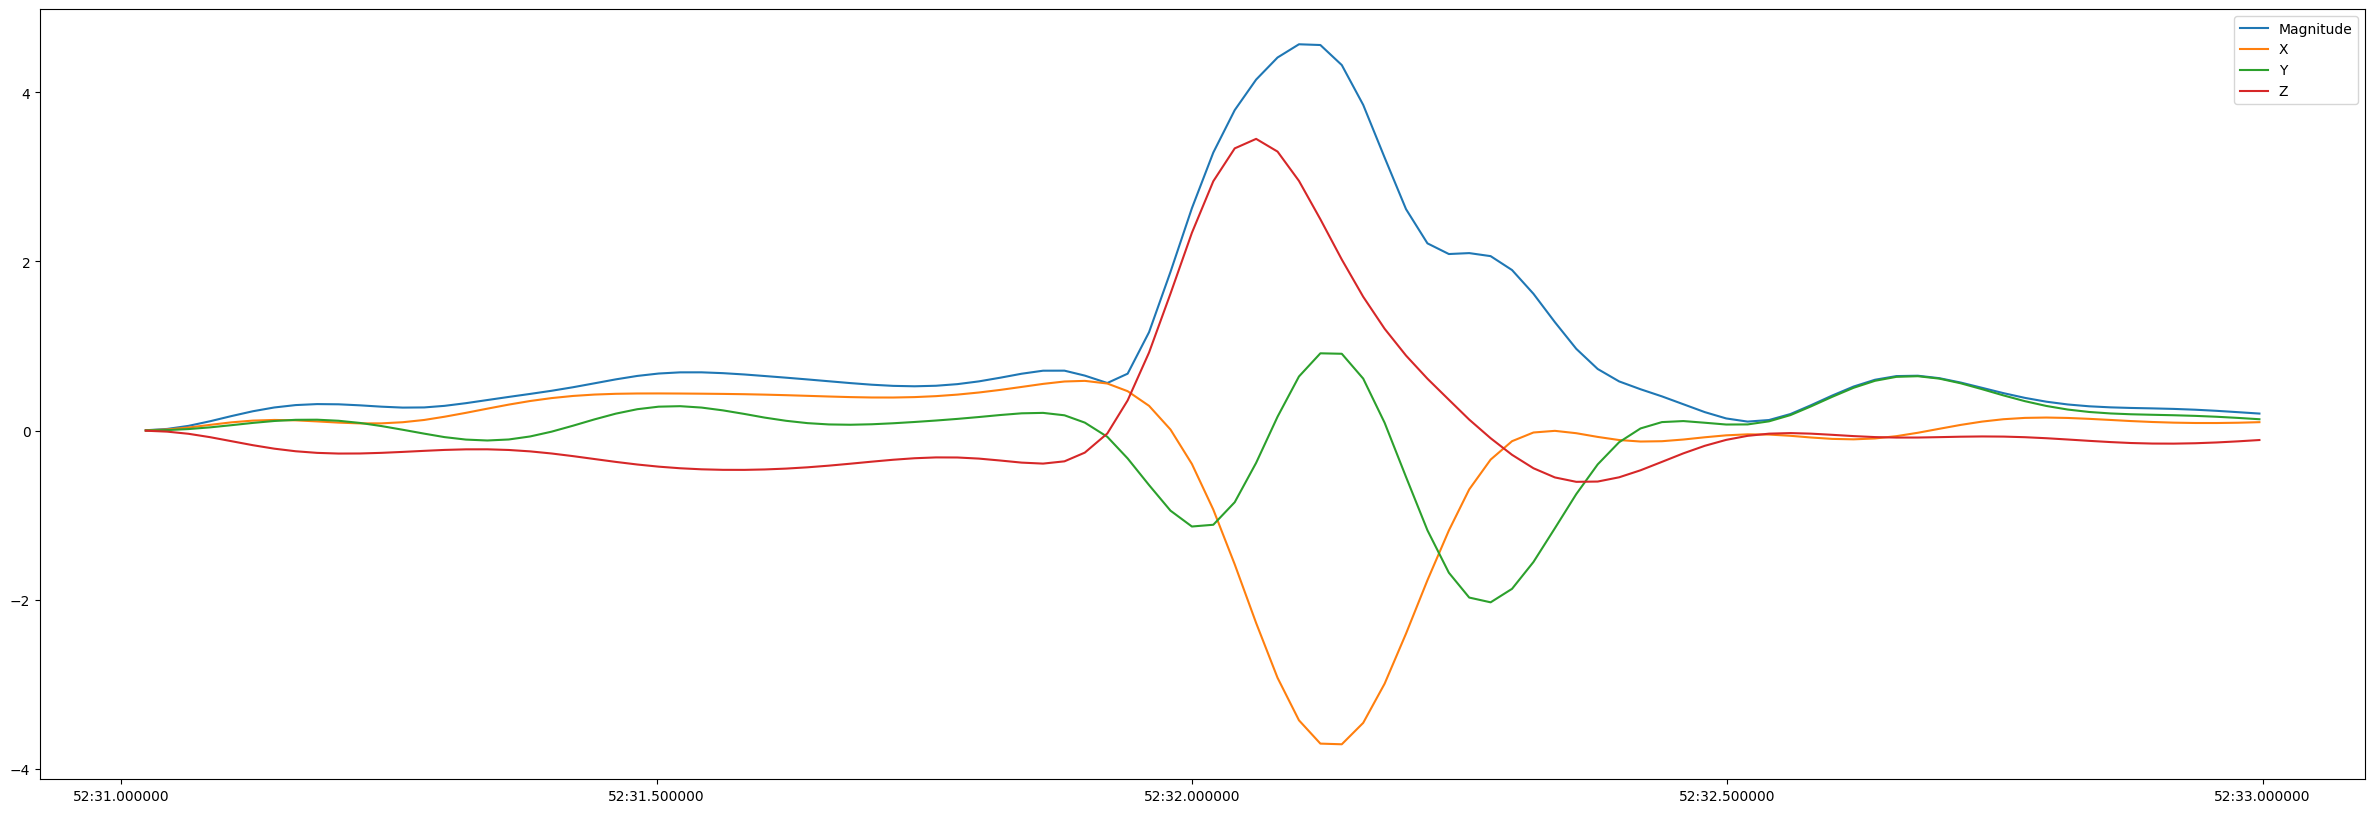

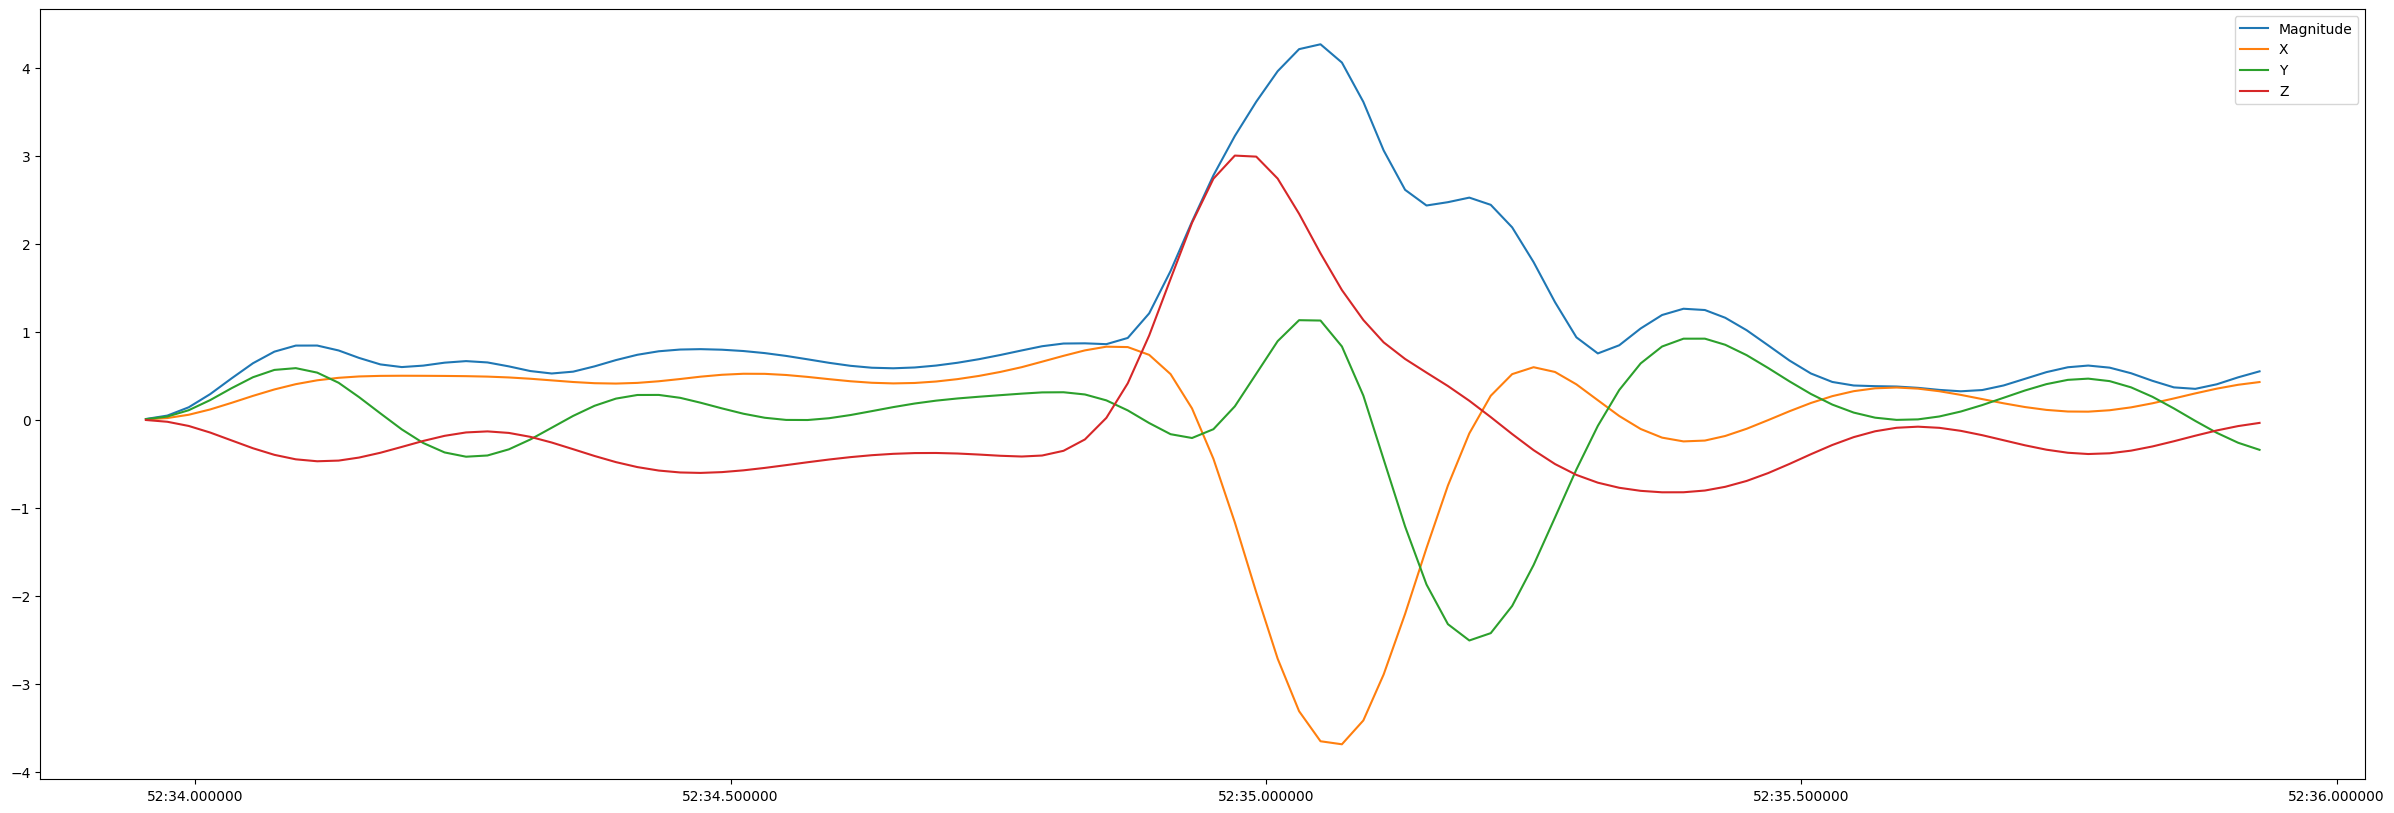

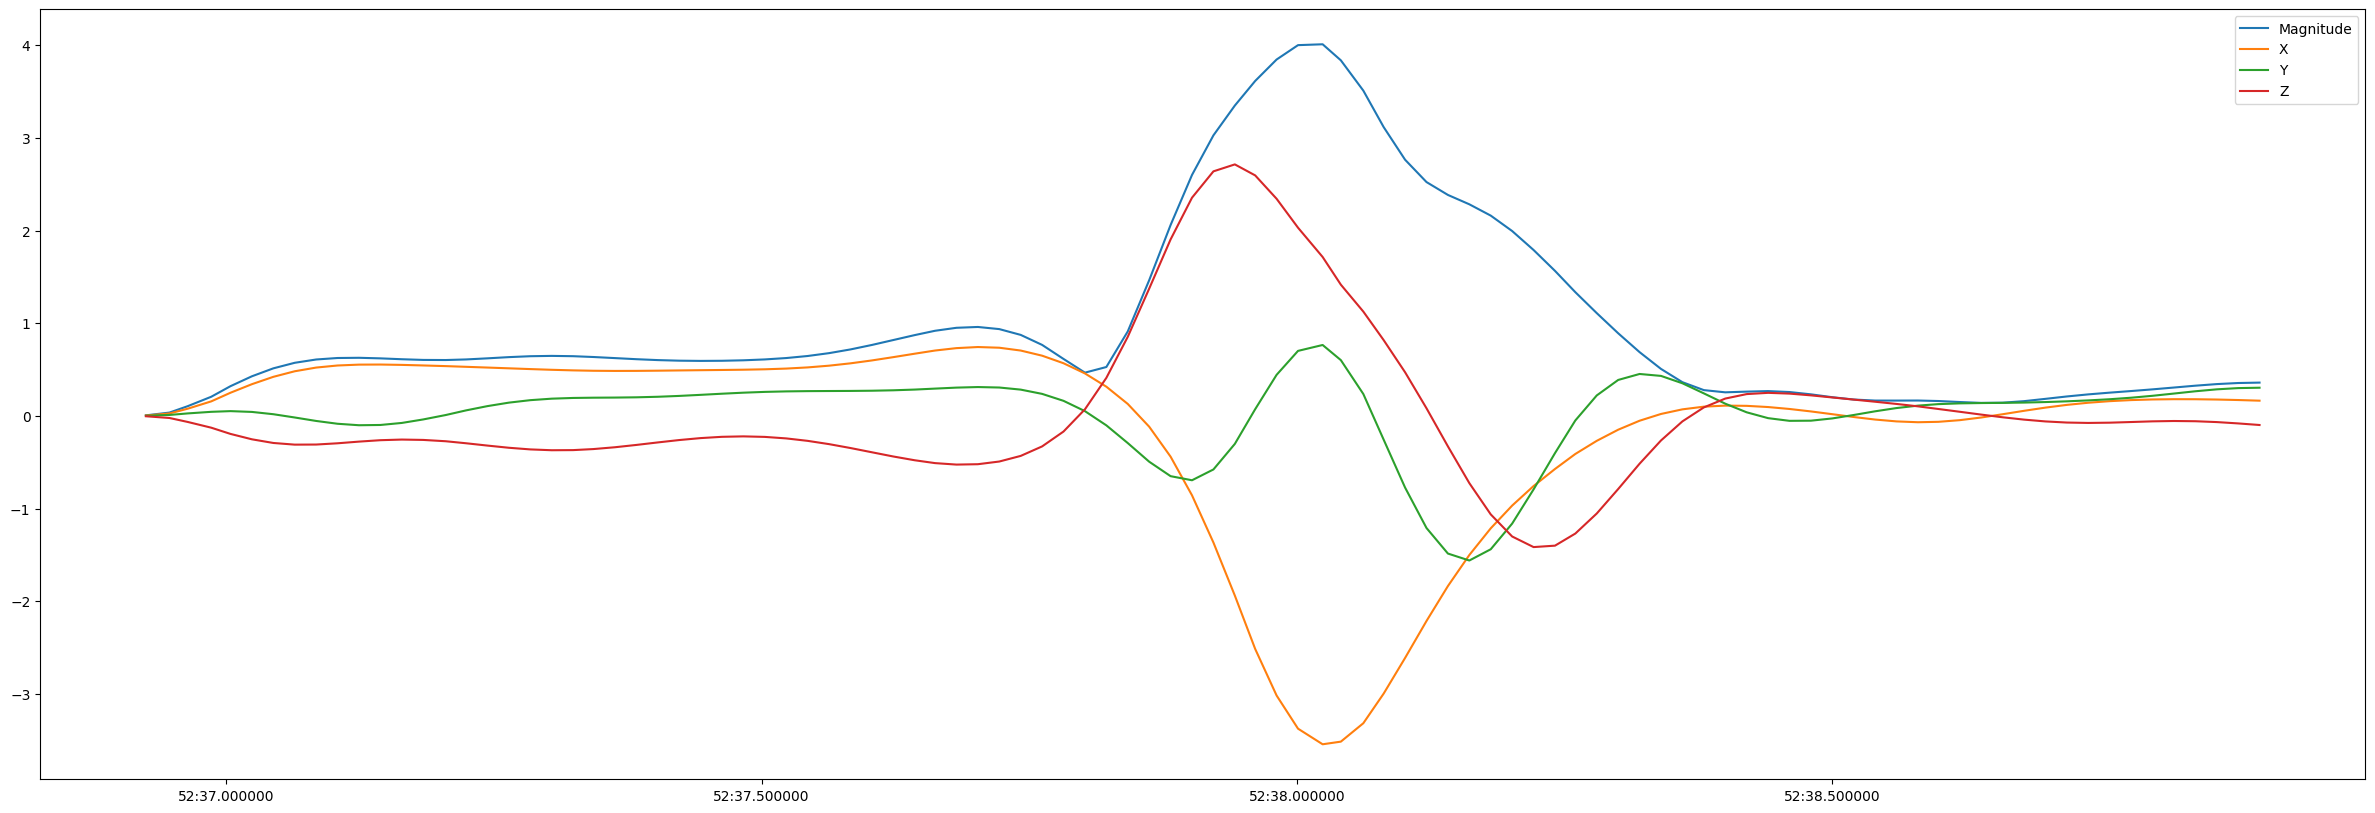

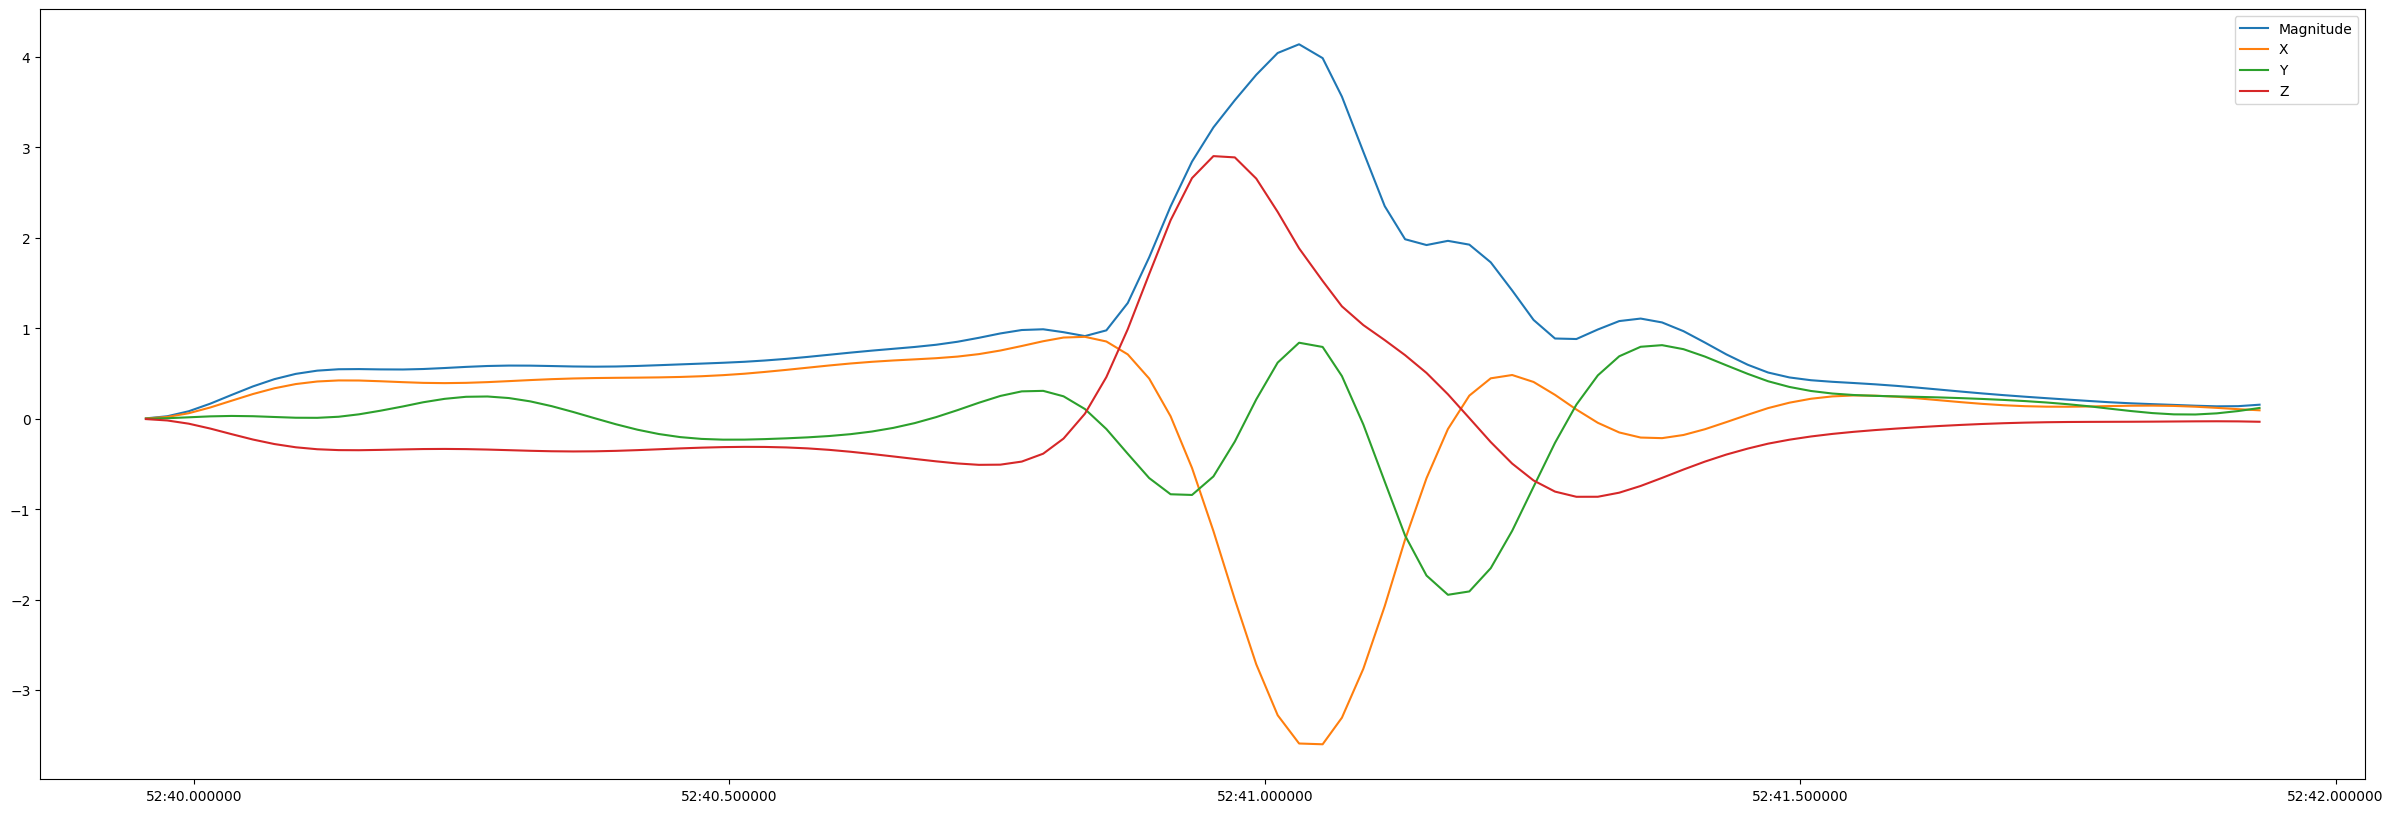

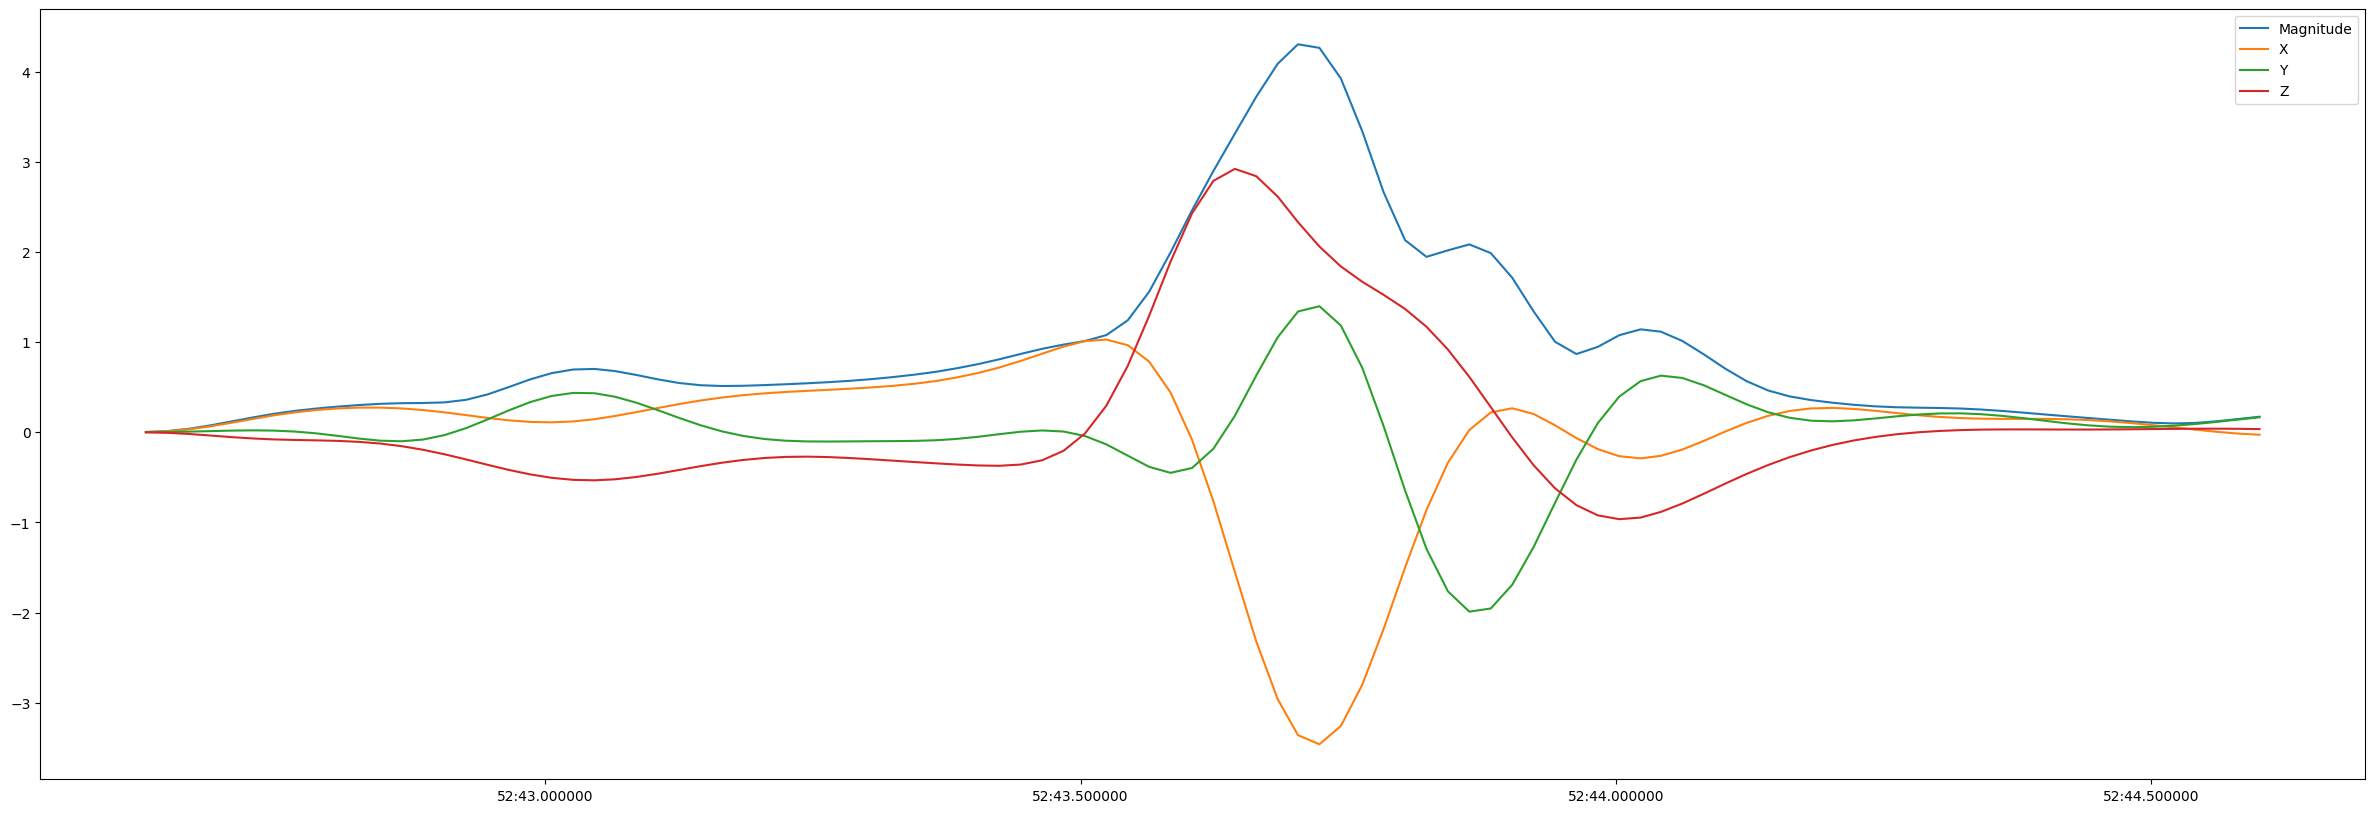

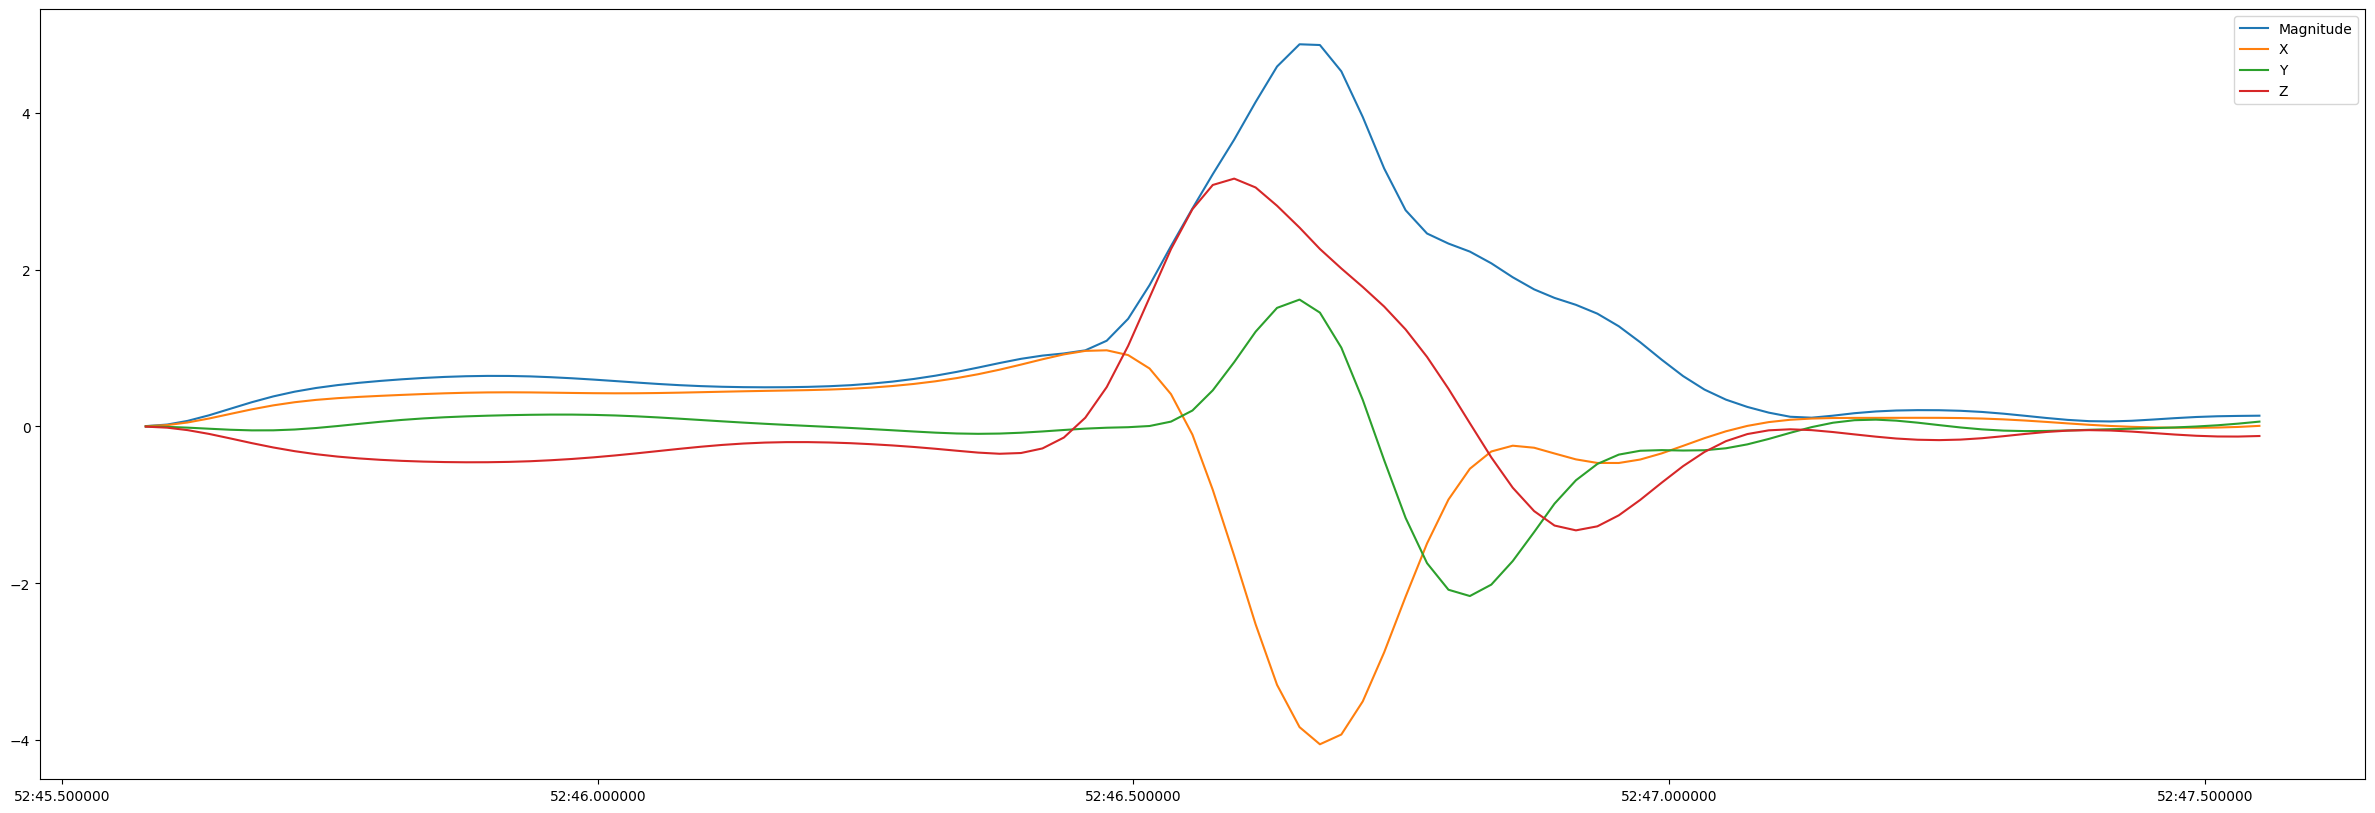

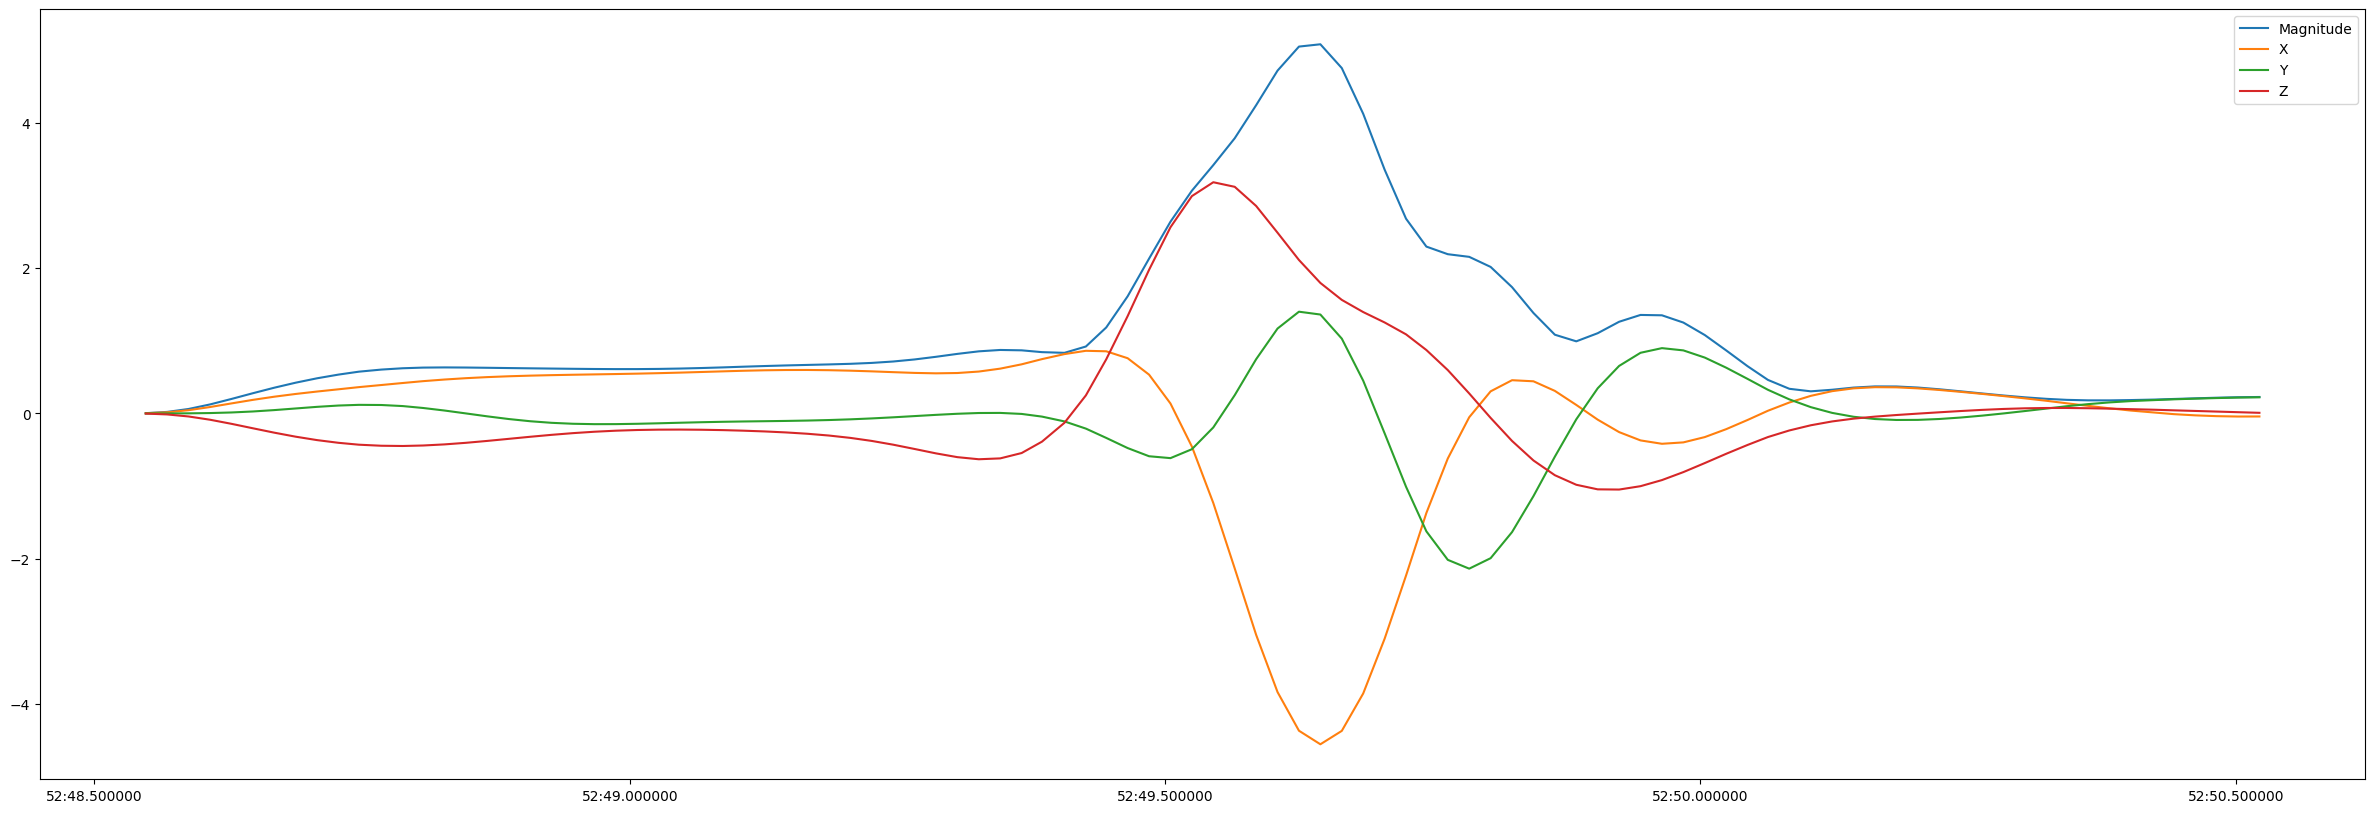

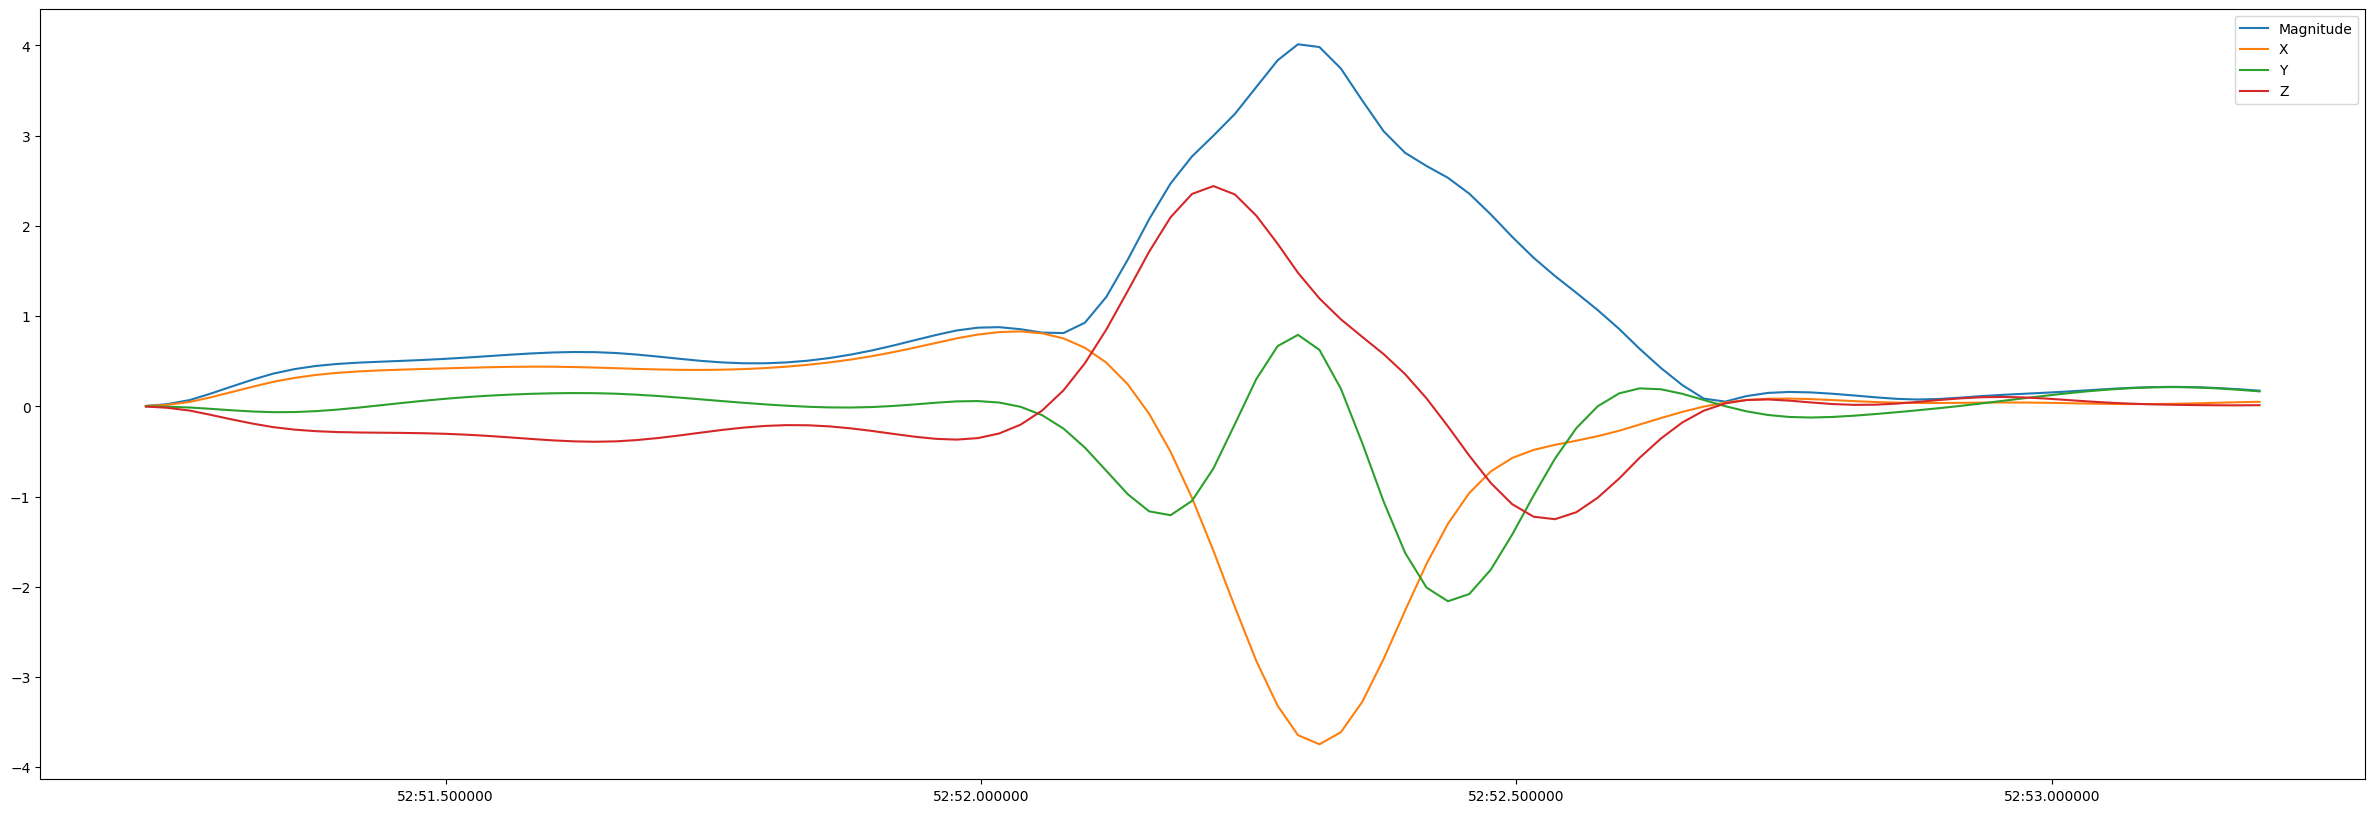

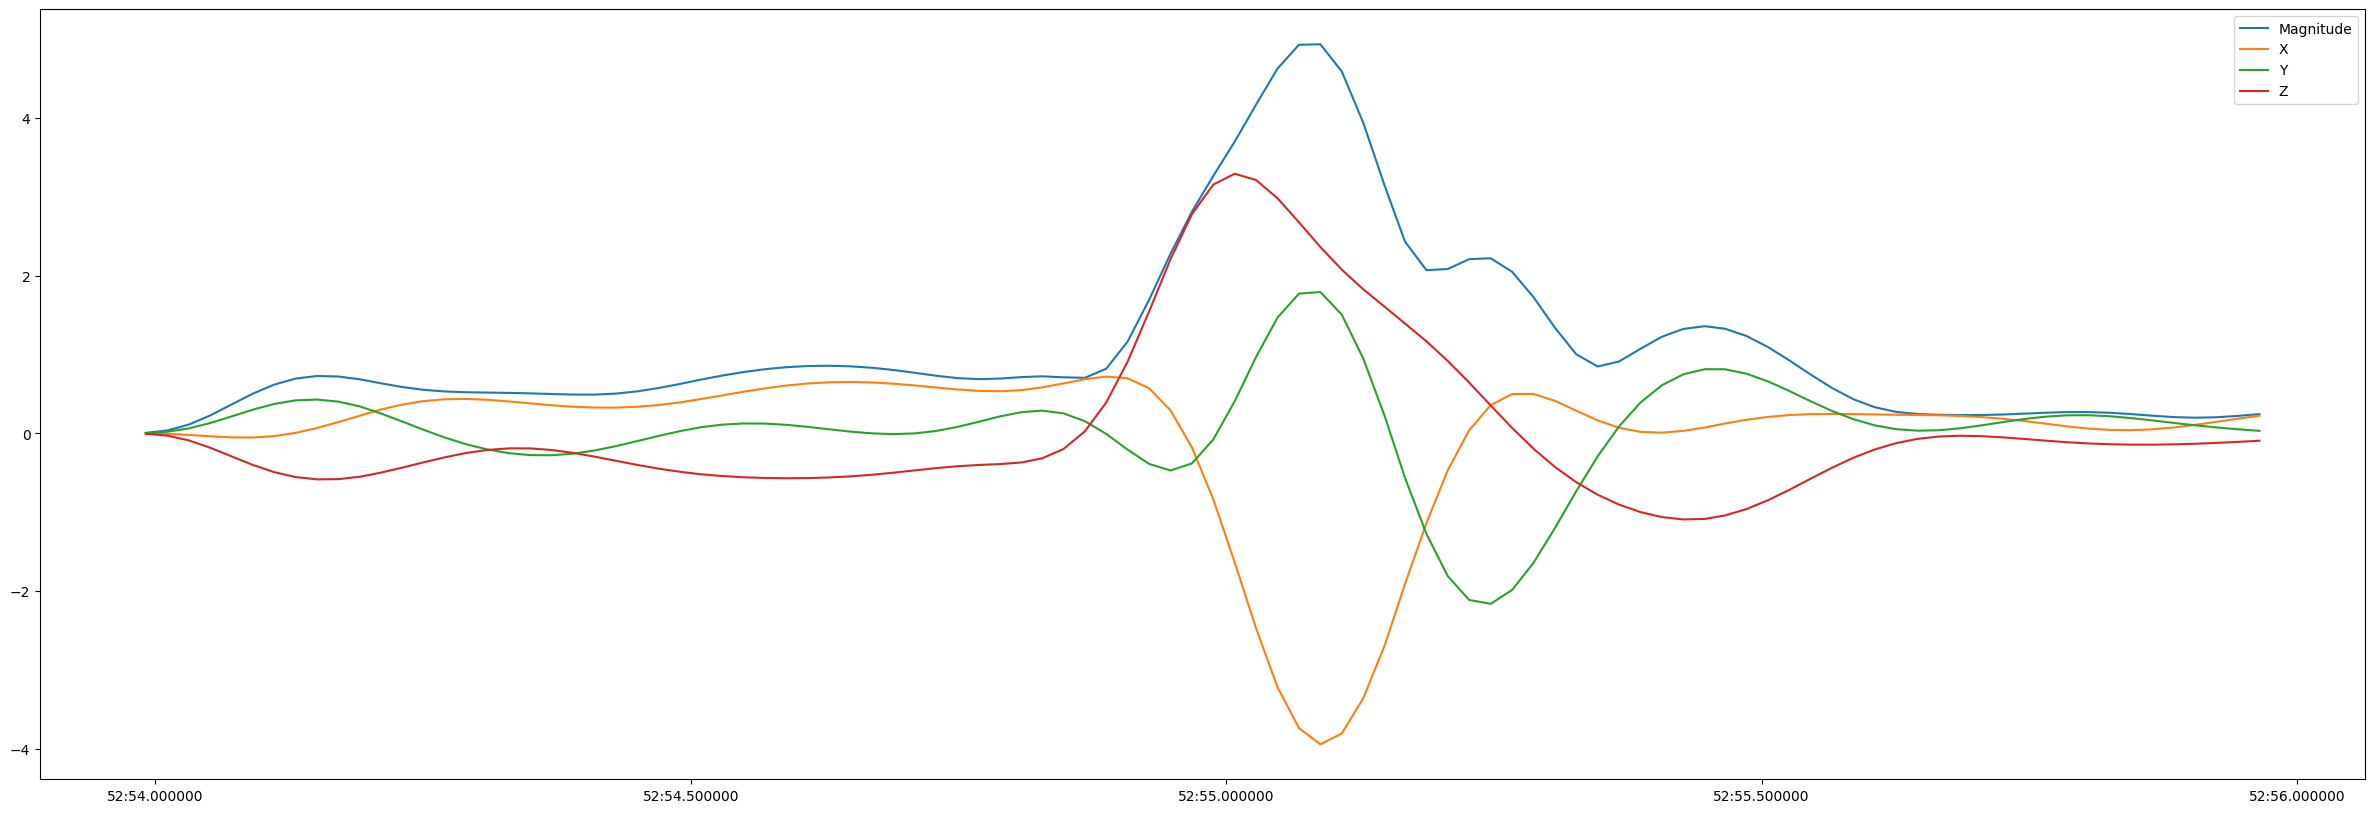

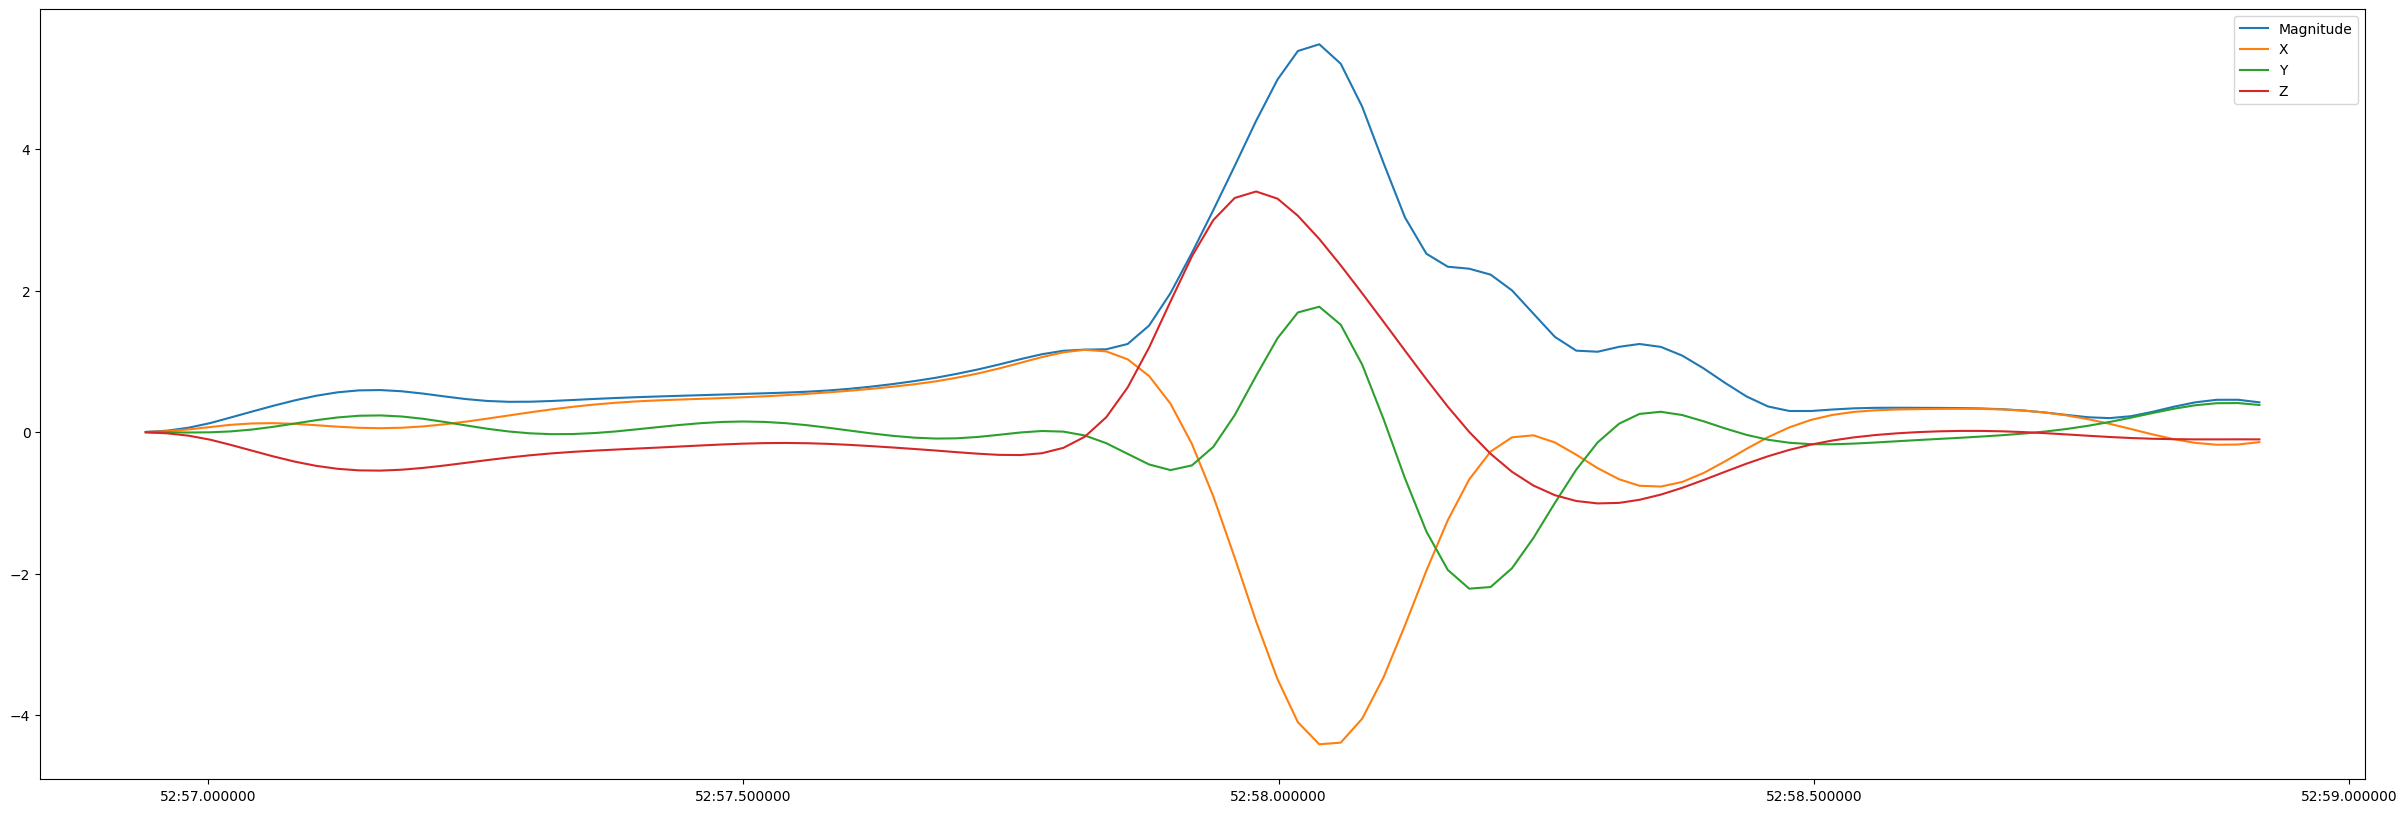

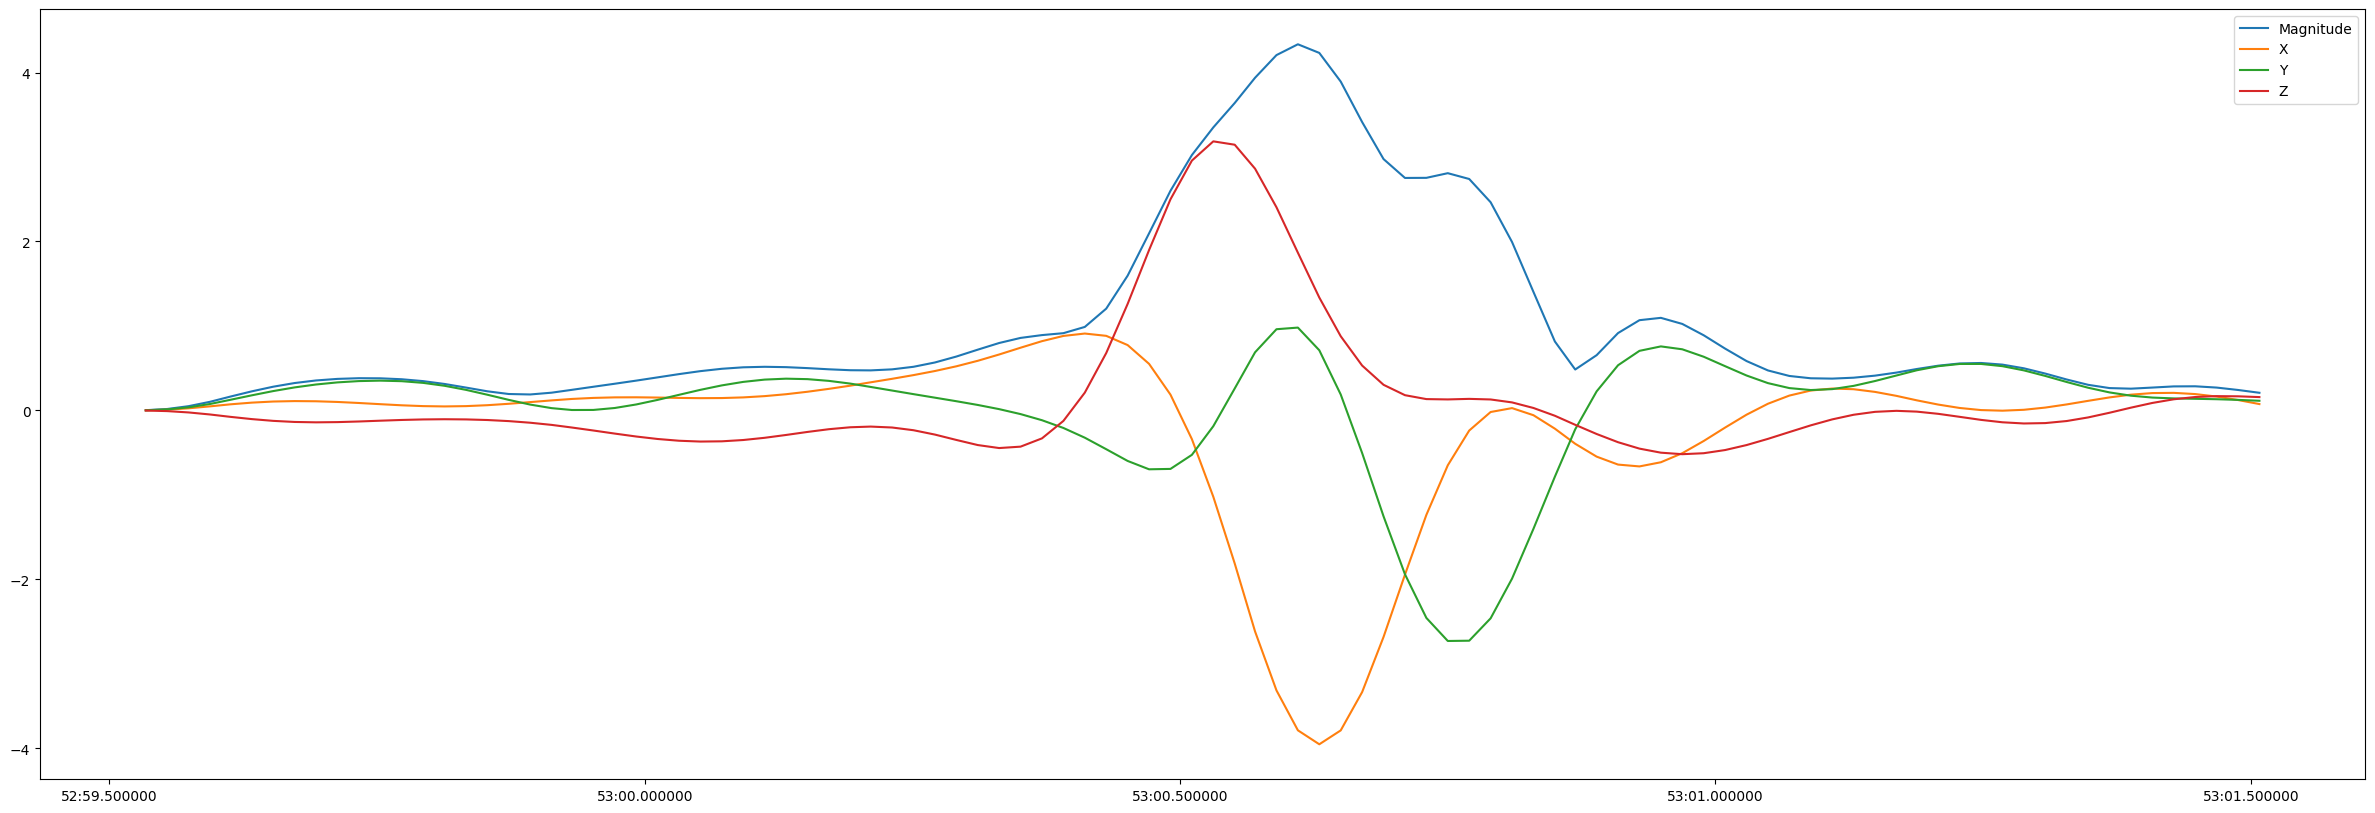

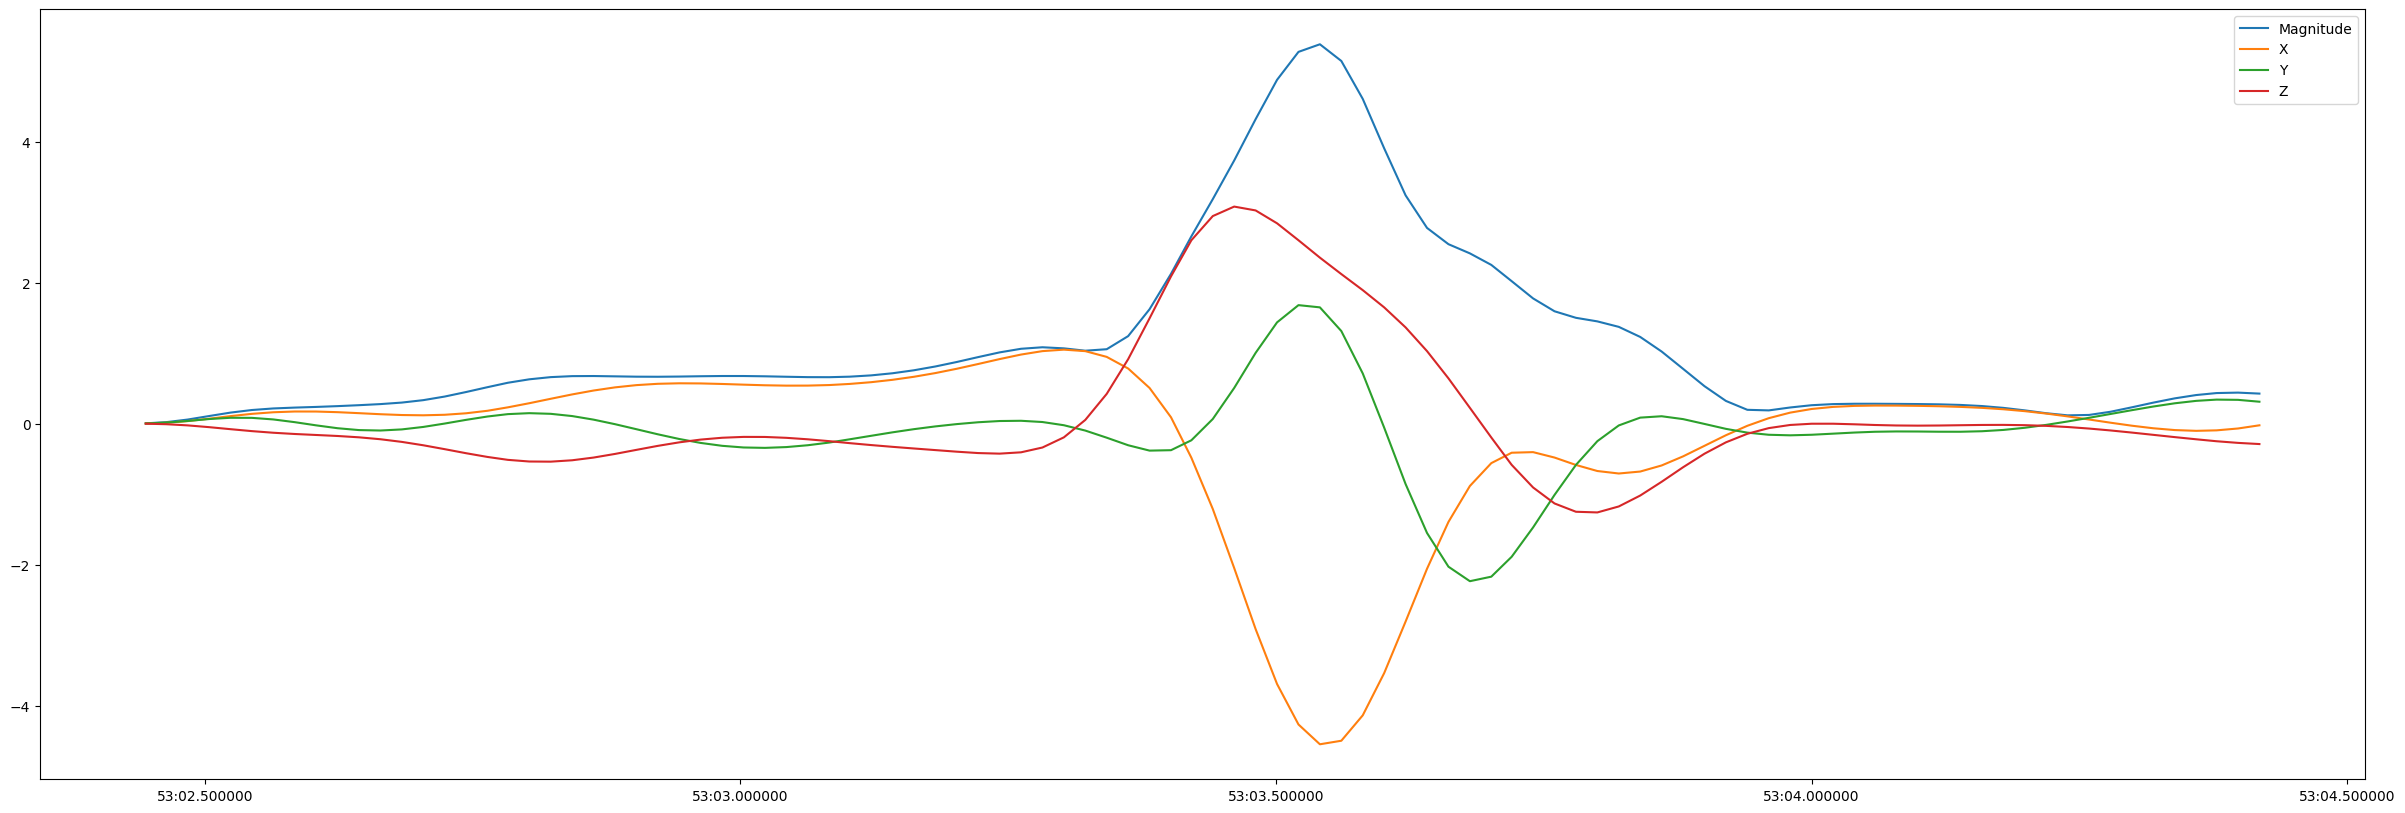

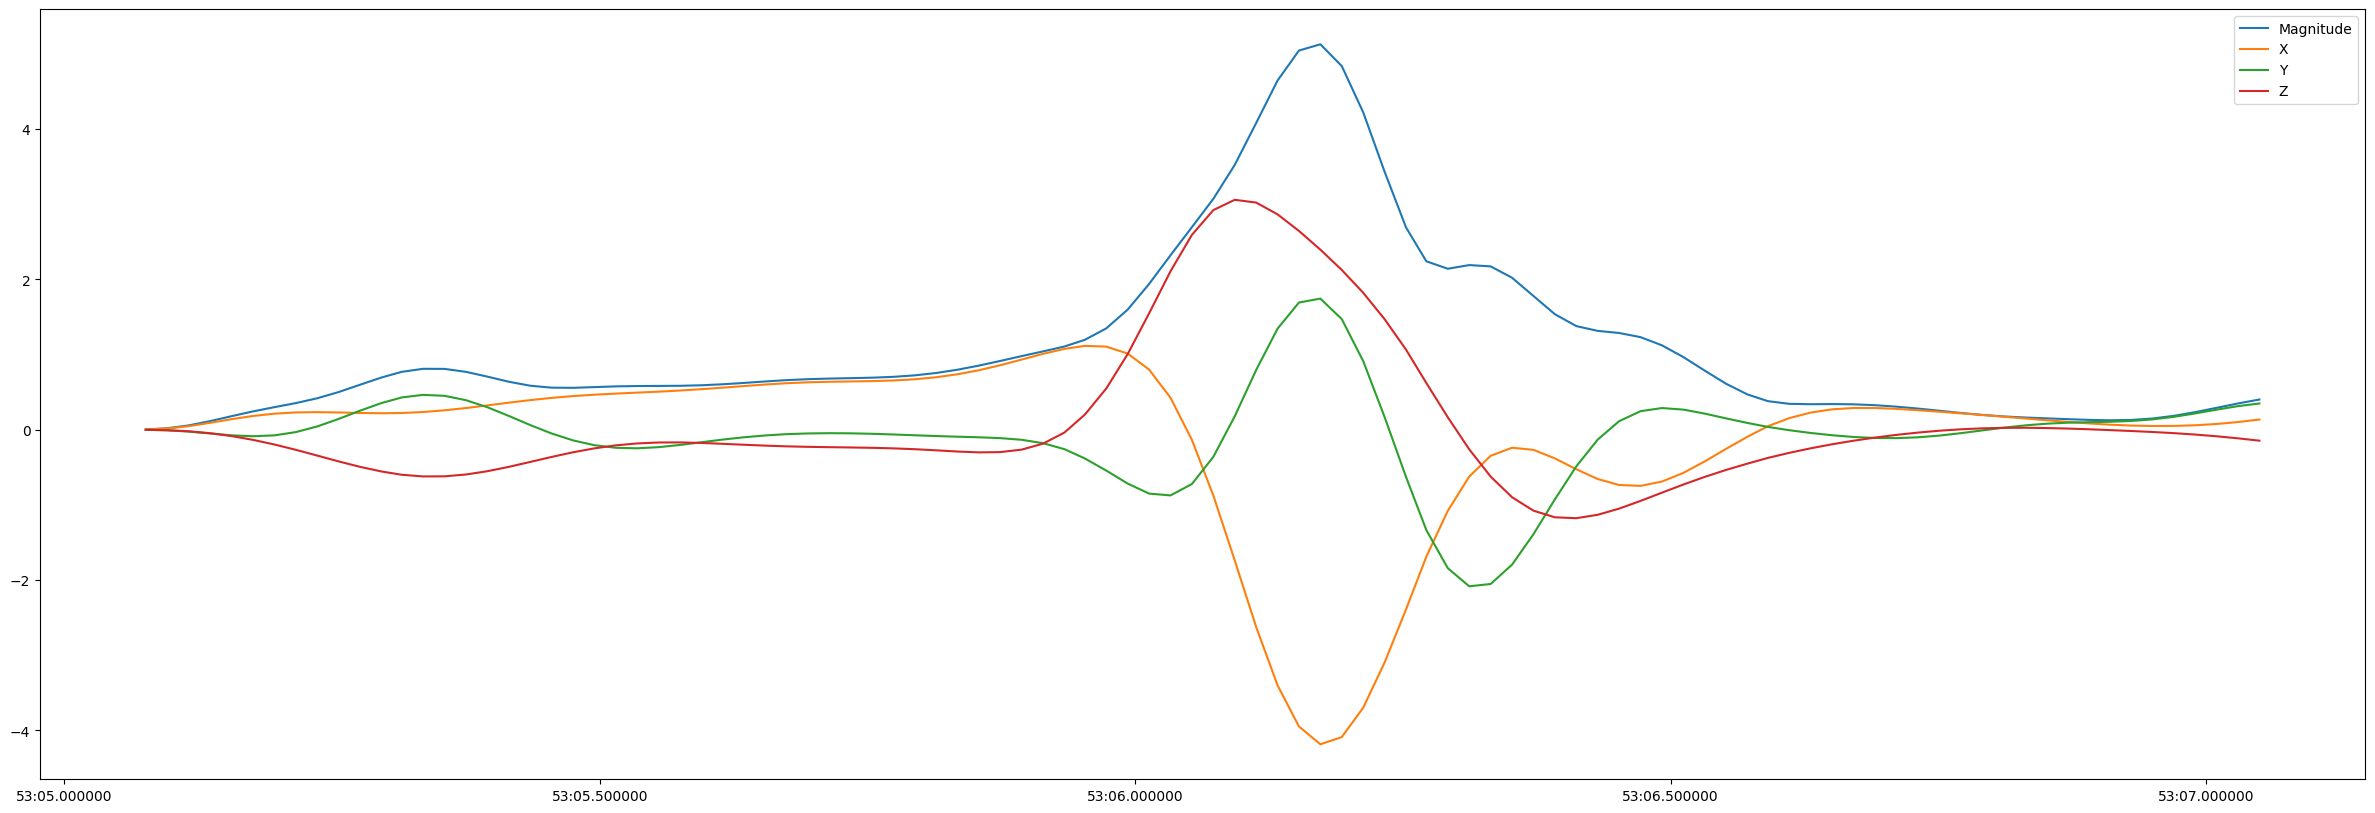

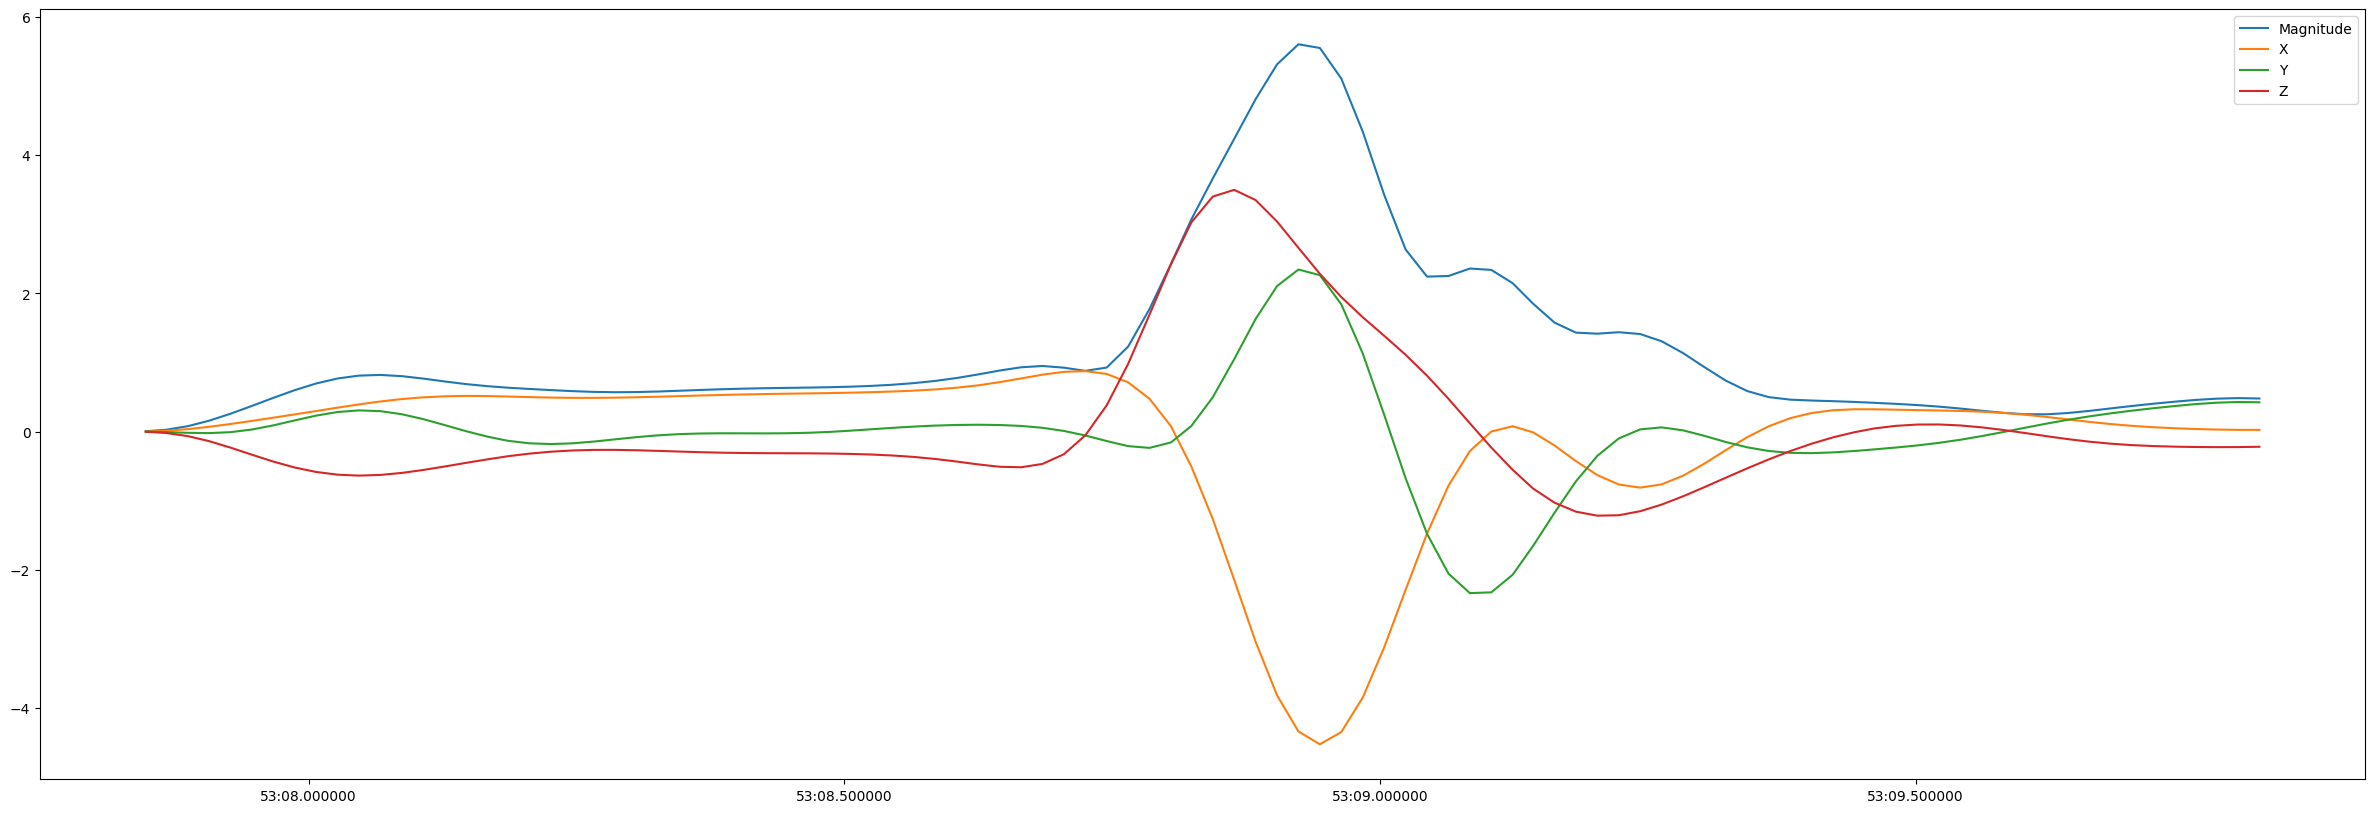

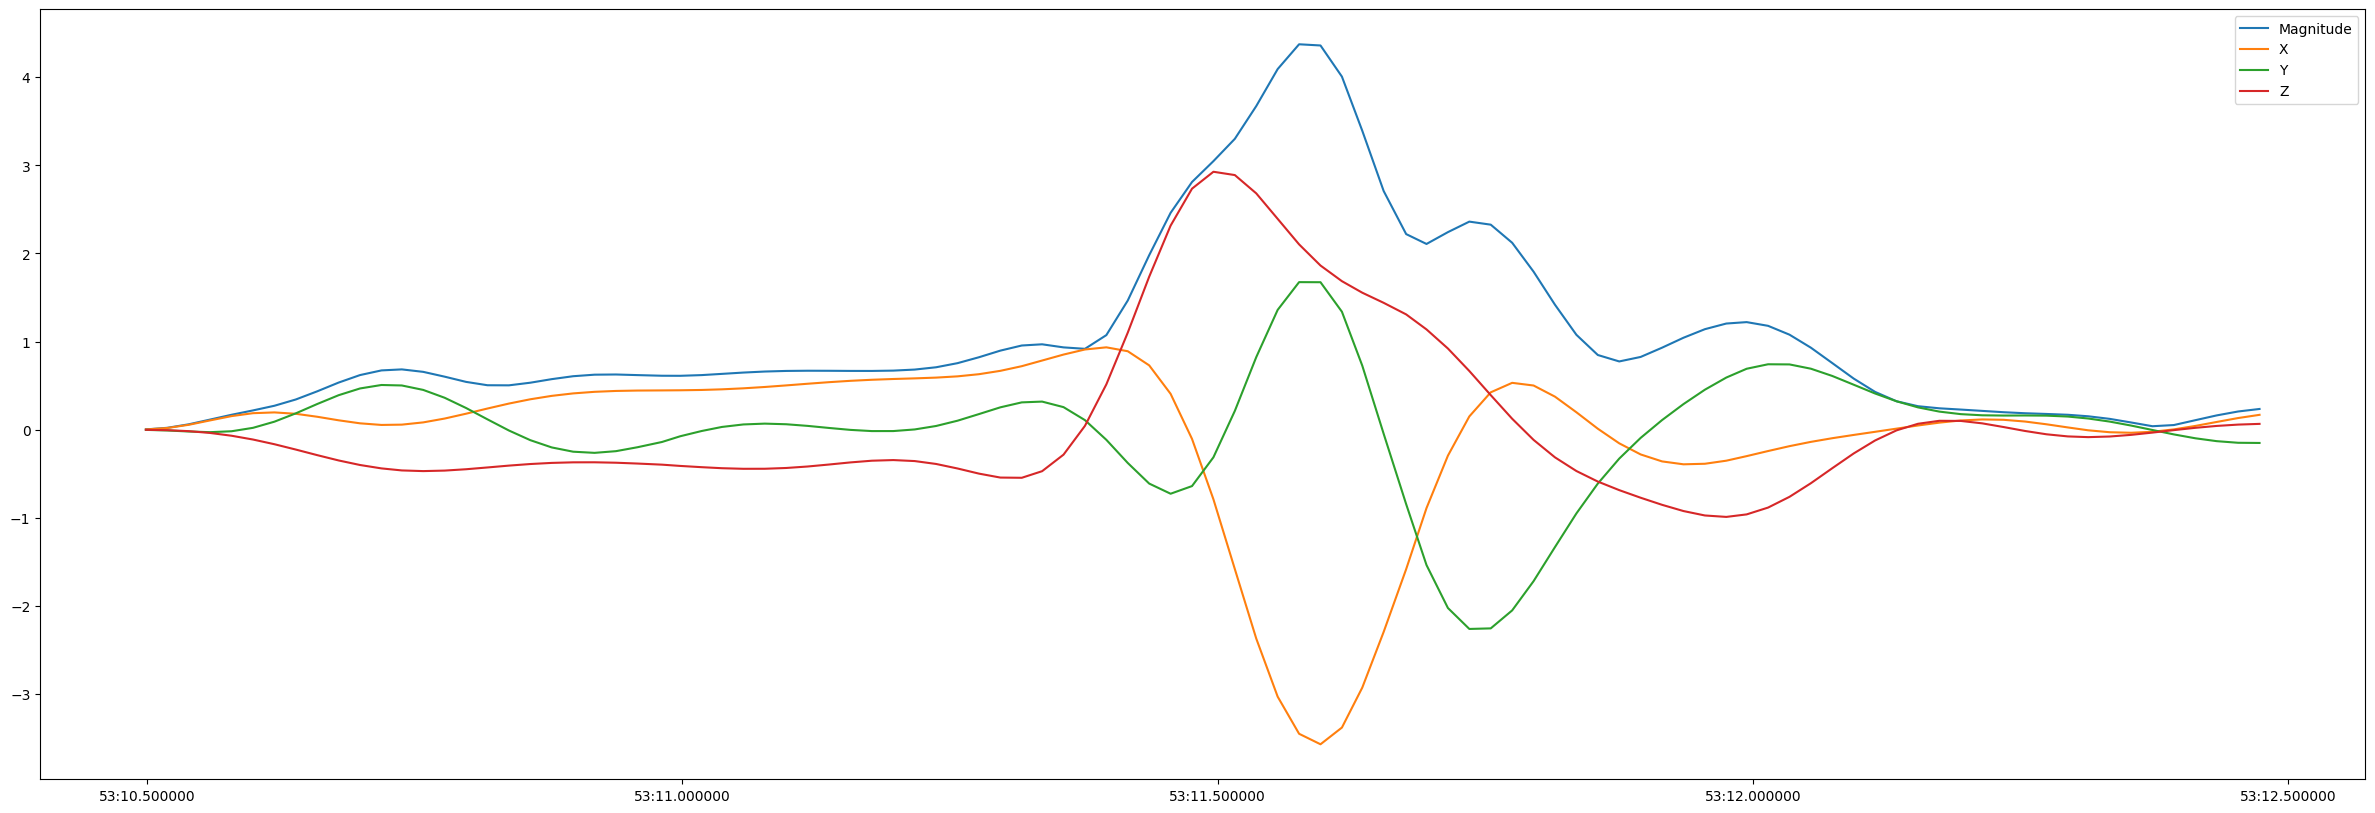

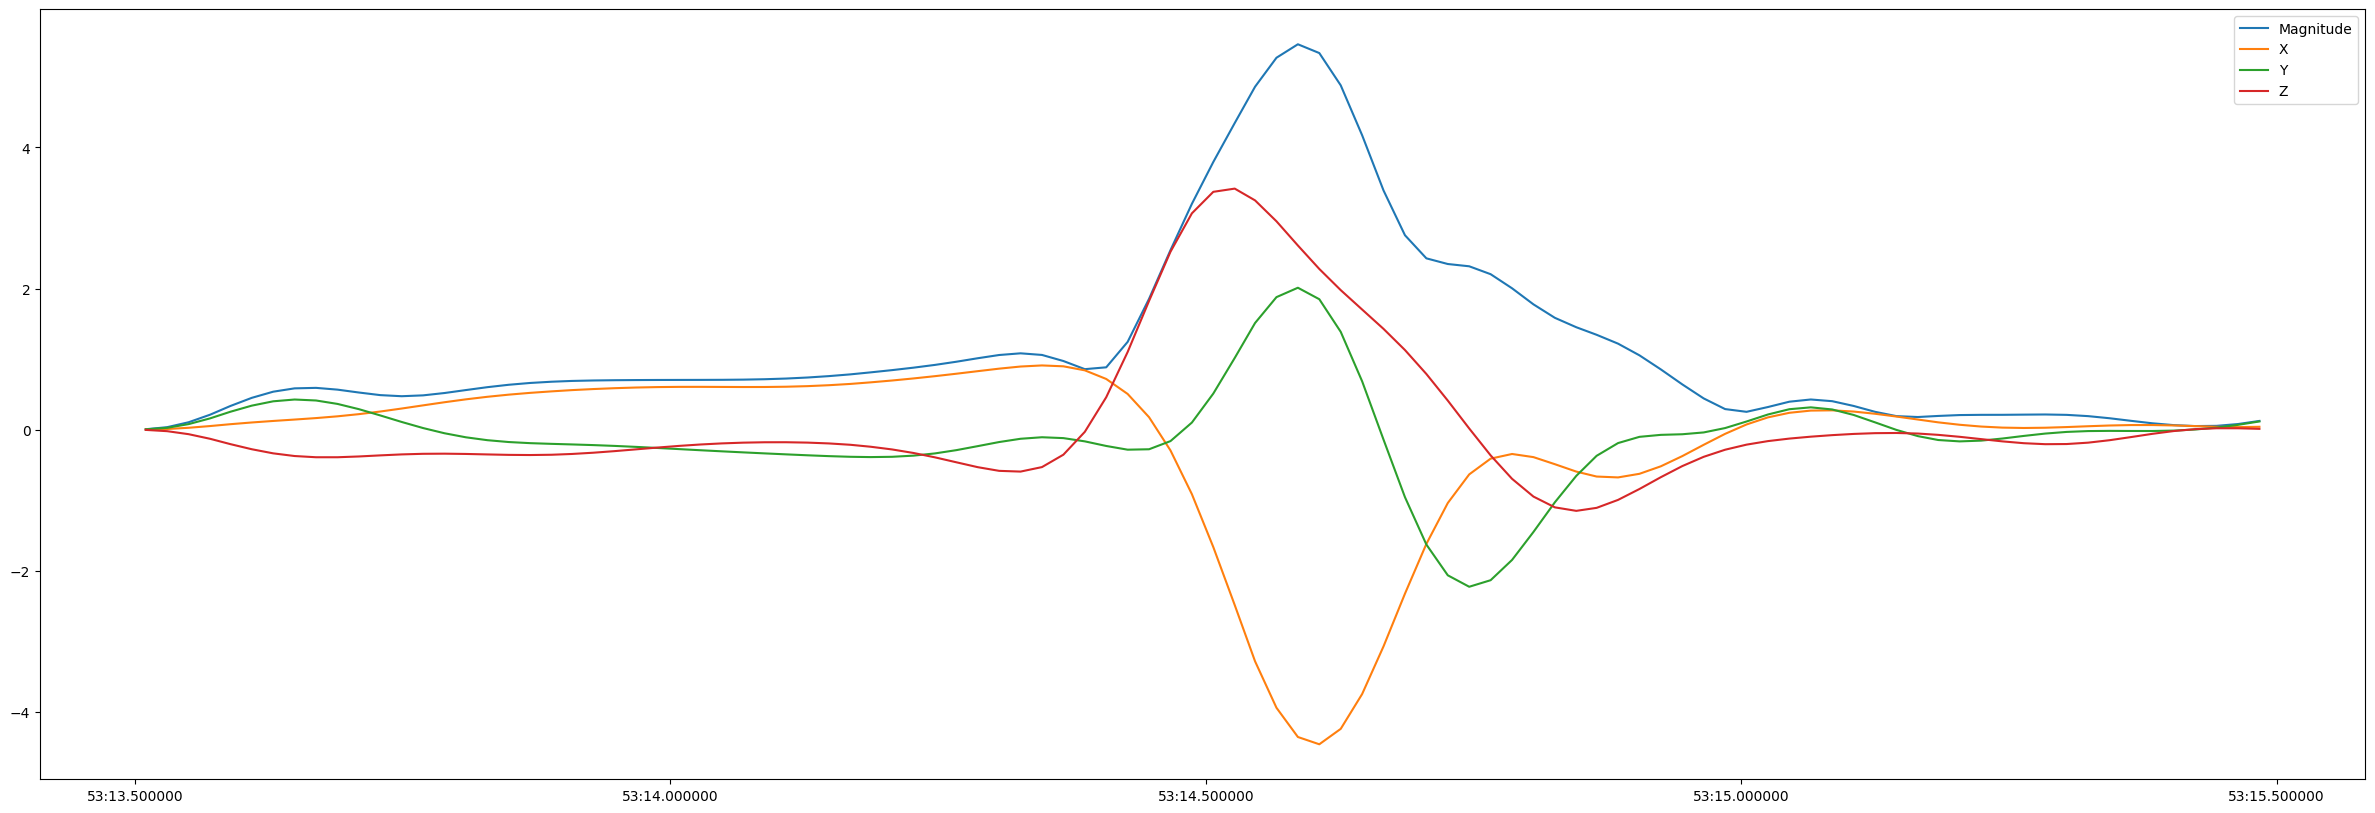

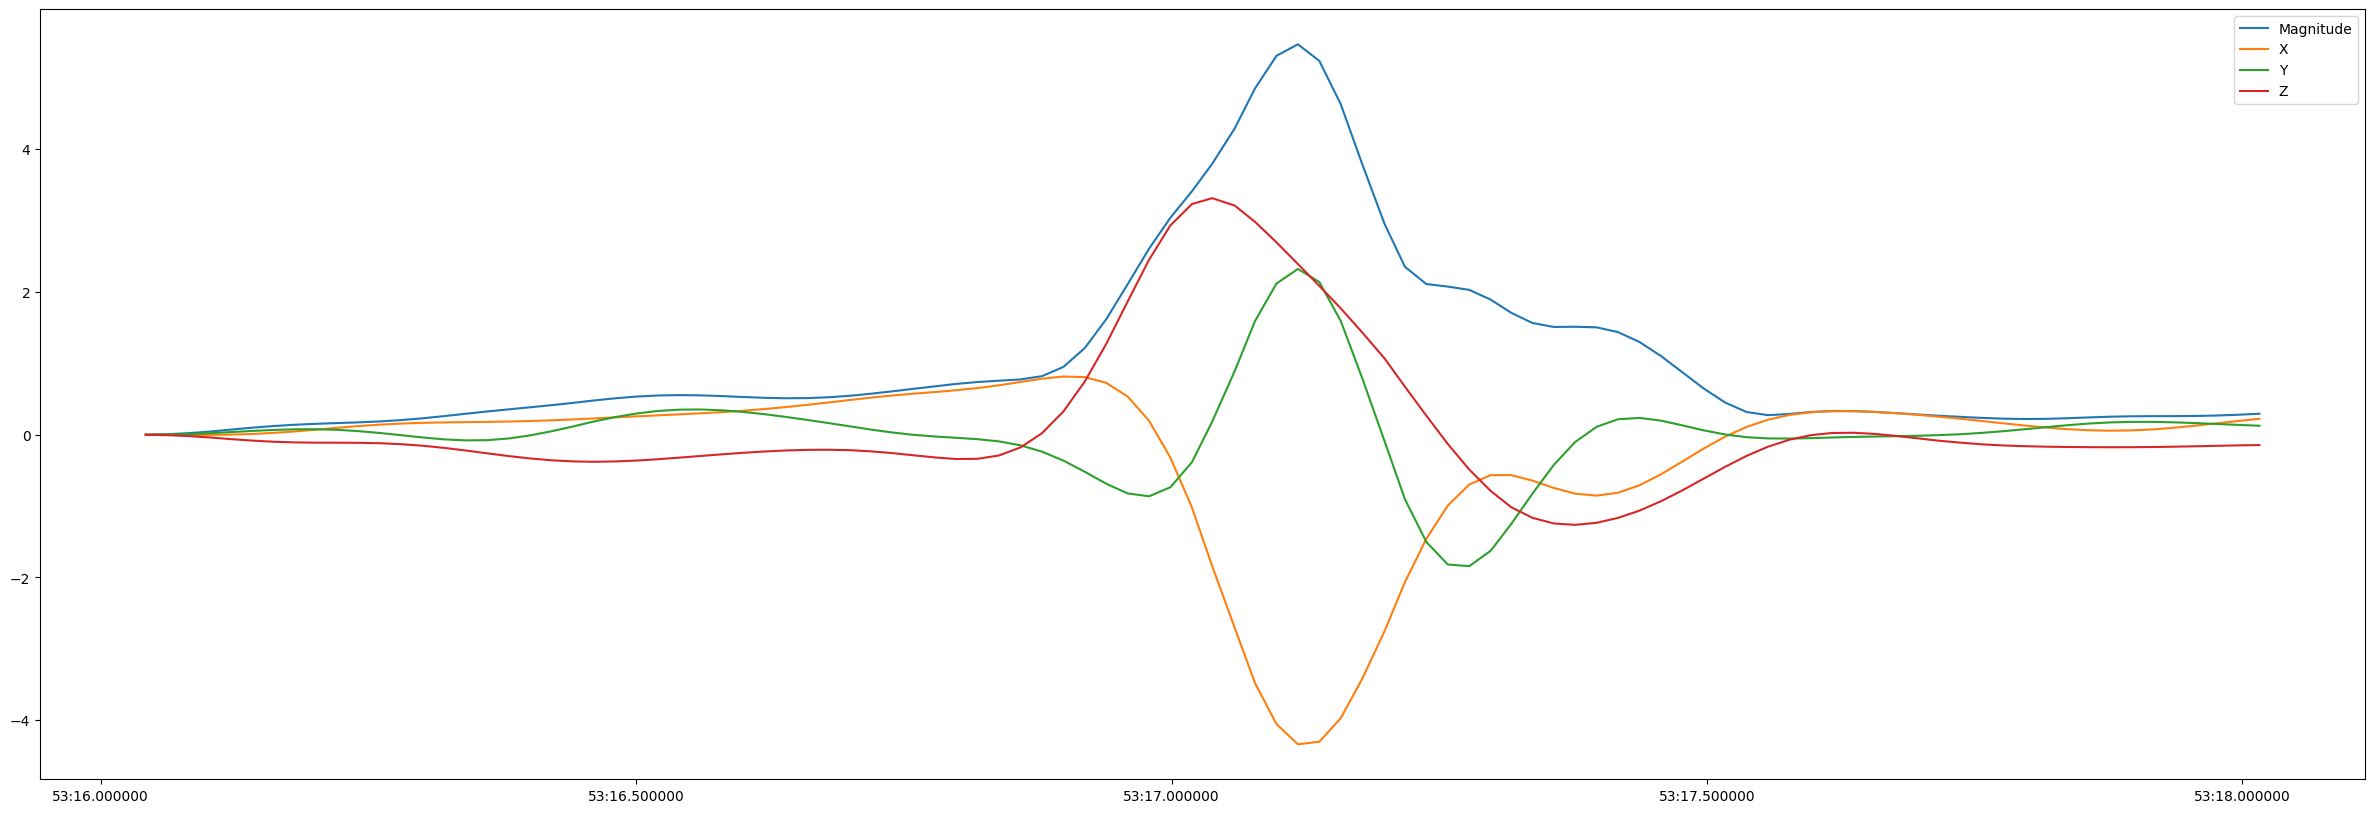

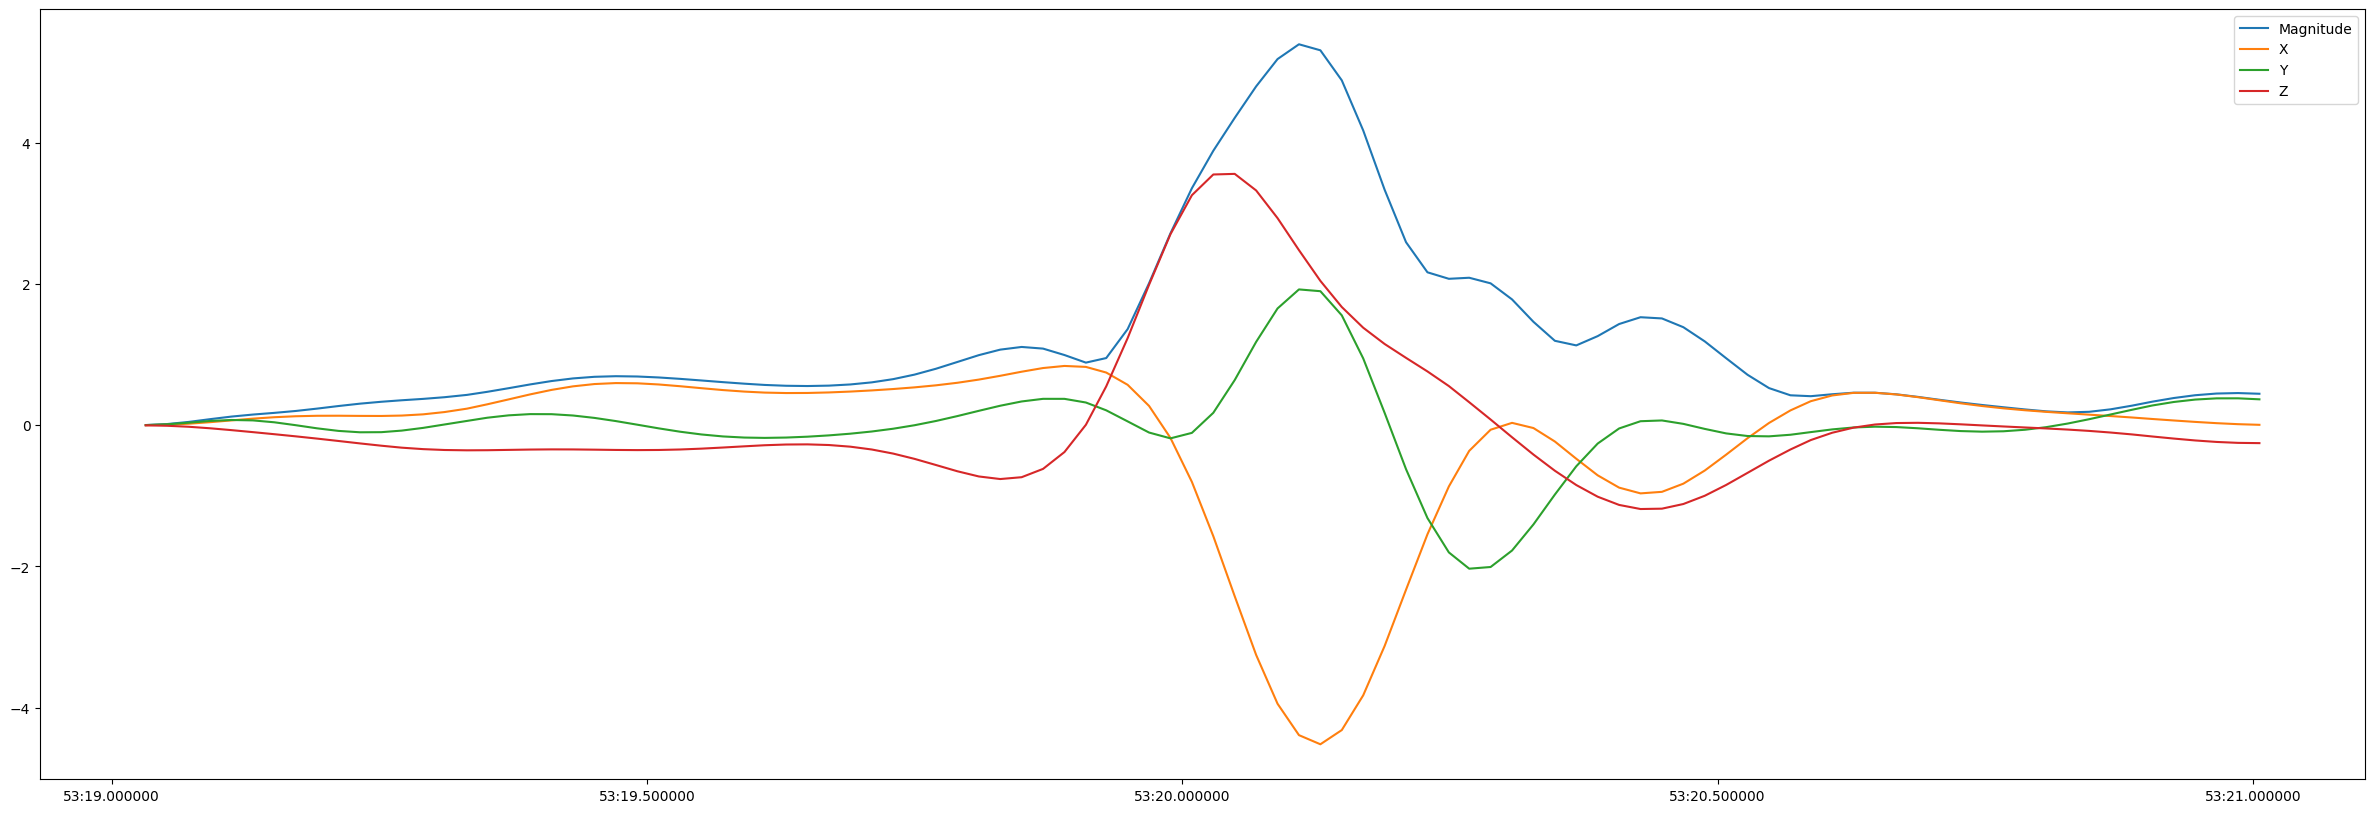

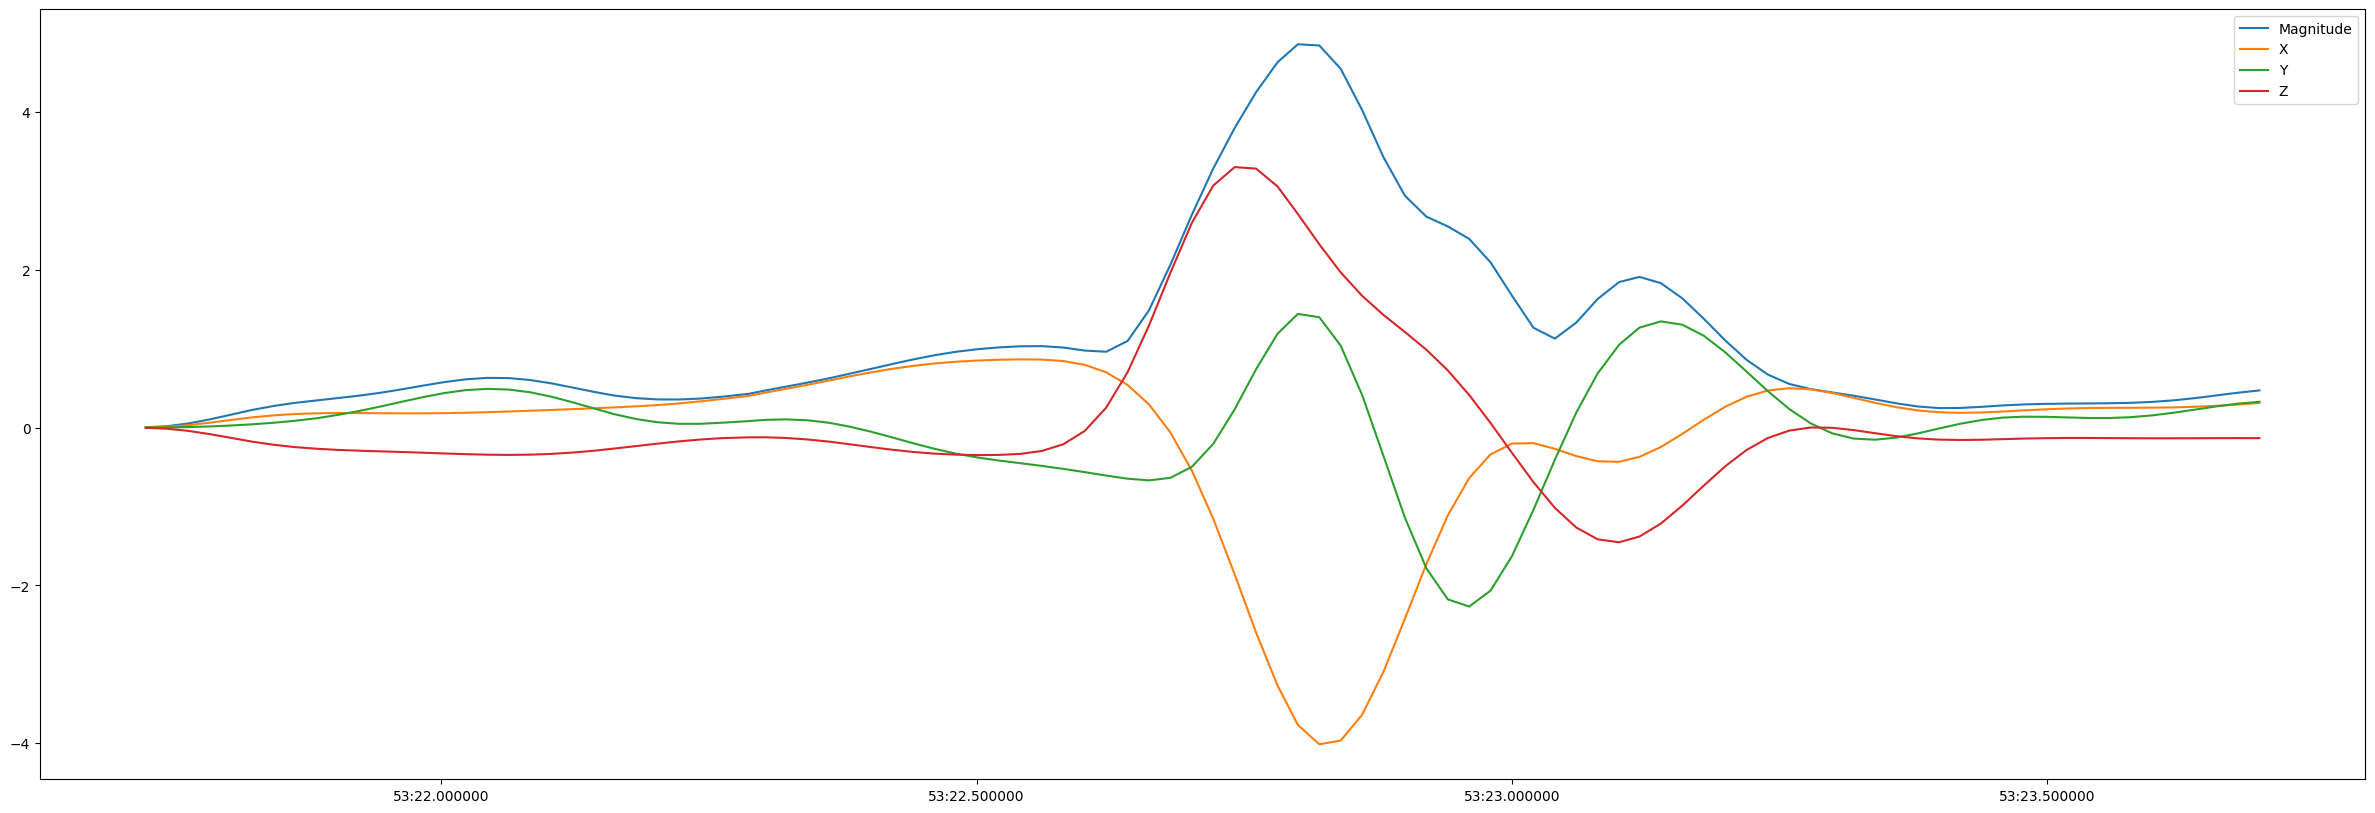

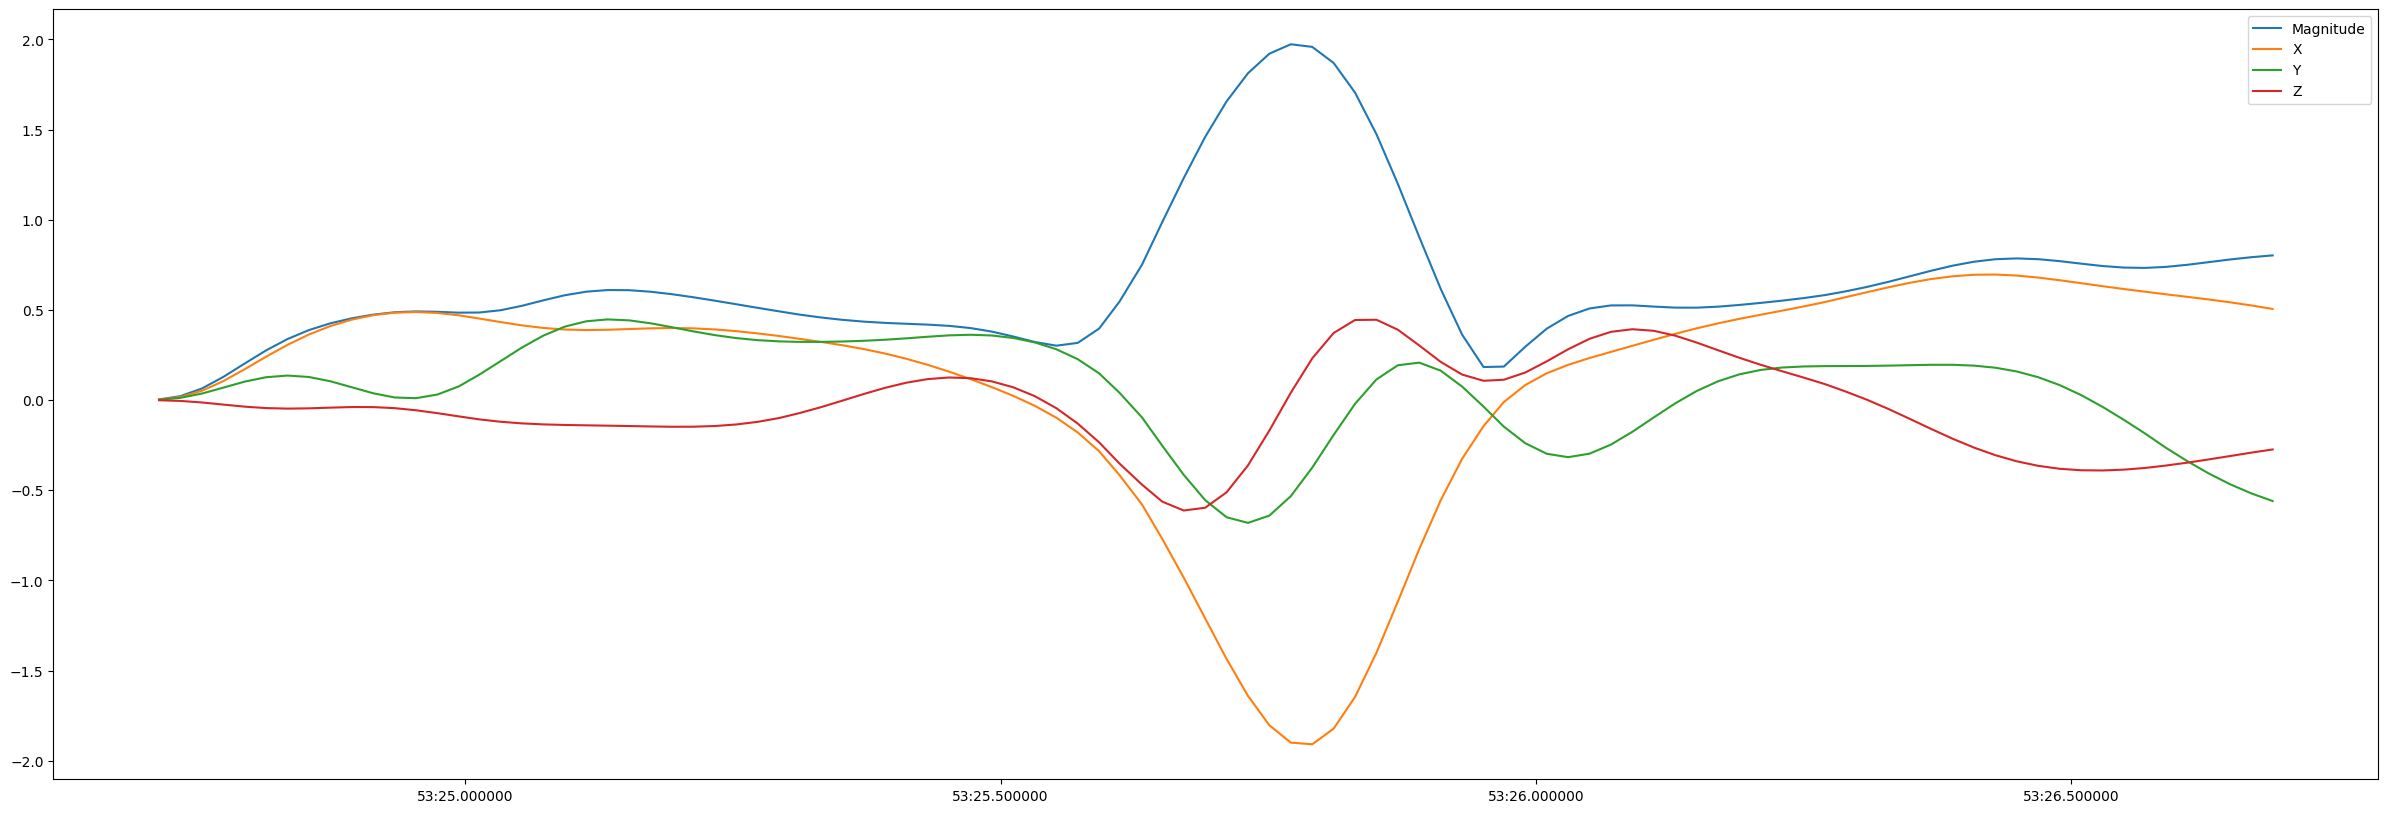

Processing data/smash_all.csv
Loaded 2972 samples
Preprocessed 2972 samples
Found 17 shots


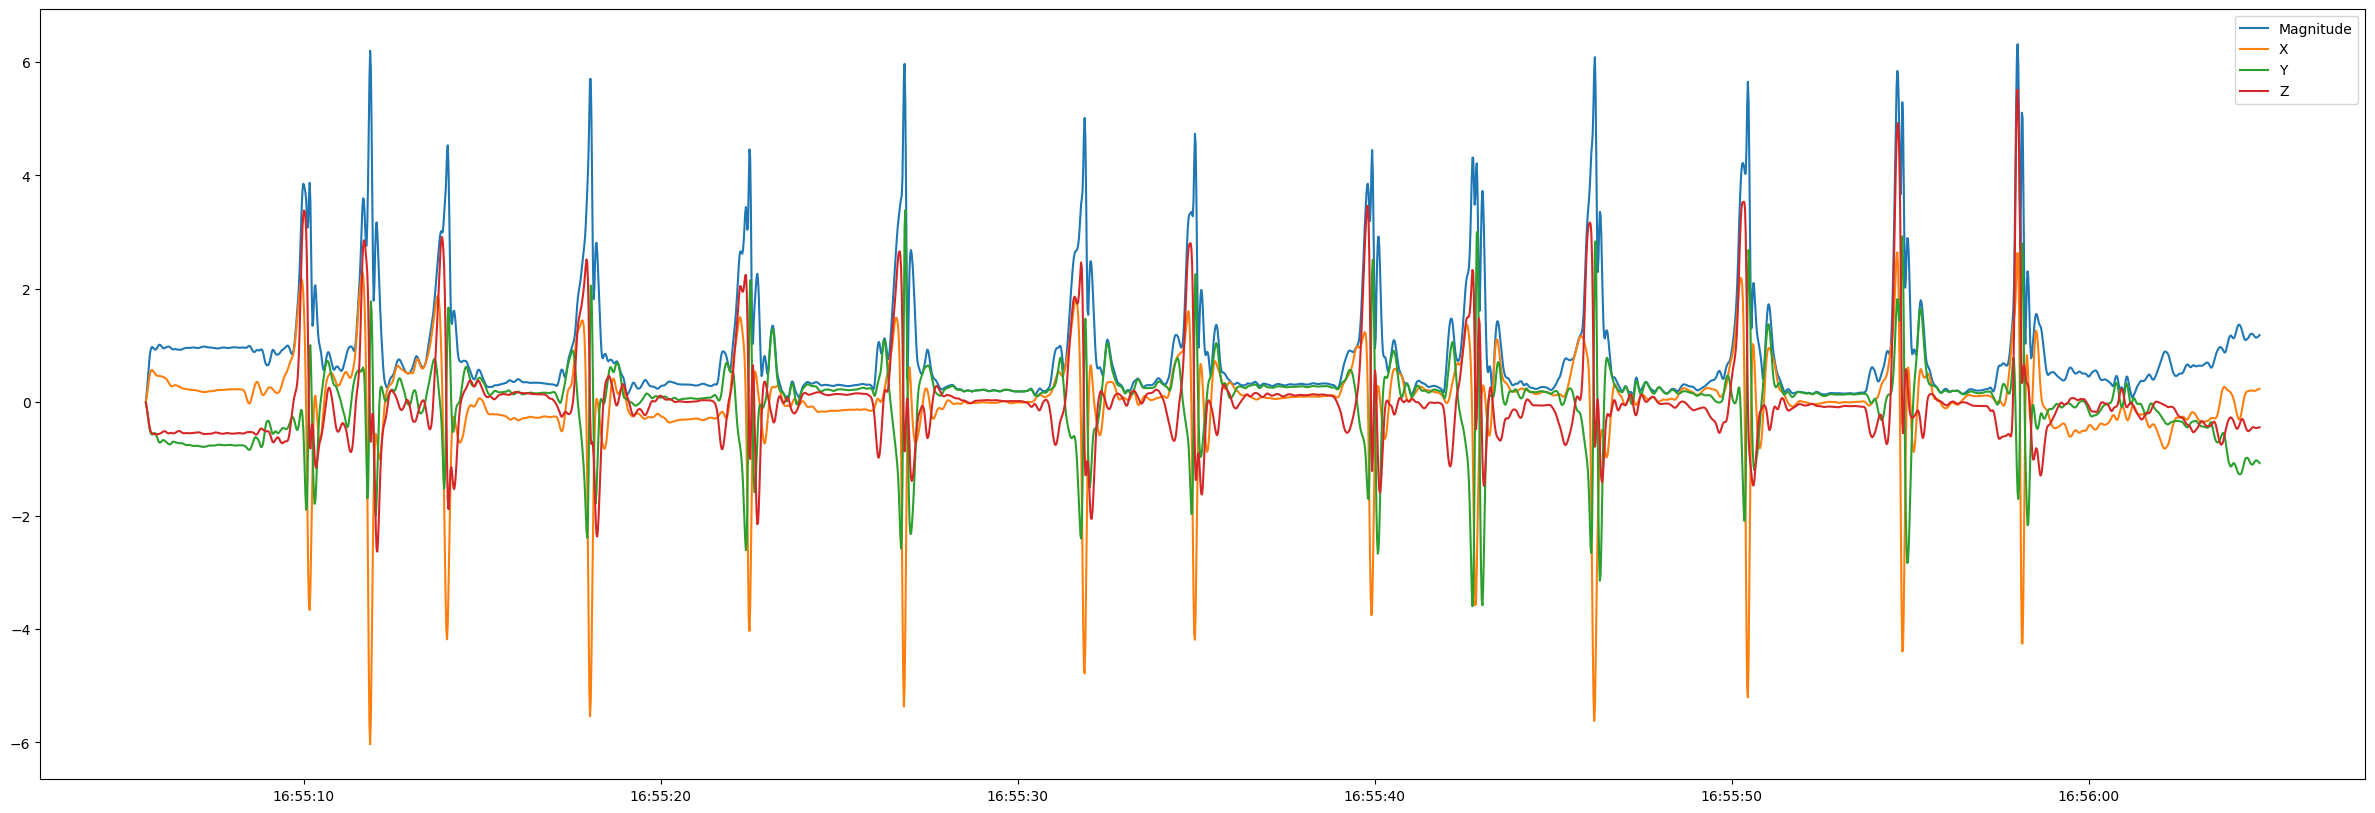

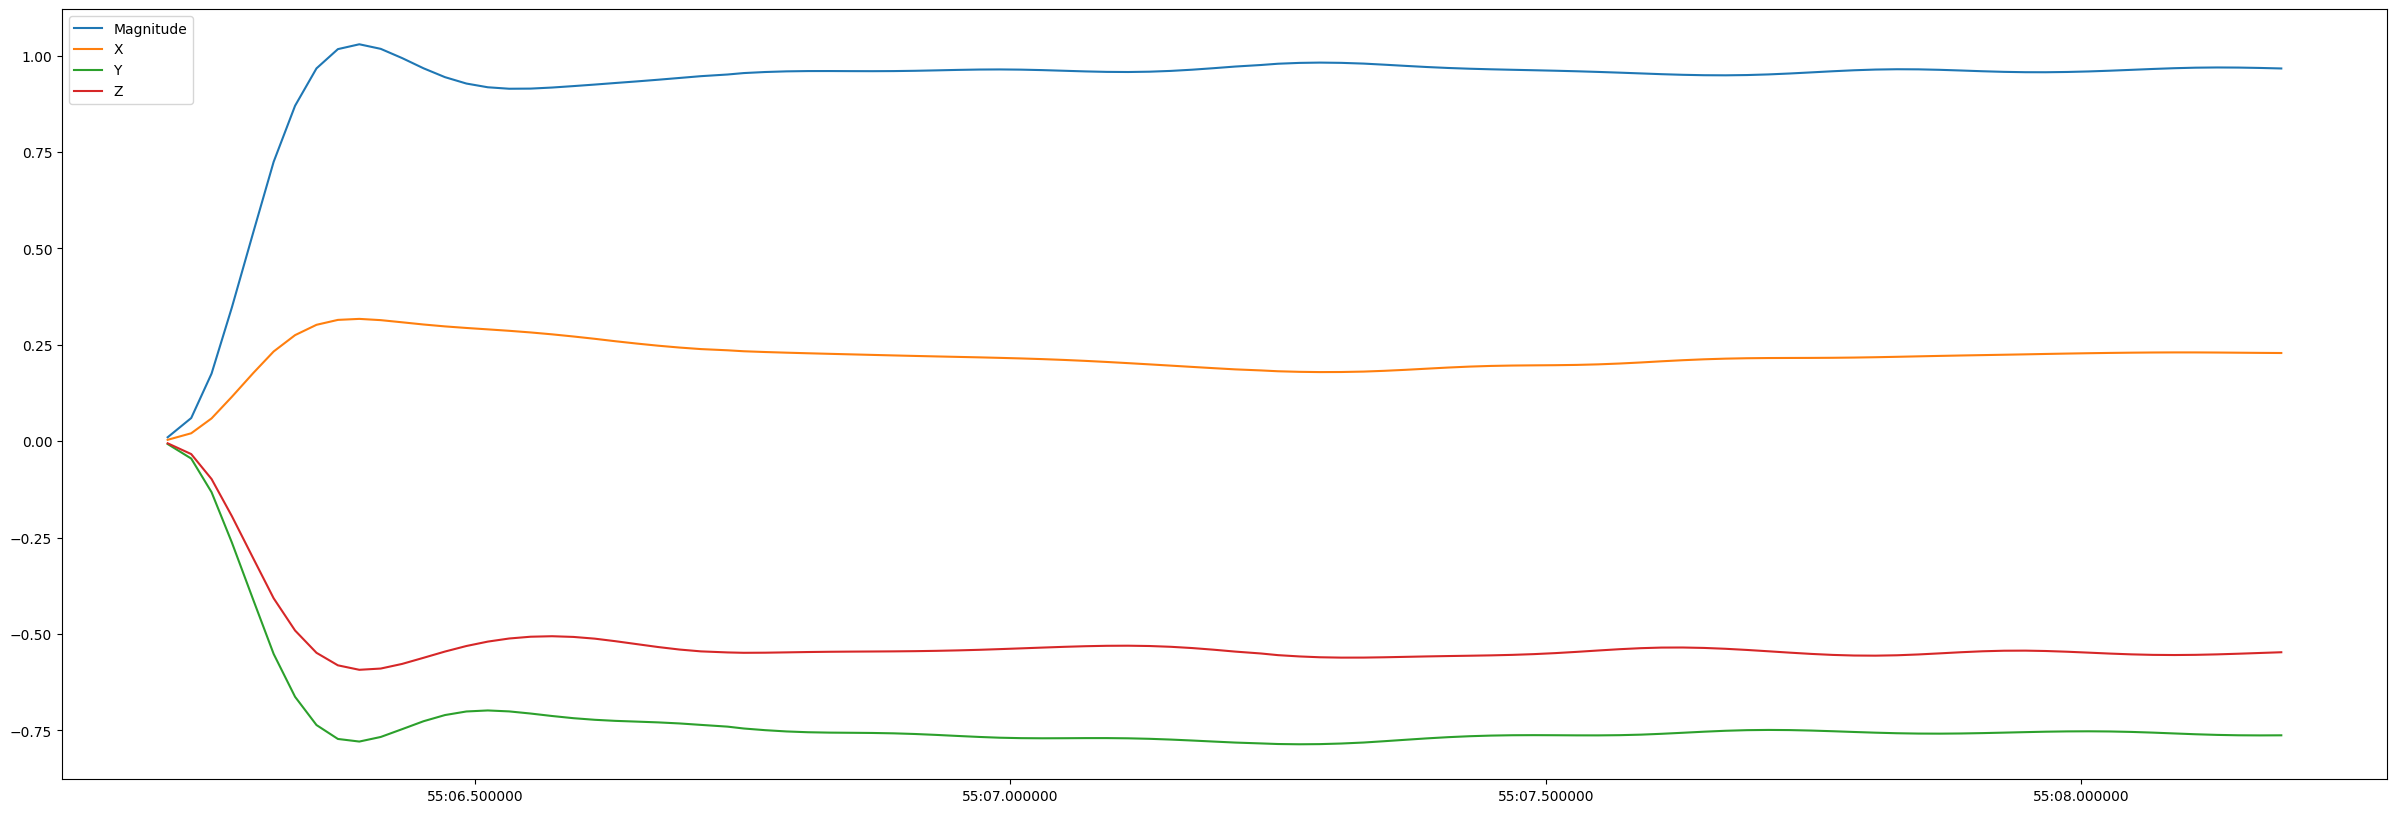

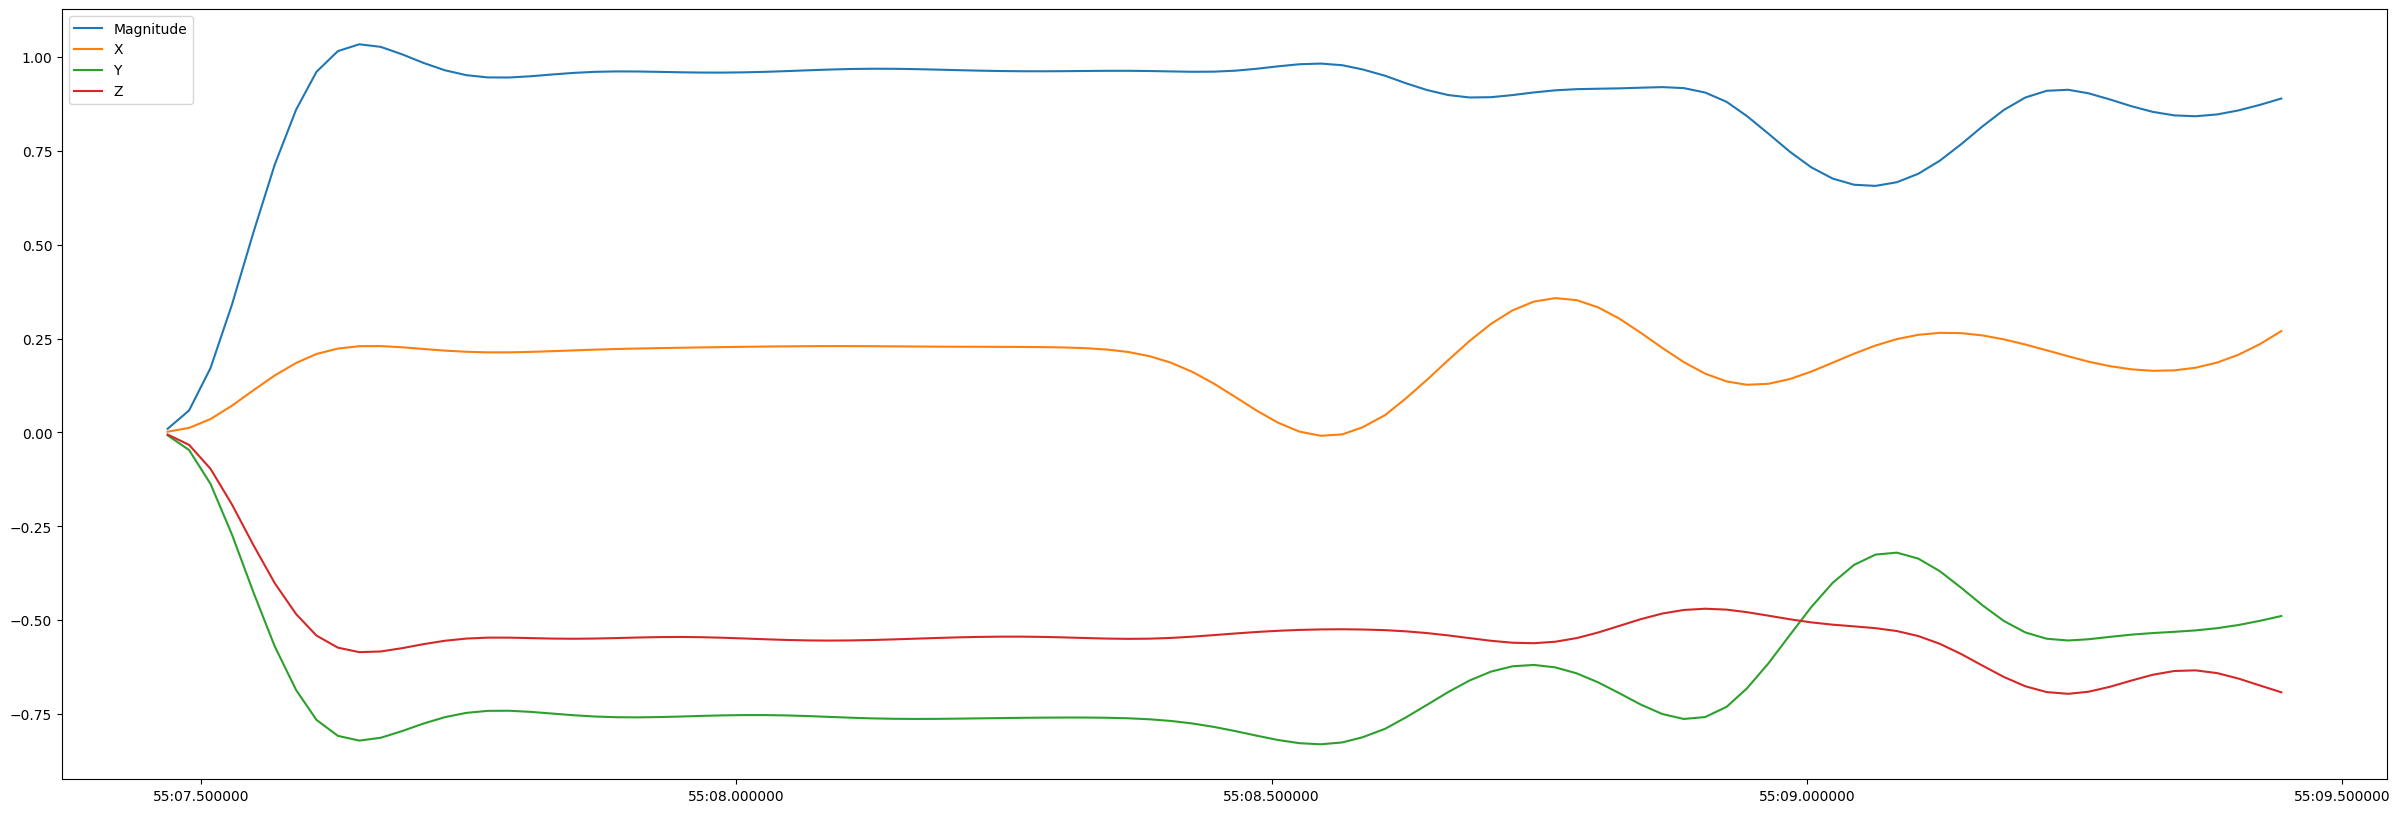

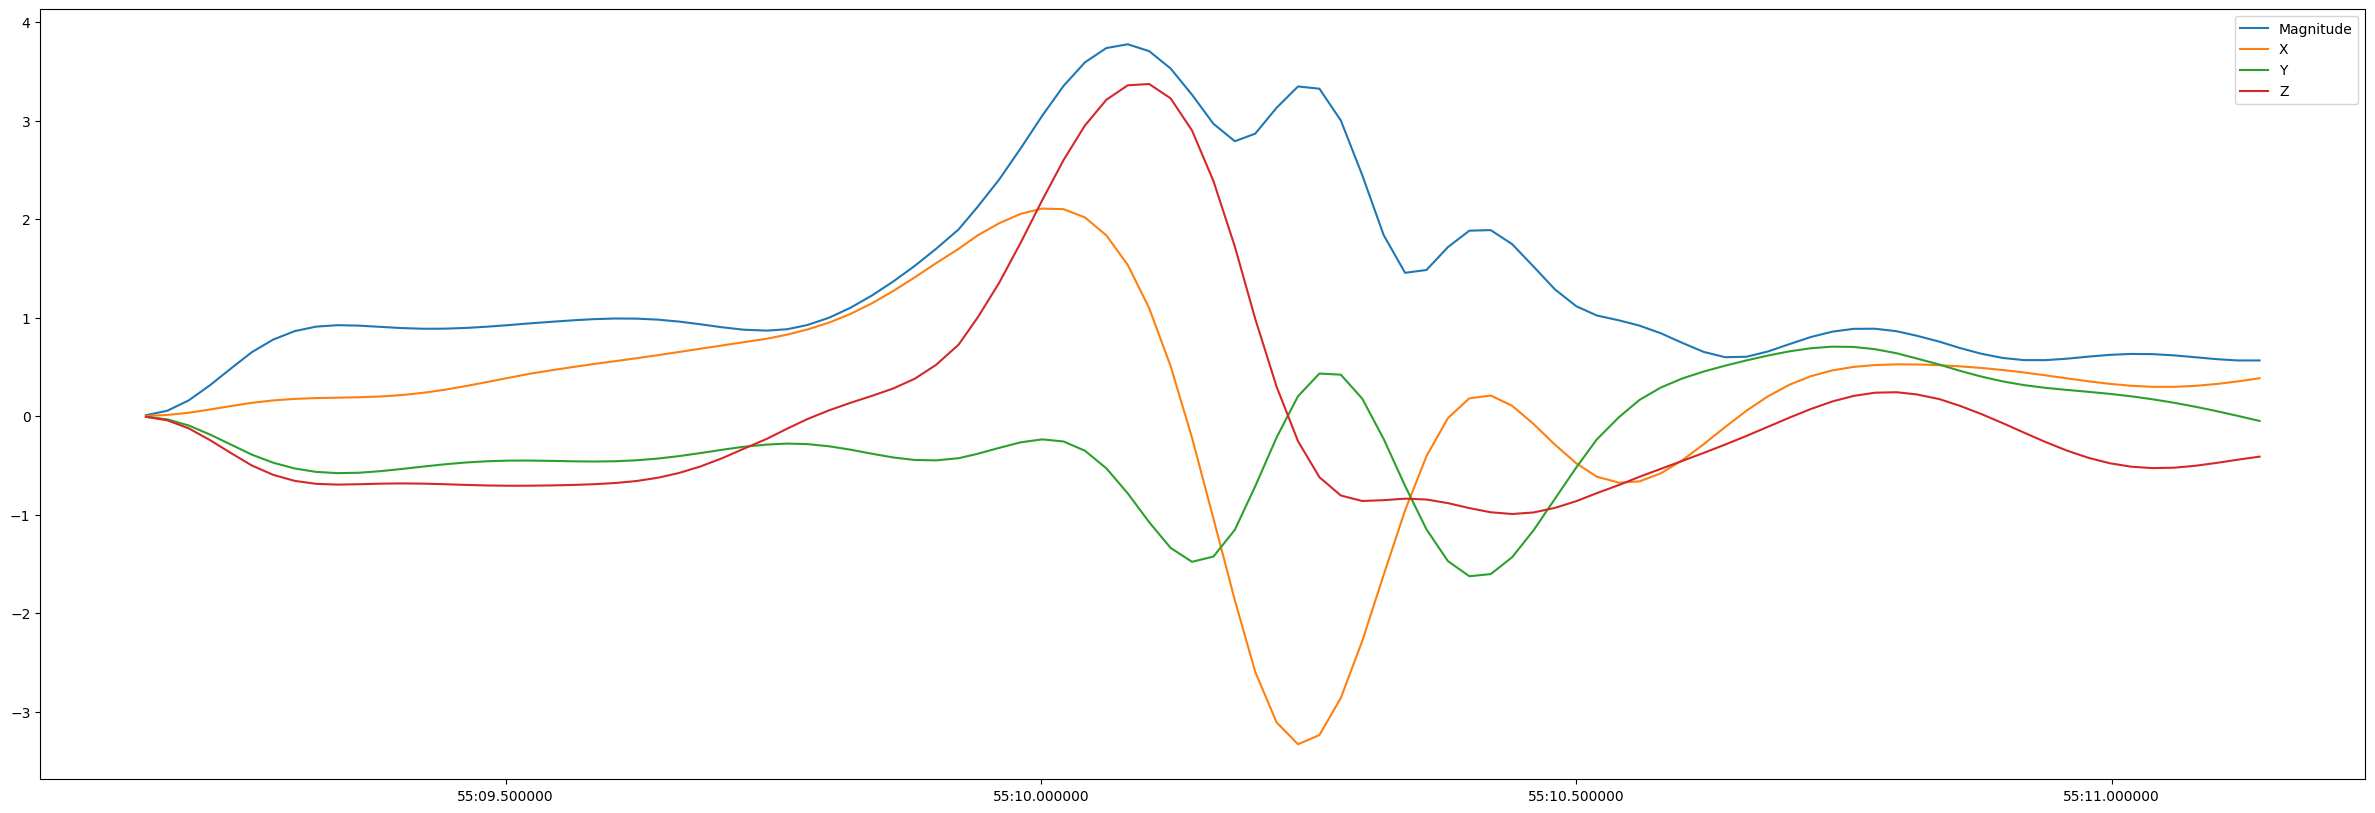

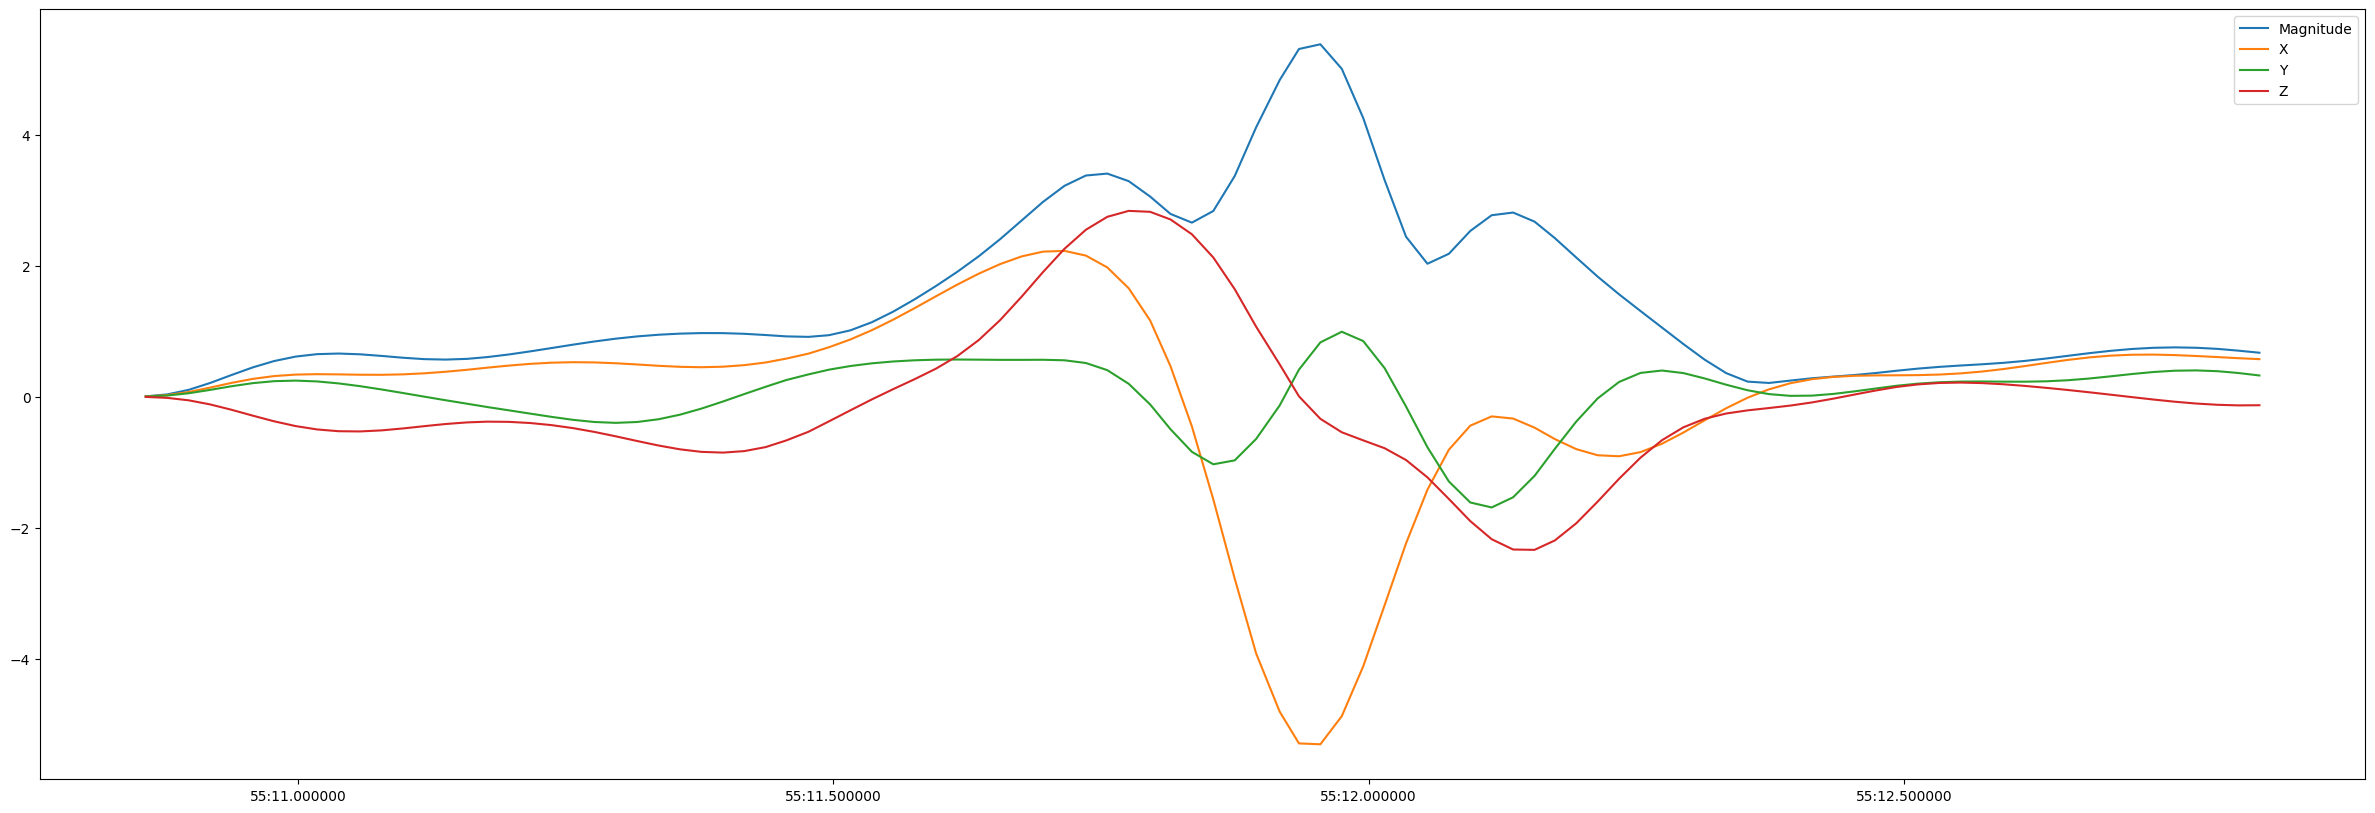

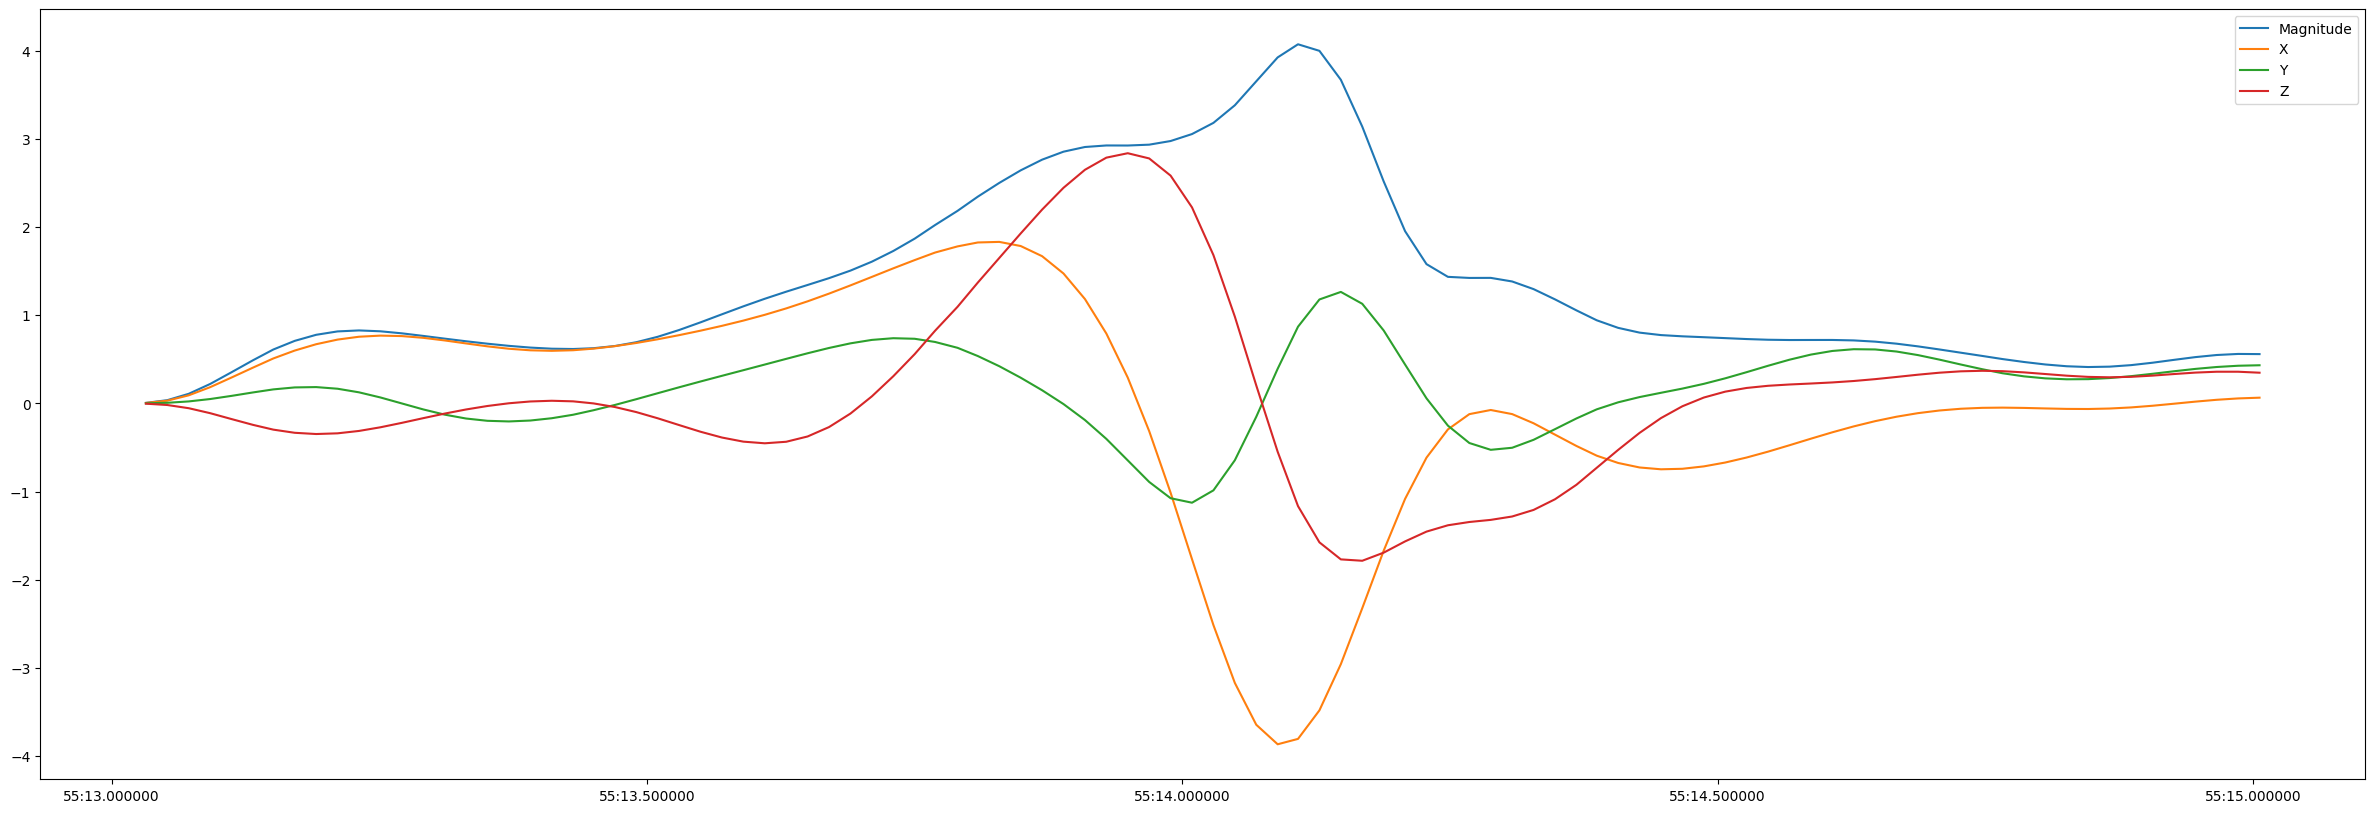

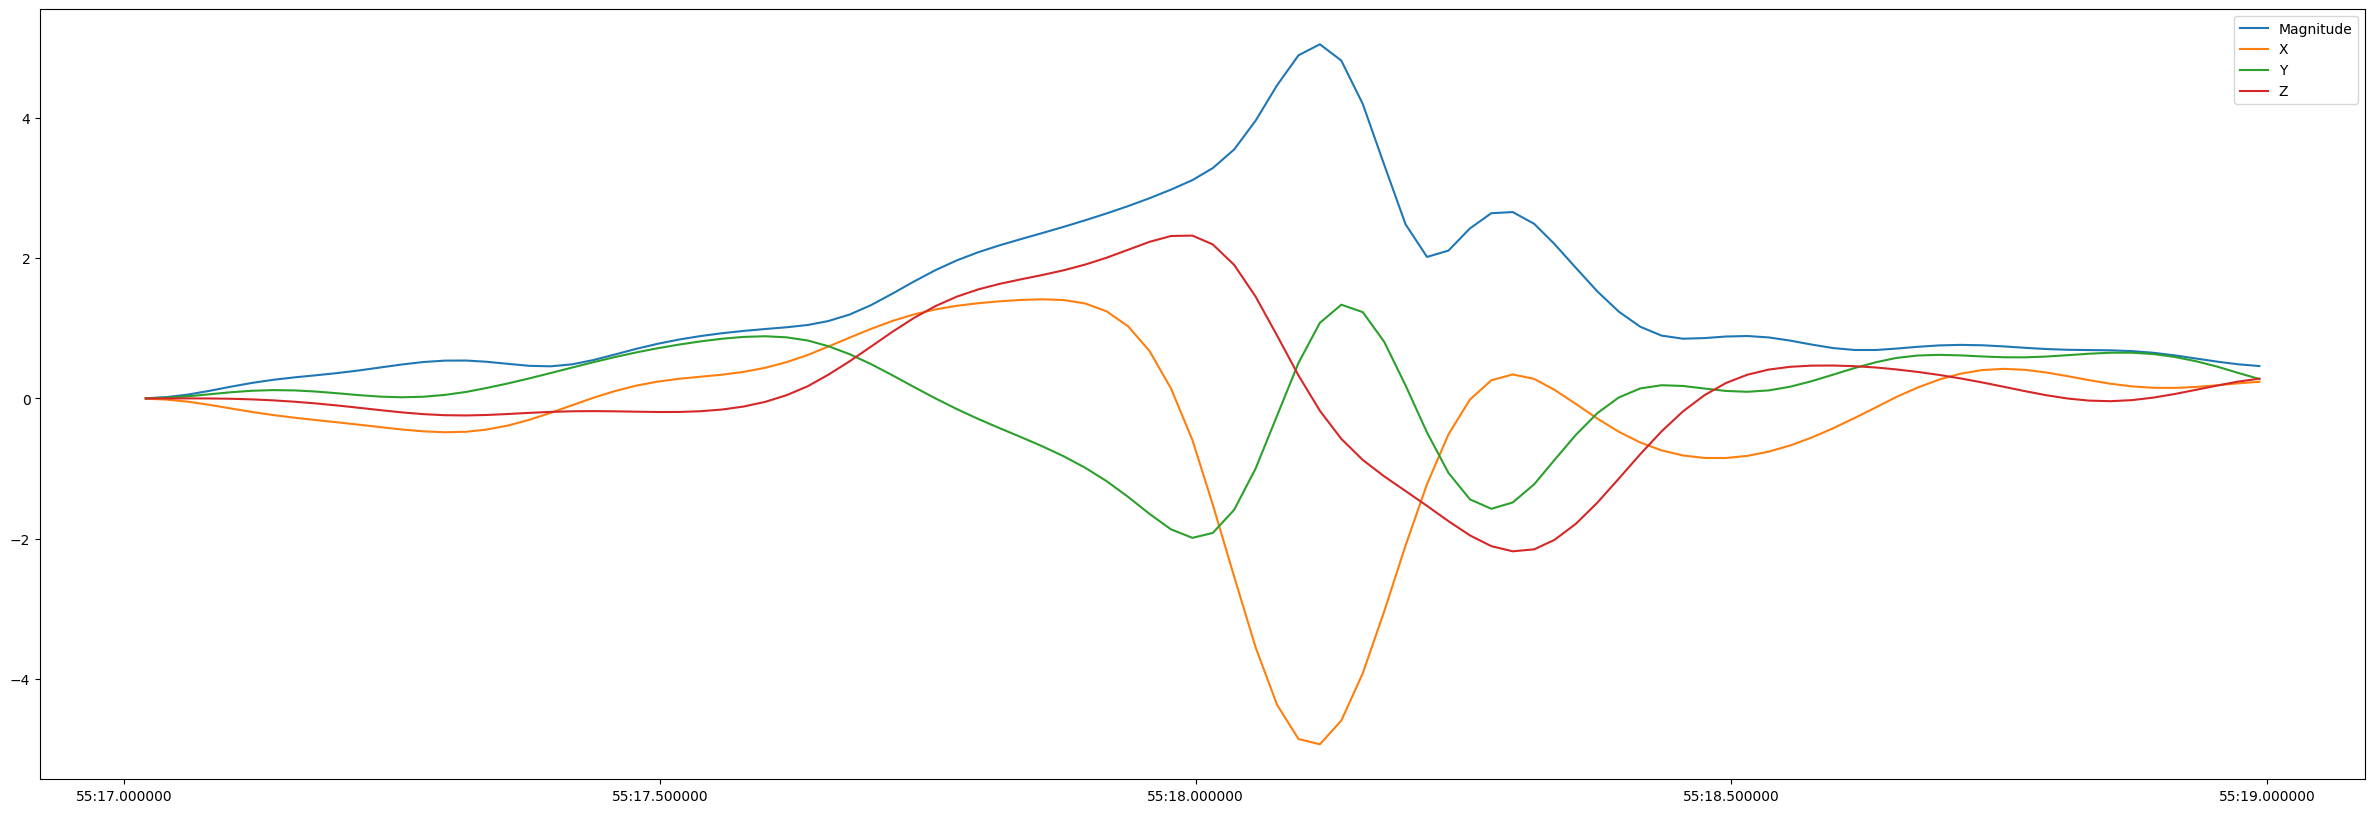

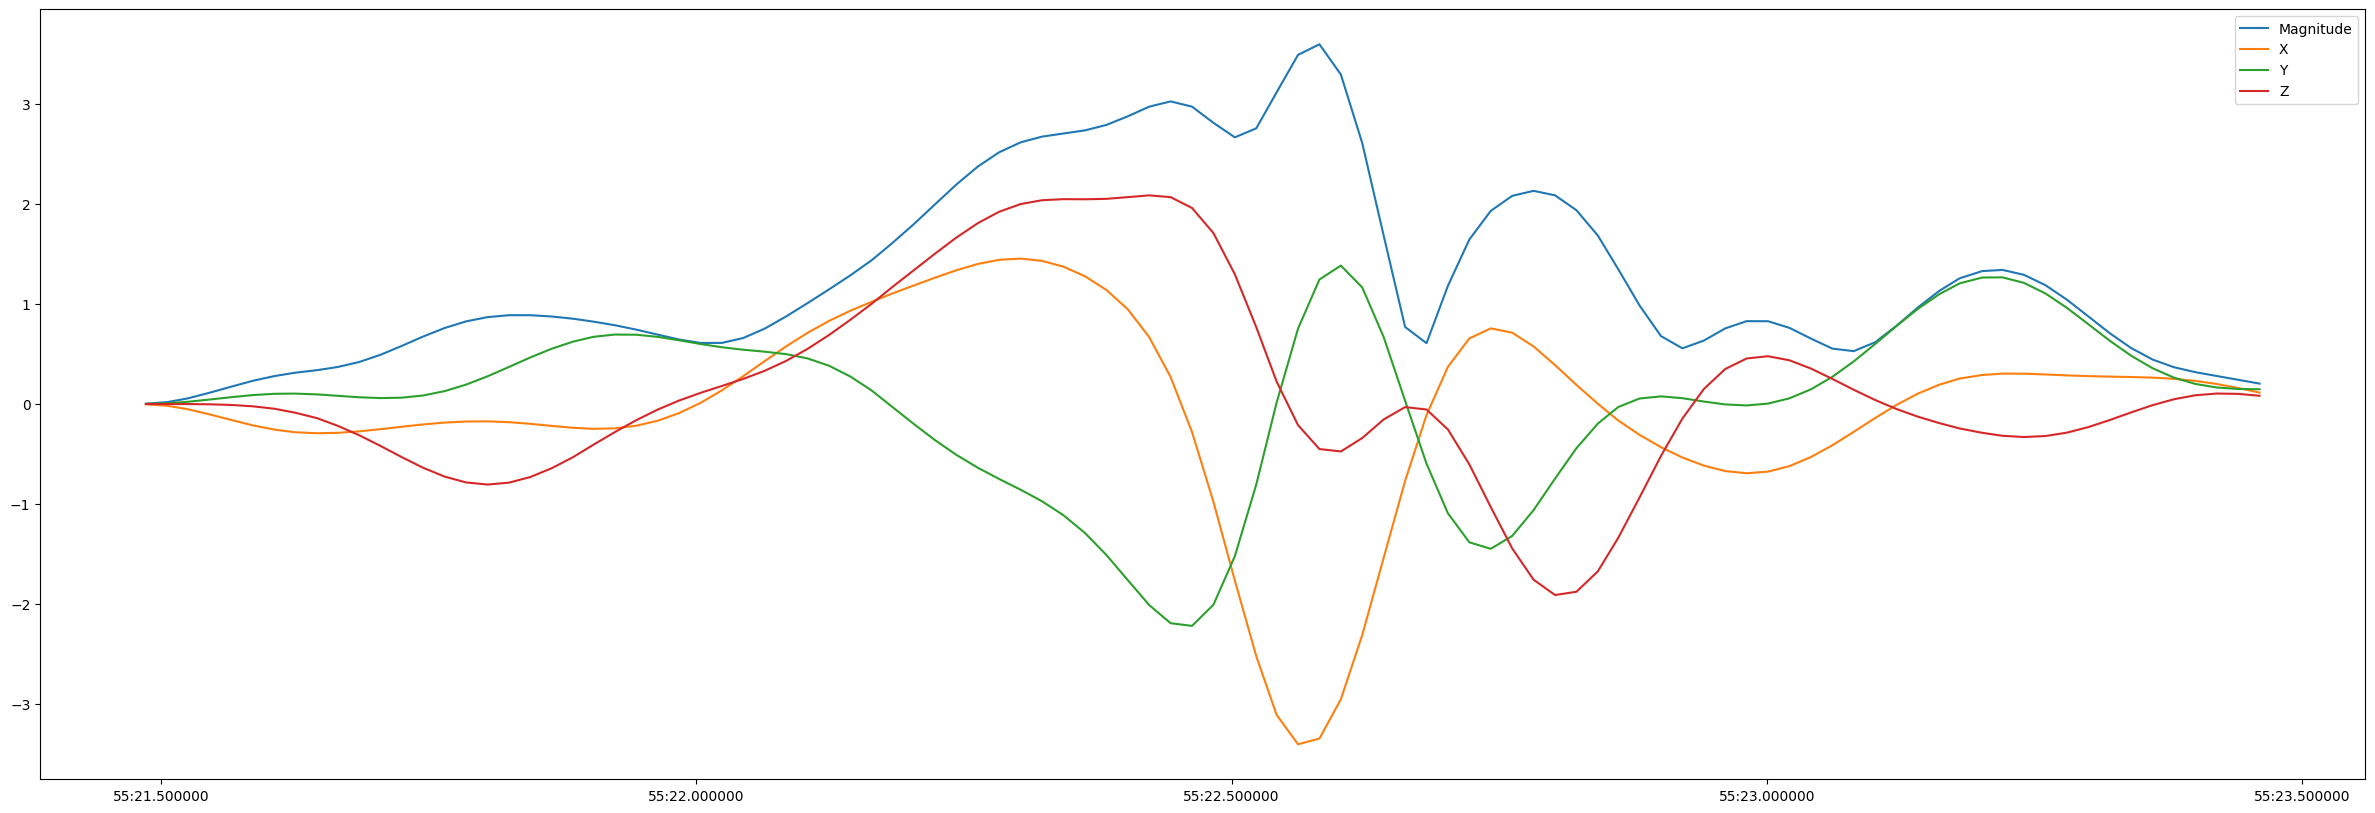

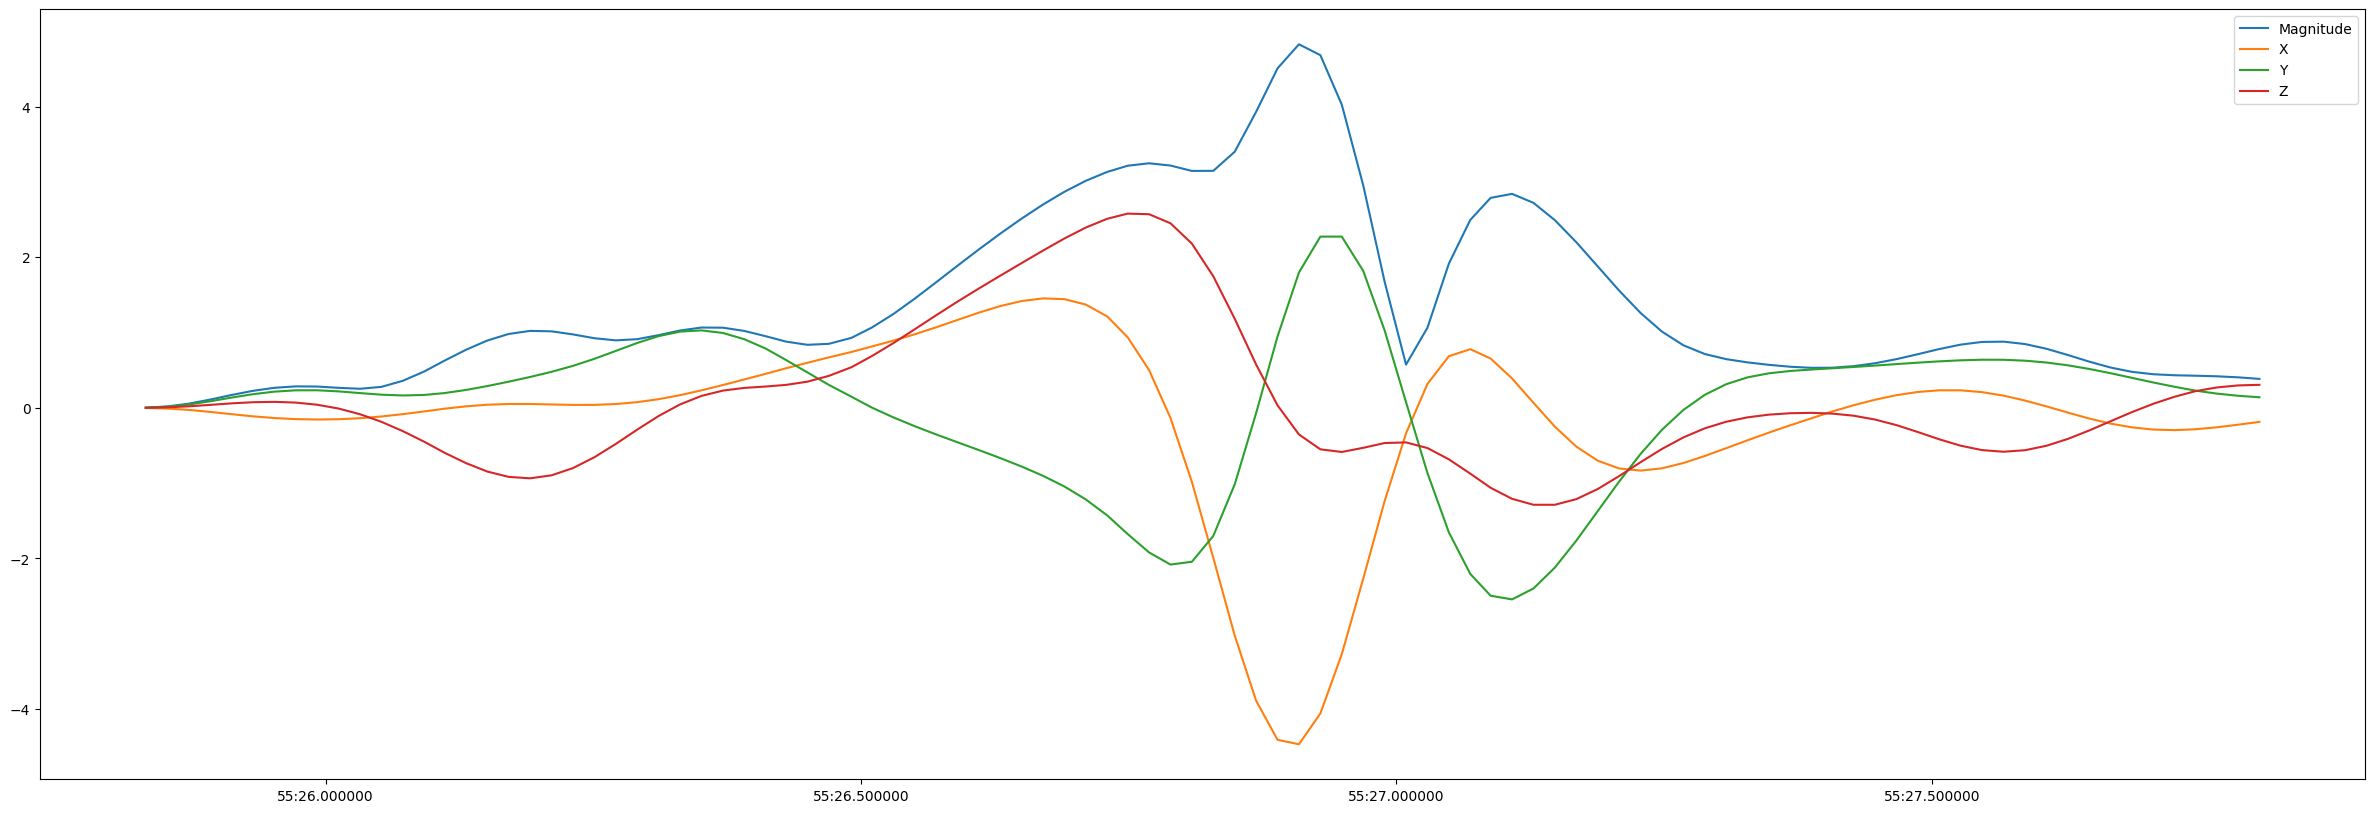

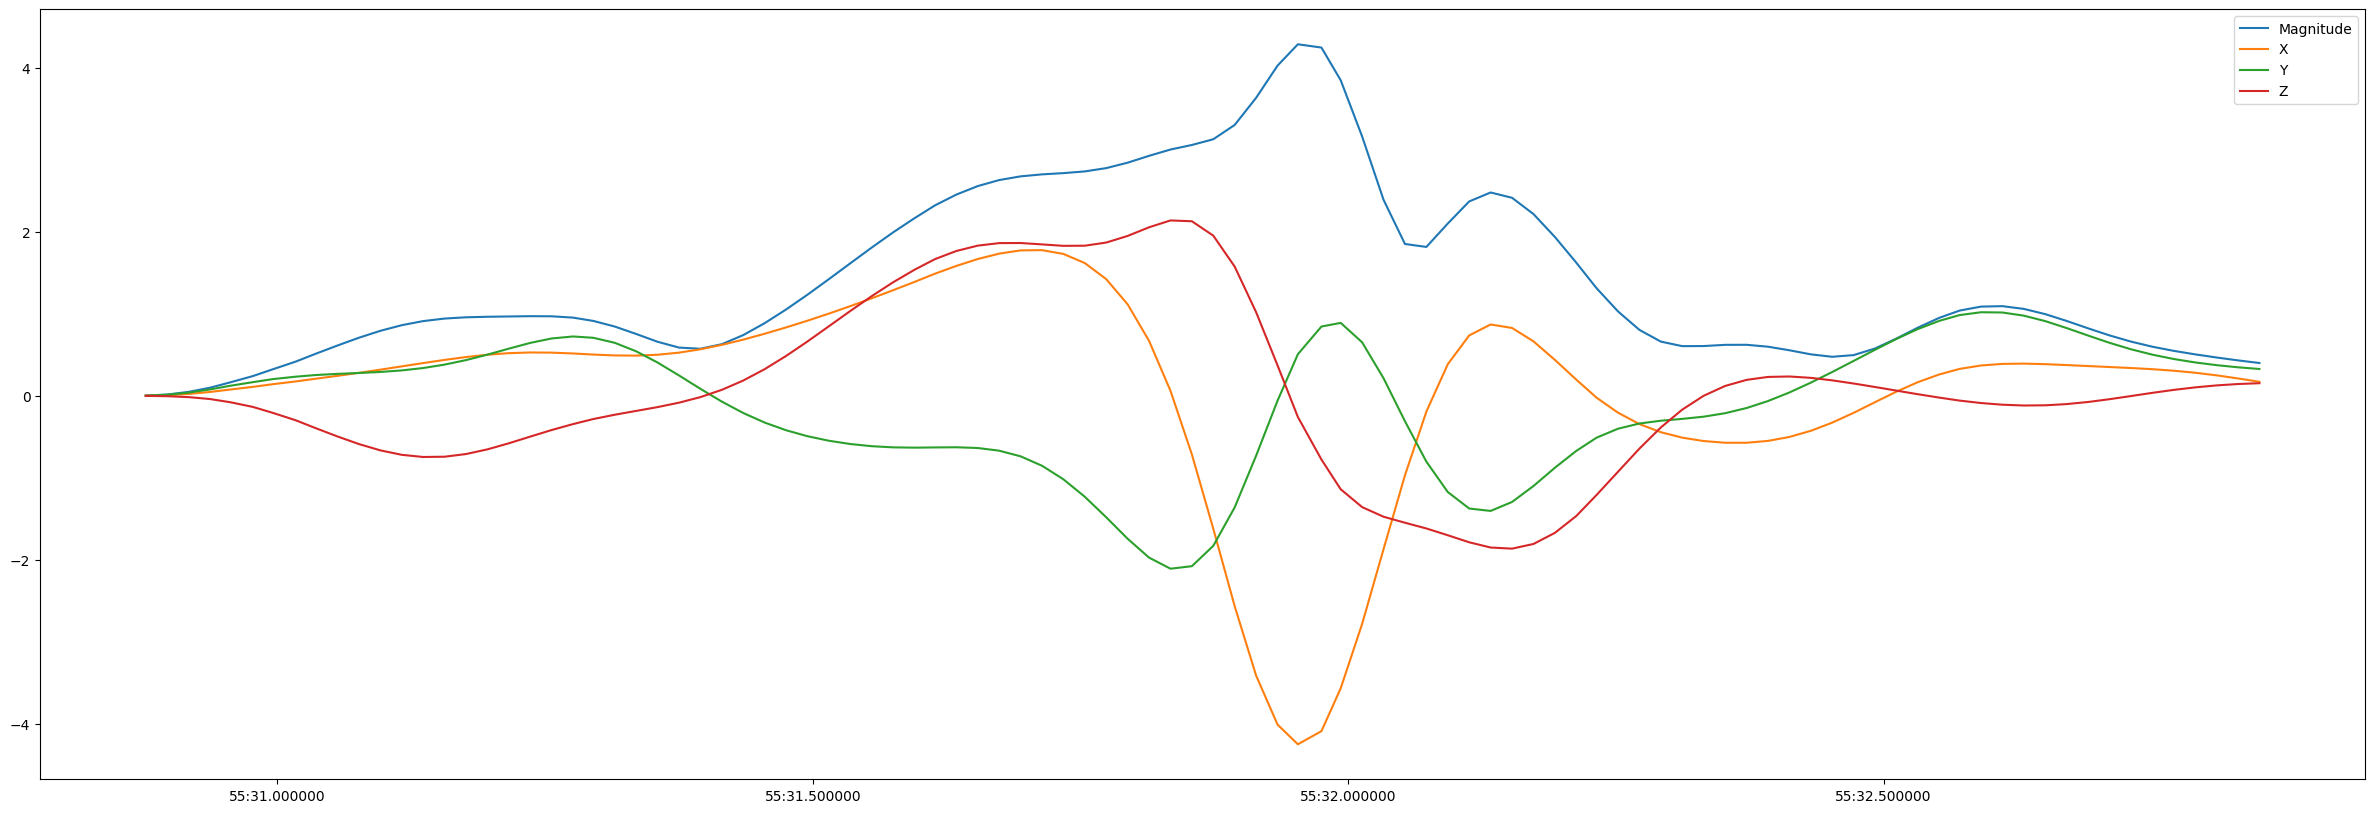

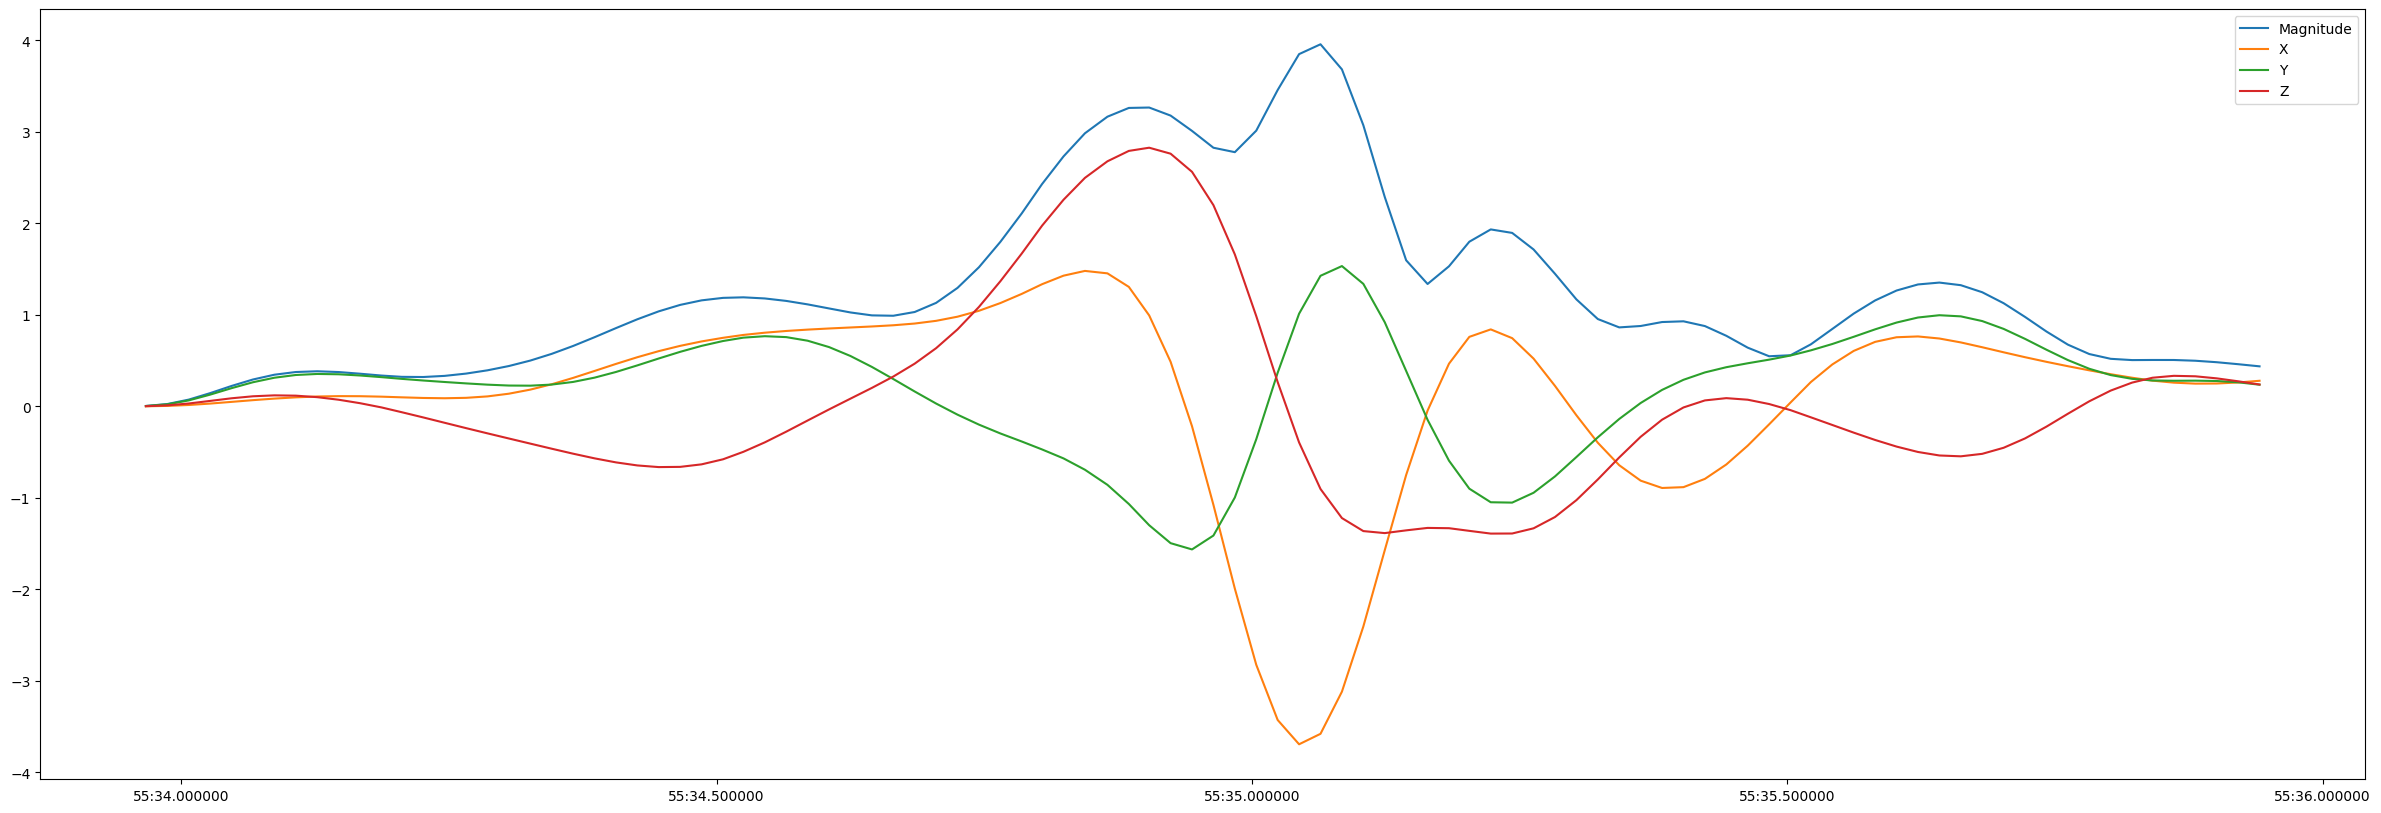

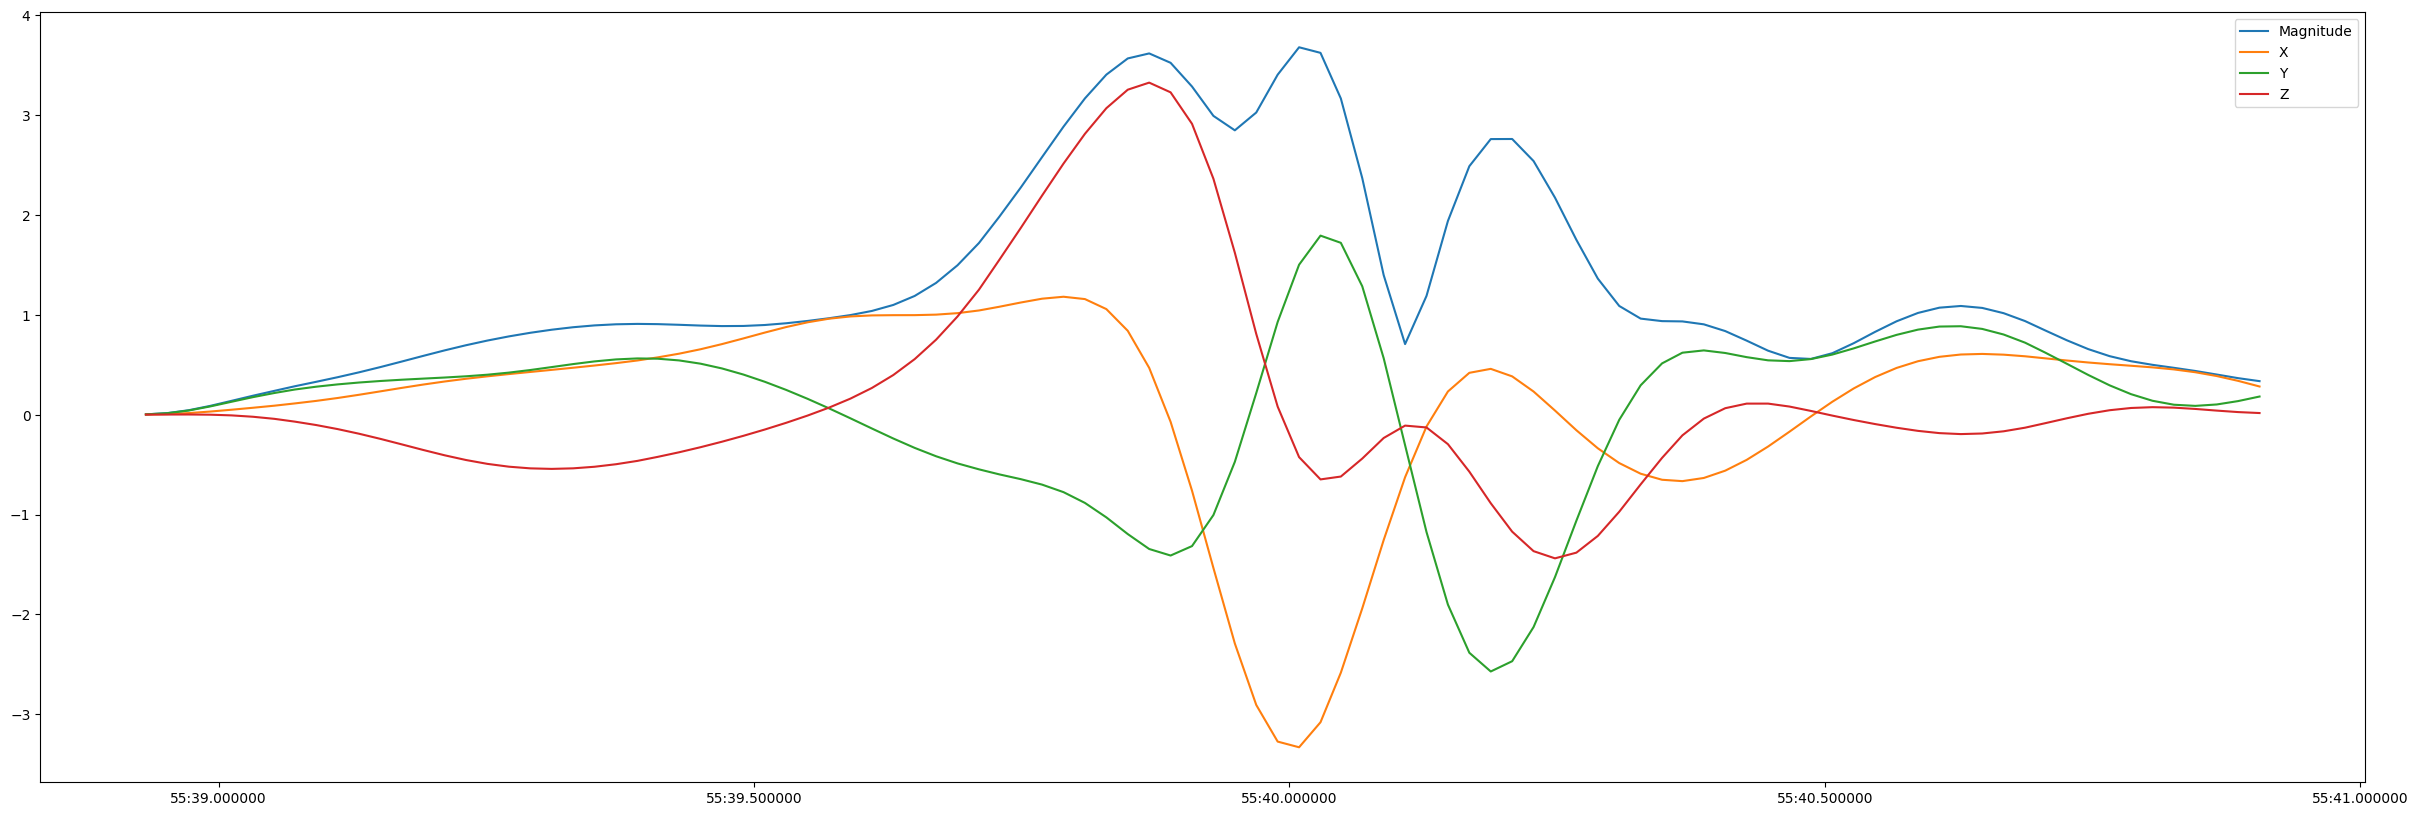

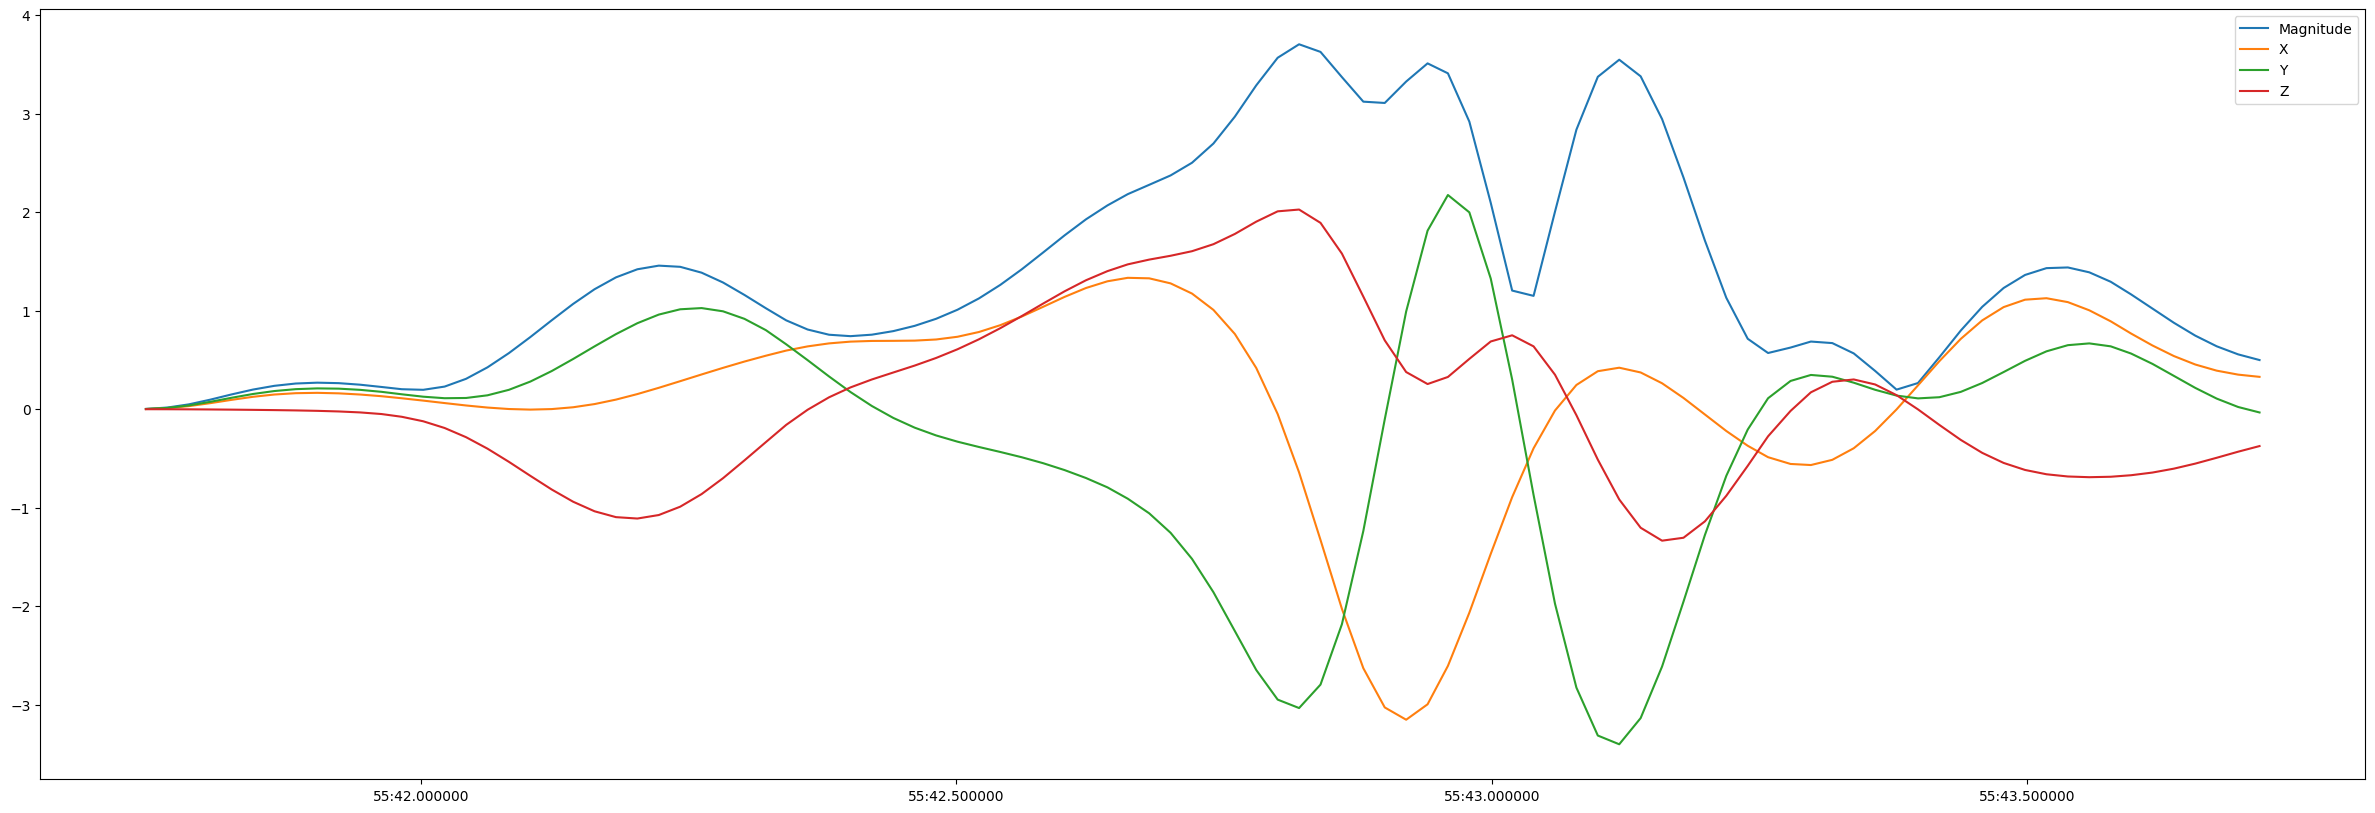

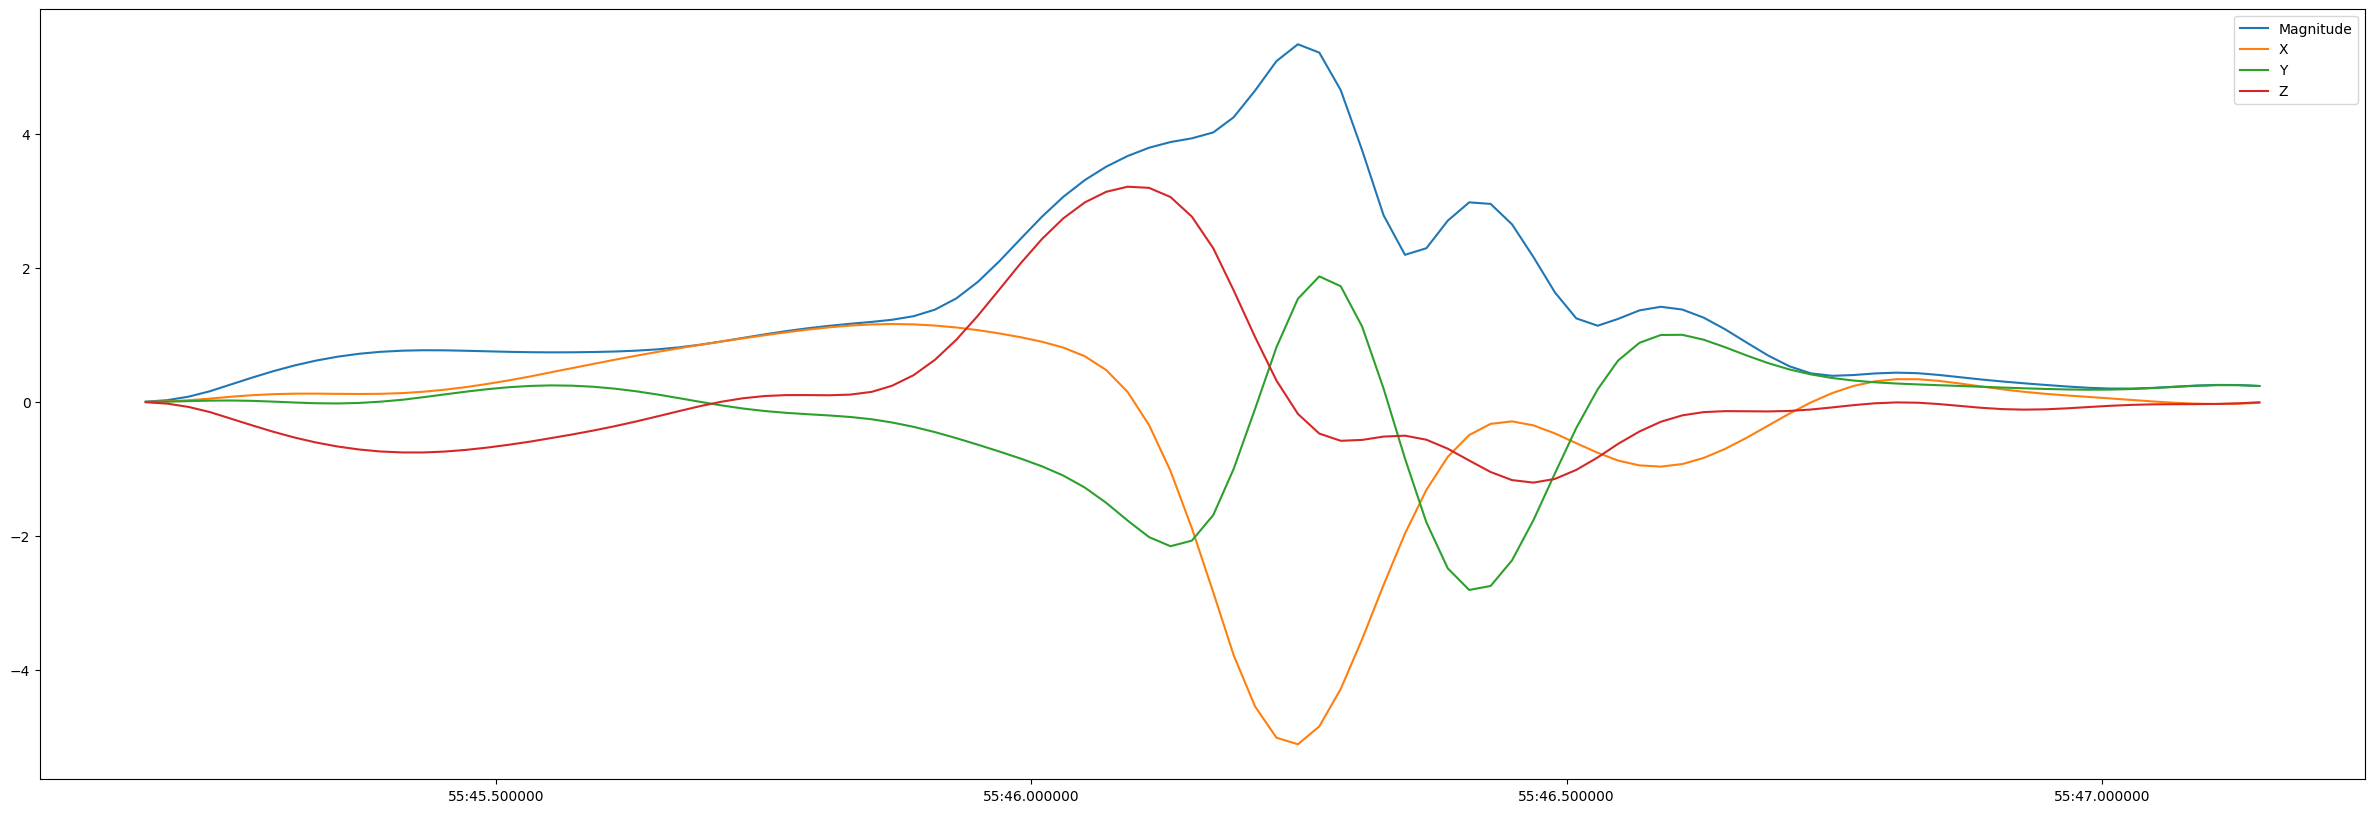

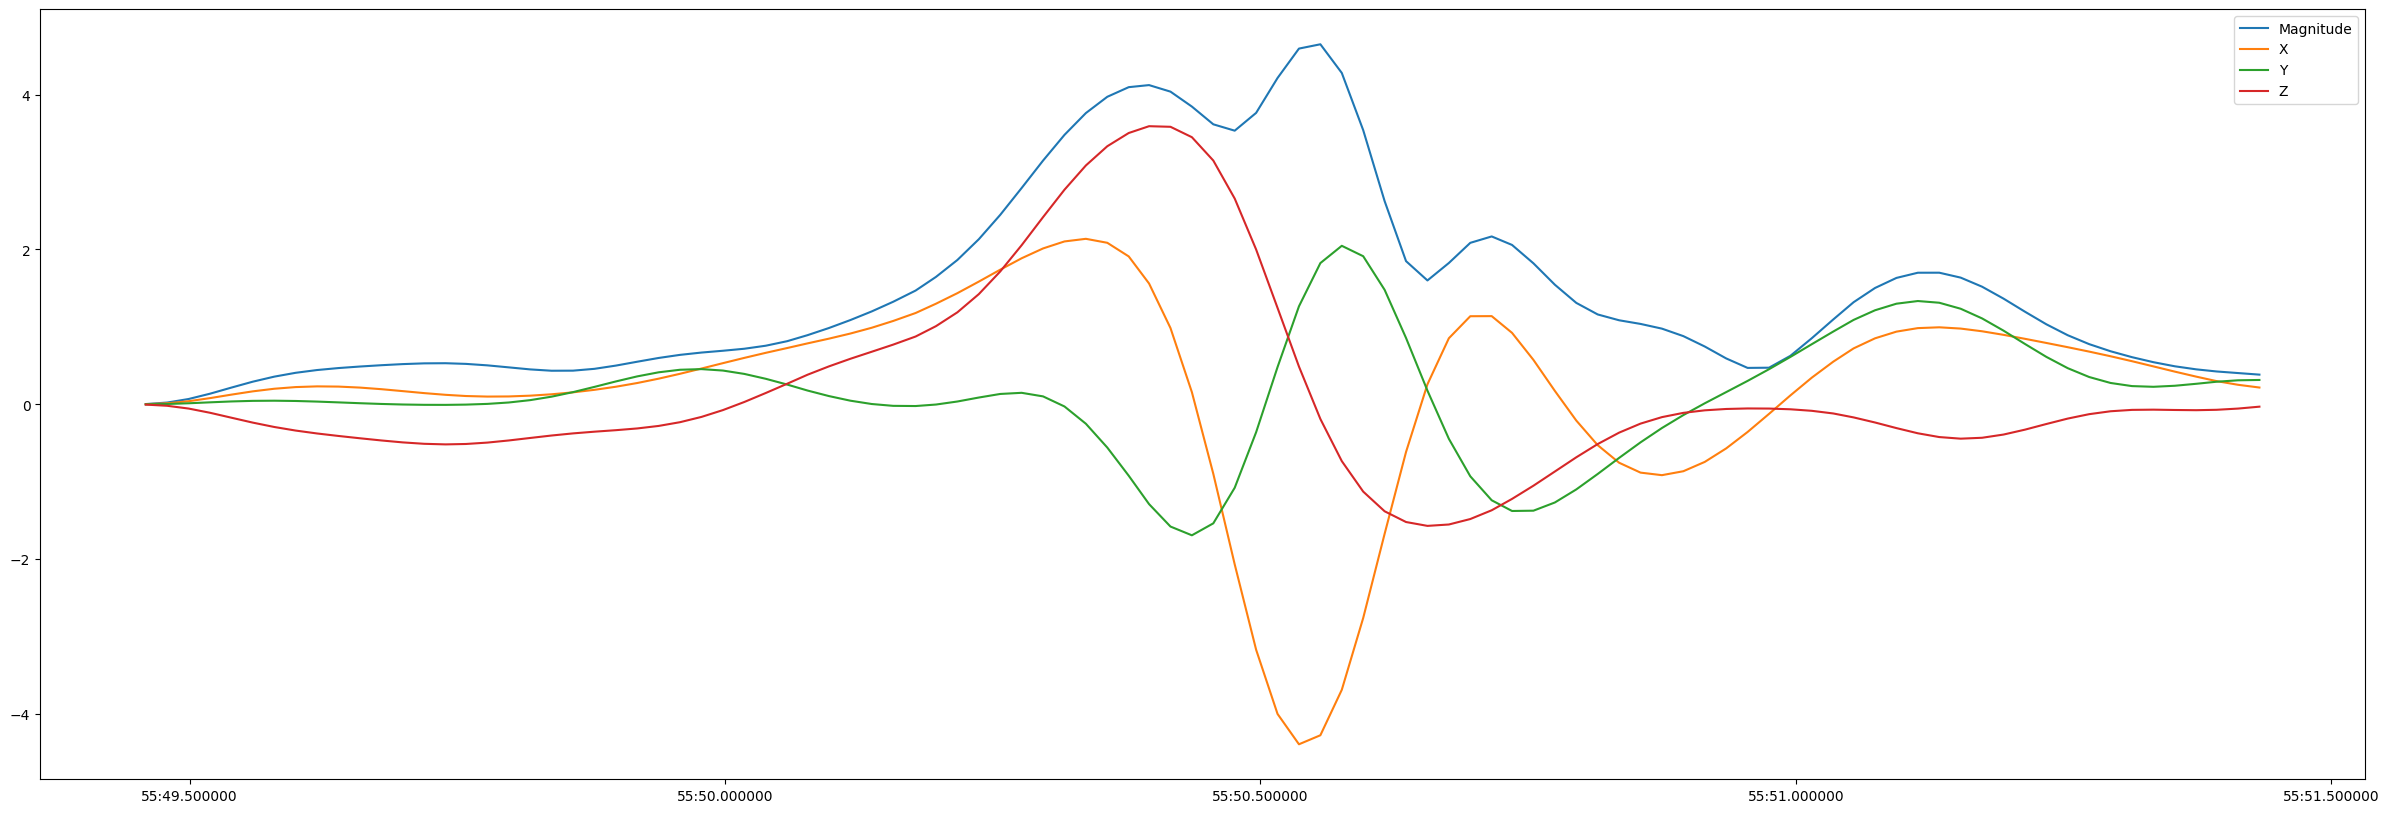

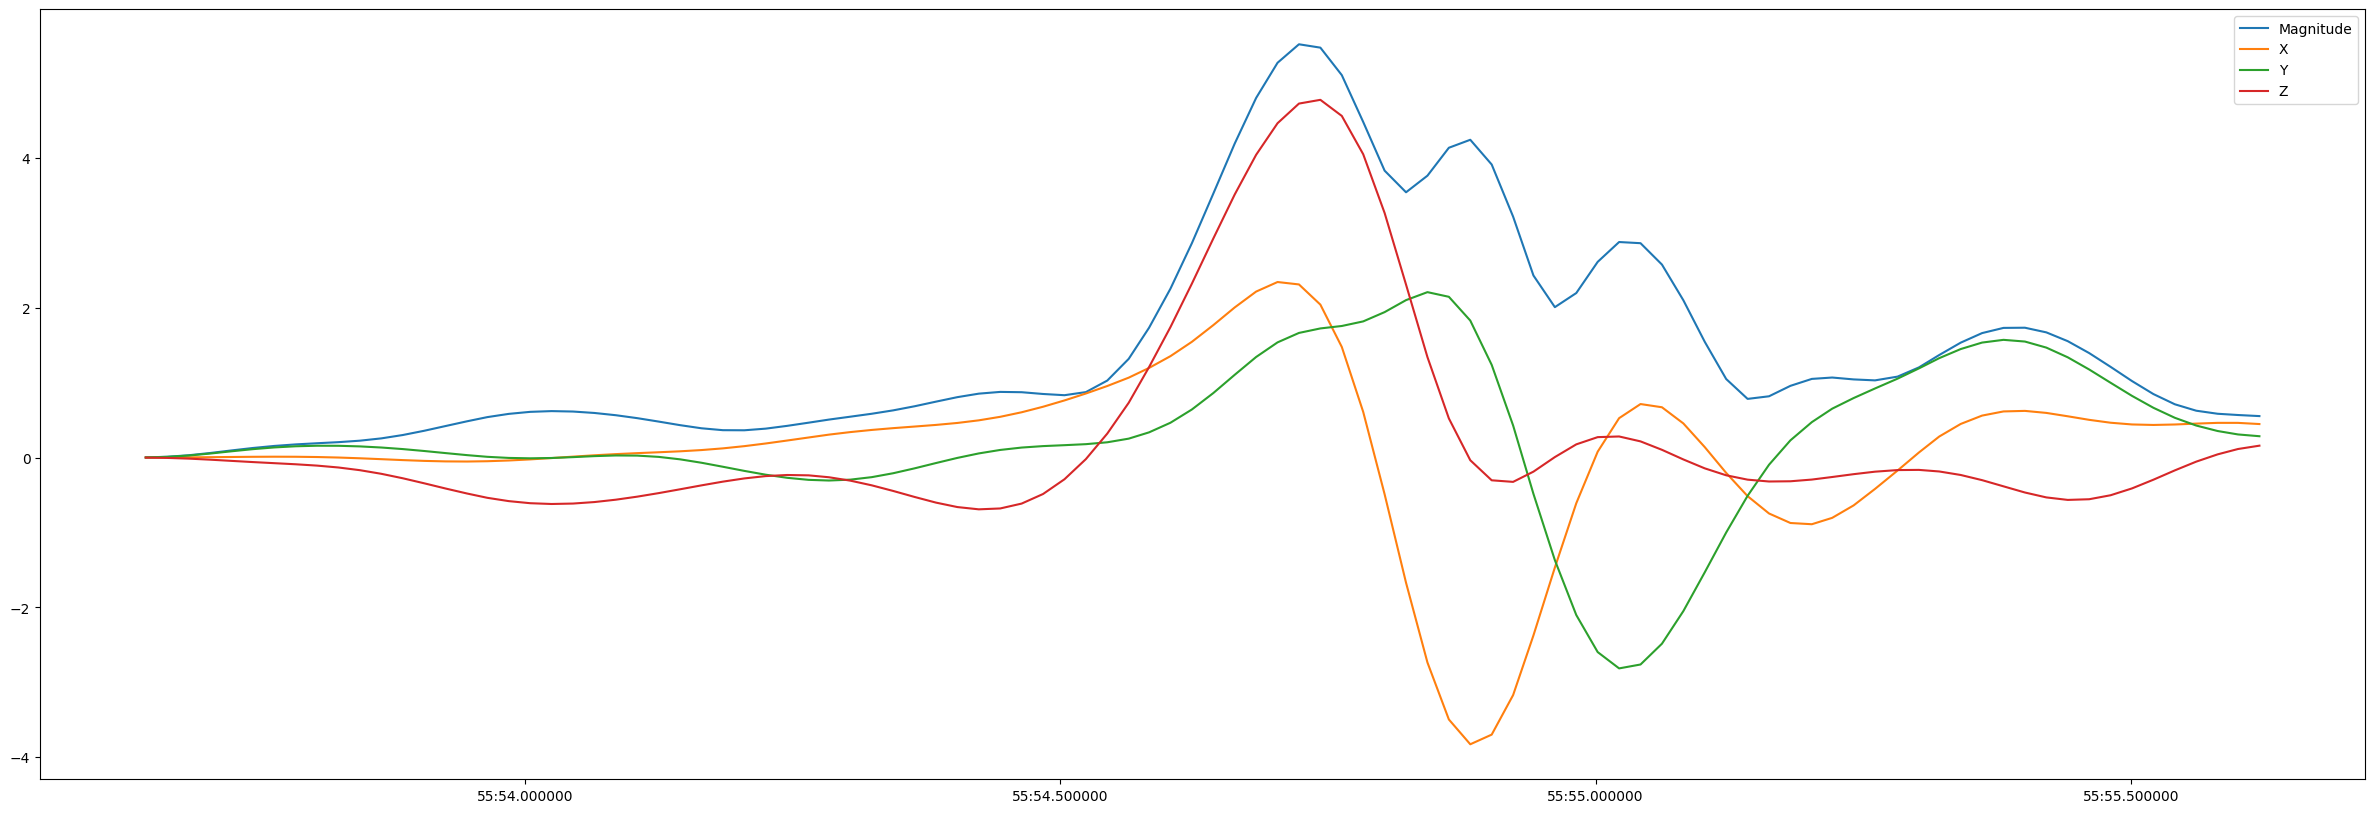

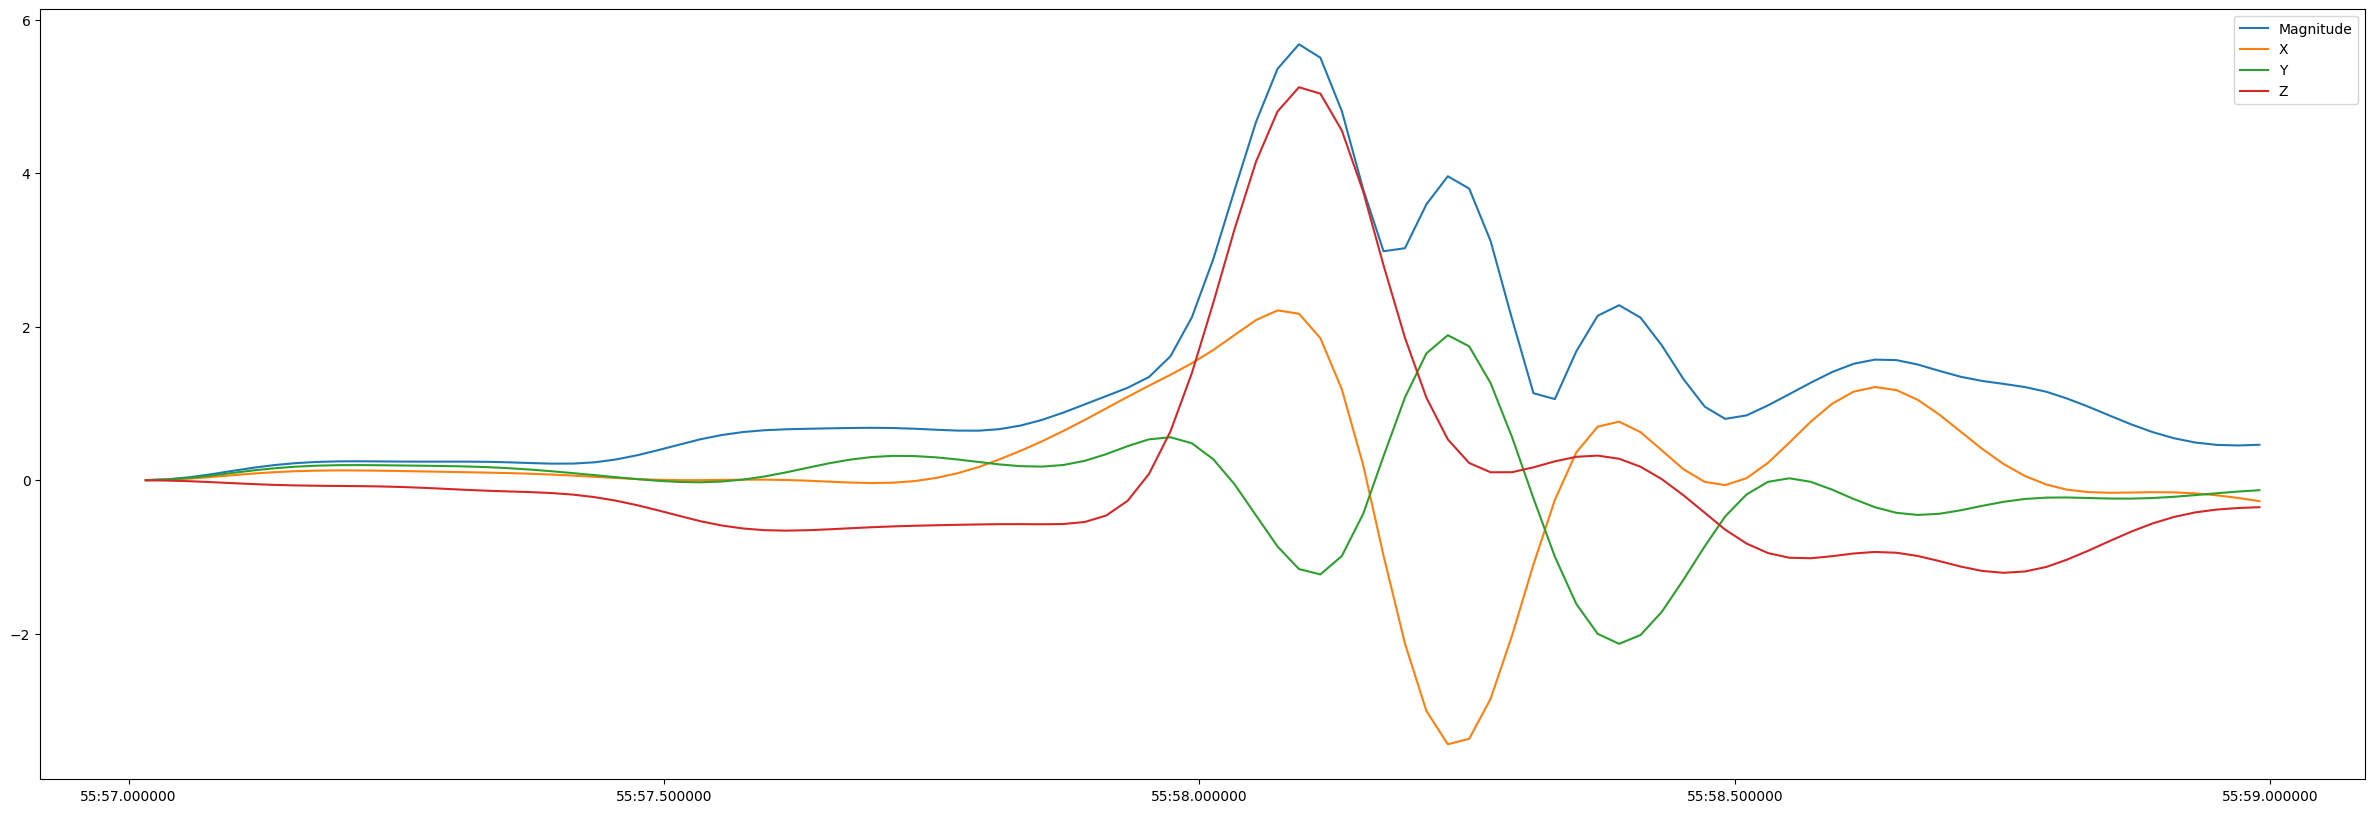

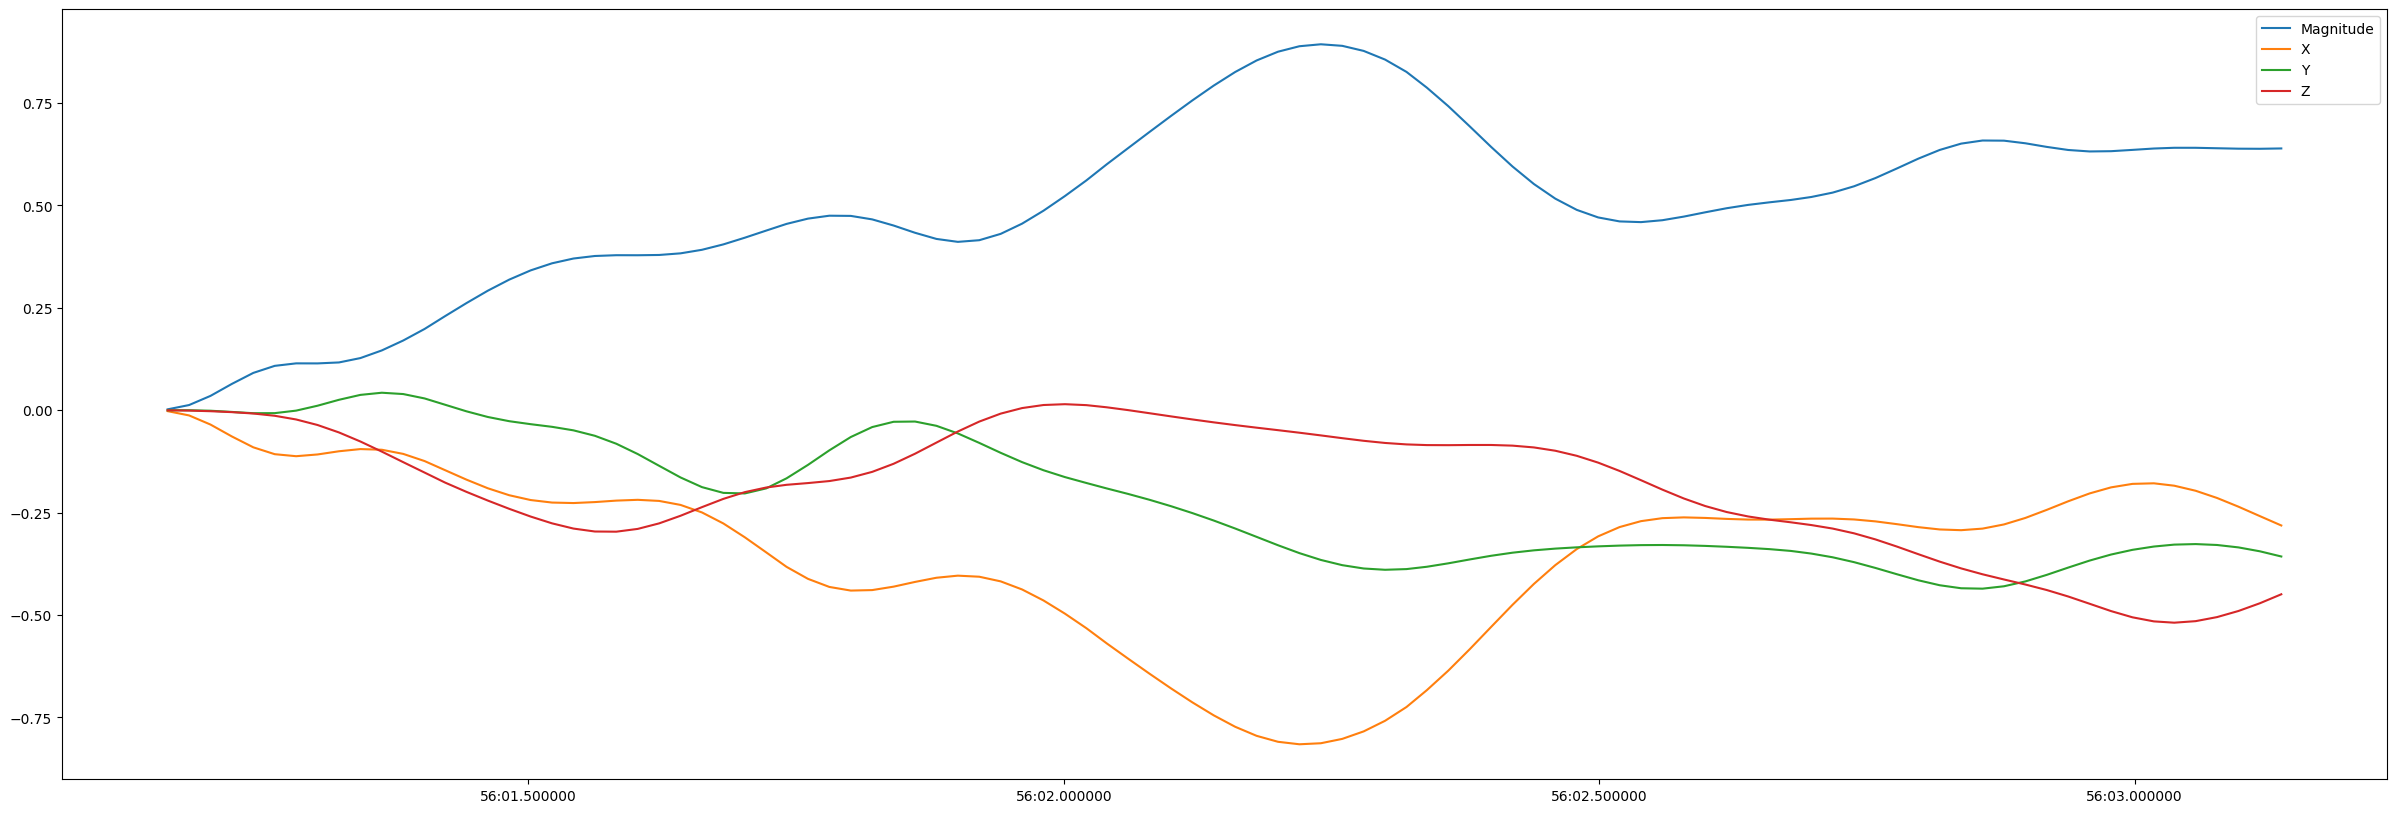

Dataset size: 53
Dataset
[{'time': 84    2023-11-22 21:51:45.167000+01:00
85    2023-11-22 21:51:45.187000+01:00
86    2023-11-22 21:51:45.207000+01:00
87    2023-11-22 21:51:45.229000+01:00
88    2023-11-22 21:51:45.254000+01:00
89    2023-11-22 21:51:45.267000+01:00
90    2023-11-22 21:51:45.287000+01:00
91    2023-11-22 21:51:45.307000+01:00
92    2023-11-22 21:51:45.327000+01:00
93    2023-11-22 21:51:45.347000+01:00
94    2023-11-22 21:51:45.367000+01:00
95    2023-11-22 21:51:45.387000+01:00
96    2023-11-22 21:51:45.407000+01:00
97    2023-11-22 21:51:45.426000+01:00
98    2023-11-22 21:51:45.447000+01:00
99    2023-11-22 21:51:45.466000+01:00
100   2023-11-22 21:51:45.486000+01:00
101   2023-11-22 21:51:45.506000+01:00
102   2023-11-22 21:51:45.526000+01:00
103   2023-11-22 21:51:45.546000+01:00
104   2023-11-22 21:51:45.566000+01:00
105   2023-11-22 21:51:45.586000+01:00
106   2023-11-22 21:51:45.606000+01:00
107   2023-11-22 21:51:45.626000+01:00
108   2023-11-22 21:51:45.646

In [152]:
# Parameters

# Data parameters
sensors = ['accelerometer']  # accelerometer or gyroscope
shot_labels = ['game', 'smash', 'clear', 'drive', 'drop', 'net_drop']  # Labels for the shots
shot_labels_ix = [0, 1, 2, 3, 4, 5]  # Indexes for the labels
paths_acc = ['data/game_acc.csv', 'data/smash_acc.csv', 'data/clear_acc.csv', 'data/drive_acc.csv', 'data/drop_acc.csv', 'data/net_drop_acc.csv']
paths_gyro = ['data/game_gyro.csv', 'data/smash_gyro.csv', 'data/clear_gyro.csv', 'data/drive_gyro.csv', 'data/drop_gyro.csv', 'data/net_drop_gyro.csv']
paths_all = ['data/game_all.csv', 'data/smash_all.csv', 'data/clear_all.csv', 'data/drive_all.csv', 'data/drop_all.csv', 'data/net_drop_all.csv']
paths = [paths_acc[shot_labels.index("clear")], paths_all[shot_labels.index("smash")]]
shot_labels = ['smash', 'clear']

features = ['X', 'Y', 'Z', 'Magnitude']  # Features to use for training

# Shot detection parameters
window_size = 100  # Size of the sliding window
threshold = 0.7  # Example threshold for identifying a shot, adjust as needed

# Butterworth filter parameters
order = 3 # Order of the butterworth filter
fs = 50.0 # Sample rate, Hz
cutoff = 4 # Desired cutoff frequency of the filter, Hz


dataset = []

for i, p in enumerate(paths):
    print('Processing {}'.format(p))
    shots = get_shot_data(p, sensors, window_size, threshold, order, fs, cutoff, pl=True, label=i)
    dataset += shots

print('Dataset size: {}'.format(len(dataset)))
print('Dataset')
print(dataset)

In [153]:
# Assuming your accelerometer data input shape is (100, 4) where 100 is the time-step window and 4 represents X, Y, Z, and Magnitude.
input_shape = (window_size, len(features))
num_classes = len(shot_labels)  # You mentioned 6 labels for the badminton shots.

# Build the model
model = build_resnet(input_shape, num_classes)

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Model summary
model.summary()

Model: "model_52"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_53 (InputLayer)       [(None, 100, 4)]             0         []                            
                                                                                                  
 conv1d_364 (Conv1D)         (None, 50, 64)               1856      ['input_53[0][0]']            
                                                                                                  
 batch_normalization_364 (B  (None, 50, 64)               256       ['conv1d_364[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 re_lu_364 (ReLU)            (None, 50, 64)               0         ['batch_normalization_3

In [166]:
# Convert the data into numpy arrays
X = np.array([[shot[feature] for shot in dataset] for feature in ['X', 'Y', 'Z', 'Magnitude']]).reshape(-1, 100, 4)
y = np.array([shot['label'] for shot in dataset])

# Split the data into train+validation and test sets
data_train_val, data_test, labels_train_val, labels_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

# Split the train+validation set into train and validation sets
data_train, data_val, labels_train, labels_val = train_test_split(
    data_train_val, labels_train_val, test_size=0.25, random_state=42, stratify=labels_train_val)

labels_train_count = np.bincount(labels_train)/len(labels_train)
labels_val_count = np.bincount(labels_val)/len(labels_val)
labels_test_count = np.bincount(labels_test)/len(labels_test)

# # Train the model (this is an example, you'll need to use your actual data)
history = model.fit(data_train, labels_train, epochs=10, batch_size=32, validation_data=(data_val, labels_val))

# Test the model (this is an example, you'll need to use your actual data)
loss, acc = model.evaluate(data_test, labels_test)
print('Test Loss: {}'.format(loss))
print('Test Accuracy: {}'.format(acc))

data_test_pred = model(data_test)
print(data_test_pred)
print(labels_test)
labels_pred = np.argmax(data_test_pred, axis=1)

Epoch 1/10
1/1 [==============================] - 1s 1s/step - loss: 5.2730e-05 - accuracy: 1.0000 - val_loss: 0.1537 - val_accuracy: 0.9091
Epoch 2/10
1/1 [==============================] - 0s 38ms/step - loss: 5.1946e-05 - accuracy: 1.0000 - val_loss: 0.1526 - val_accuracy: 0.9091
Epoch 3/10
1/1 [==============================] - 0s 36ms/step - loss: 5.1188e-05 - accuracy: 1.0000 - val_loss: 0.1515 - val_accuracy: 0.9091
Epoch 4/10
1/1 [==============================] - 0s 37ms/step - loss: 5.0465e-05 - accuracy: 1.0000 - val_loss: 0.1505 - val_accuracy: 0.9091
Epoch 5/10
1/1 [==============================] - 0s 37ms/step - loss: 4.9758e-05 - accuracy: 1.0000 - val_loss: 0.1494 - val_accuracy: 0.9091
Epoch 6/10
1/1 [==============================] - 0s 33ms/step - loss: 4.9074e-05 - accuracy: 1.0000 - val_loss: 0.1484 - val_accuracy: 0.9091
Epoch 7/10
1/1 [==============================] - 0s 34ms/step - loss: 4.8389e-05 - accuracy: 1.0000 - val_loss: 0.1474 - val_accuracy: 0.9091
E

              precision    recall  f1-score   support

       smash       1.00      1.00      1.00         7
       clear       1.00      1.00      1.00         4

    accuracy                           1.00        11
   macro avg       1.00      1.00      1.00        11
weighted avg       1.00      1.00      1.00        11



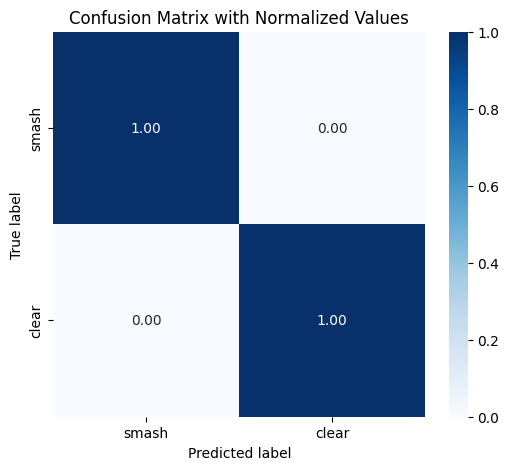

In [167]:
print(classification_report(labels_test, labels_pred, target_names=shot_labels))

# Generate the confusion matrix
cm = confusion_matrix(labels_test, labels_pred)

# Normalise by row sums to get the proportion of true labels per predicted label
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Convert to DataFrame for easier plotting
cm_df = pd.DataFrame(cmn, index=shot_labels, columns=shot_labels)

# Plotting the confusion matrix
plt.figure(figsize=(6,5))
sns.heatmap(cm_df, annot=True, fmt='.2f', cmap='Blues', xticklabels=shot_labels, yticklabels=shot_labels)
plt.title('Confusion Matrix with Normalized Values')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

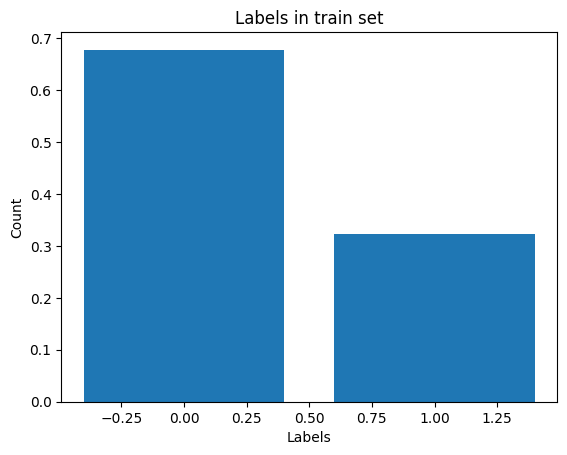

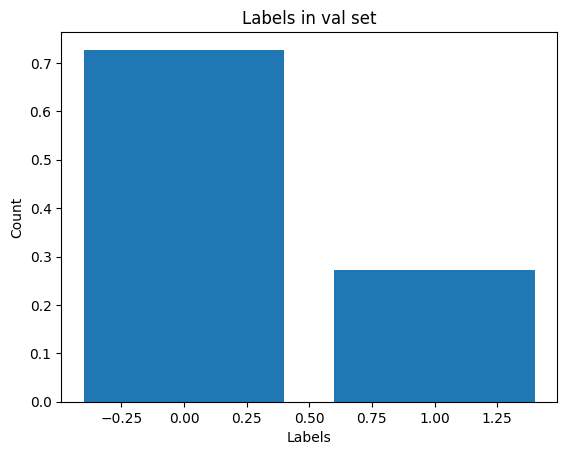

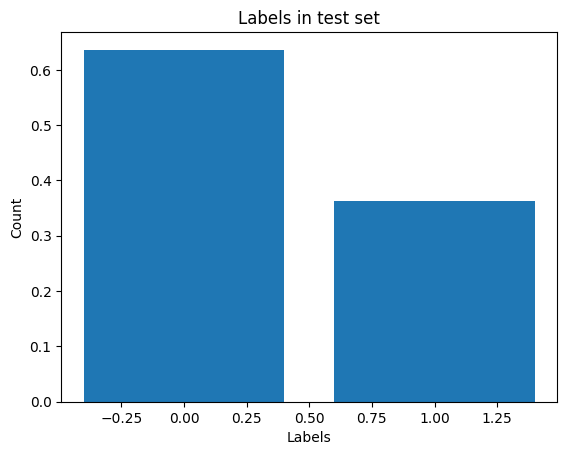

In [168]:
# Plot labels in train, validation and test sets
plt.bar([0, 1], labels_train_count)
plt.title('Labels in train set')
plt.ylabel('Count')
plt.xlabel('Labels')
plt.show()

plt.bar([0, 1], labels_val_count)
plt.title('Labels in val set')
plt.ylabel('Count')
plt.xlabel('Labels')
plt.show()

plt.bar([0, 1], labels_test_count)
plt.title('Labels in test set')
plt.ylabel('Count')
plt.xlabel('Labels')
plt.show()

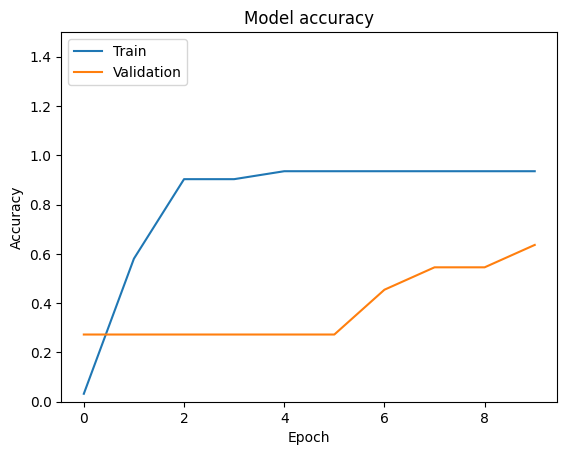

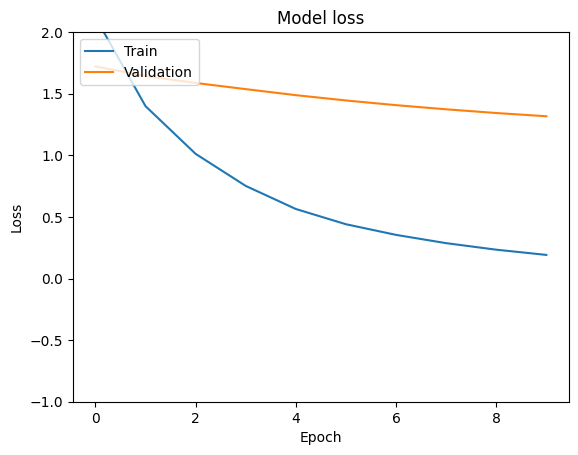

In [ ]:
# # Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.ylim(0, 1.5)
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# # Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.ylim(-1, 2)
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()